In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import time
from scipy.signal import savgol_filter
from scipy.signal import butter, sosfilt
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm
from scipy.fft import rfft, ifft, rfftfreq
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter
import matplotlib.cm as cm
import os
import math

In [448]:
f = h5py.File('Data/Test-923/Cs137-1min.h5', 'r')

test_data = pd.DataFrame(f['raw_data'])
test_np = test_data.to_numpy()

sat_i = []
for i in range(len(test_np)):
    if test_np[i][1300] == 16383:
        sat_i.append(i)

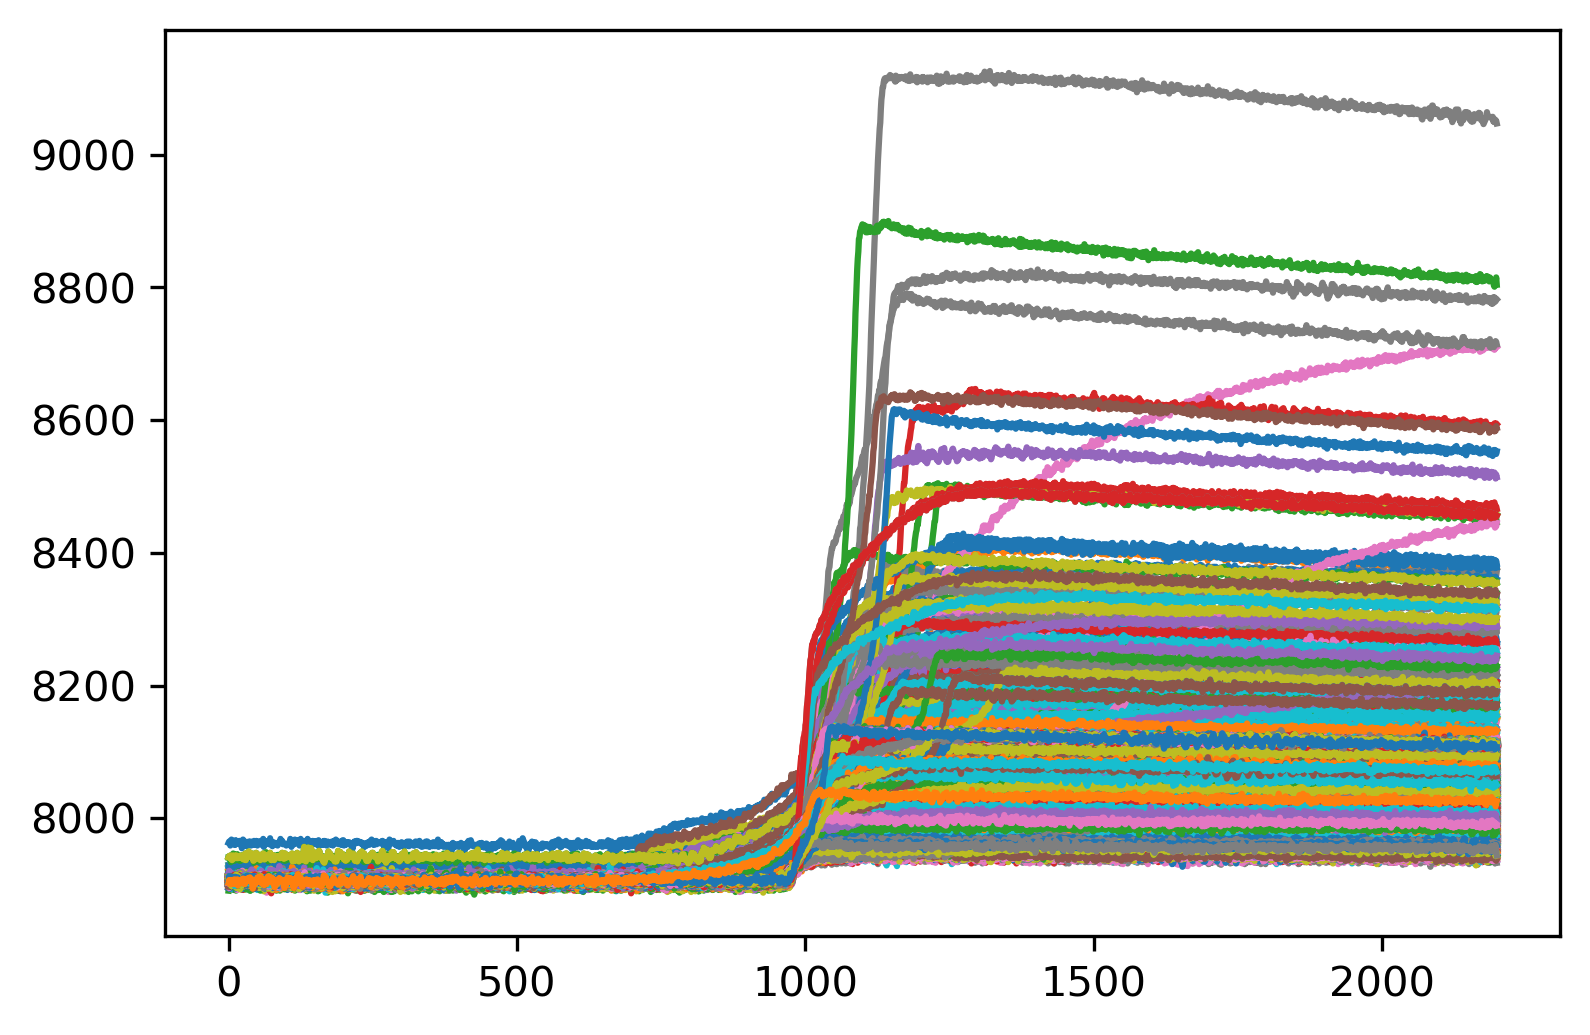

In [3]:
plt.figure(dpi=300)
for i in range(len(test_np)):
    if max(test_np[i]) < 9500:
        plt.plot(test_np[i][:2200])

24 Saturated pulses


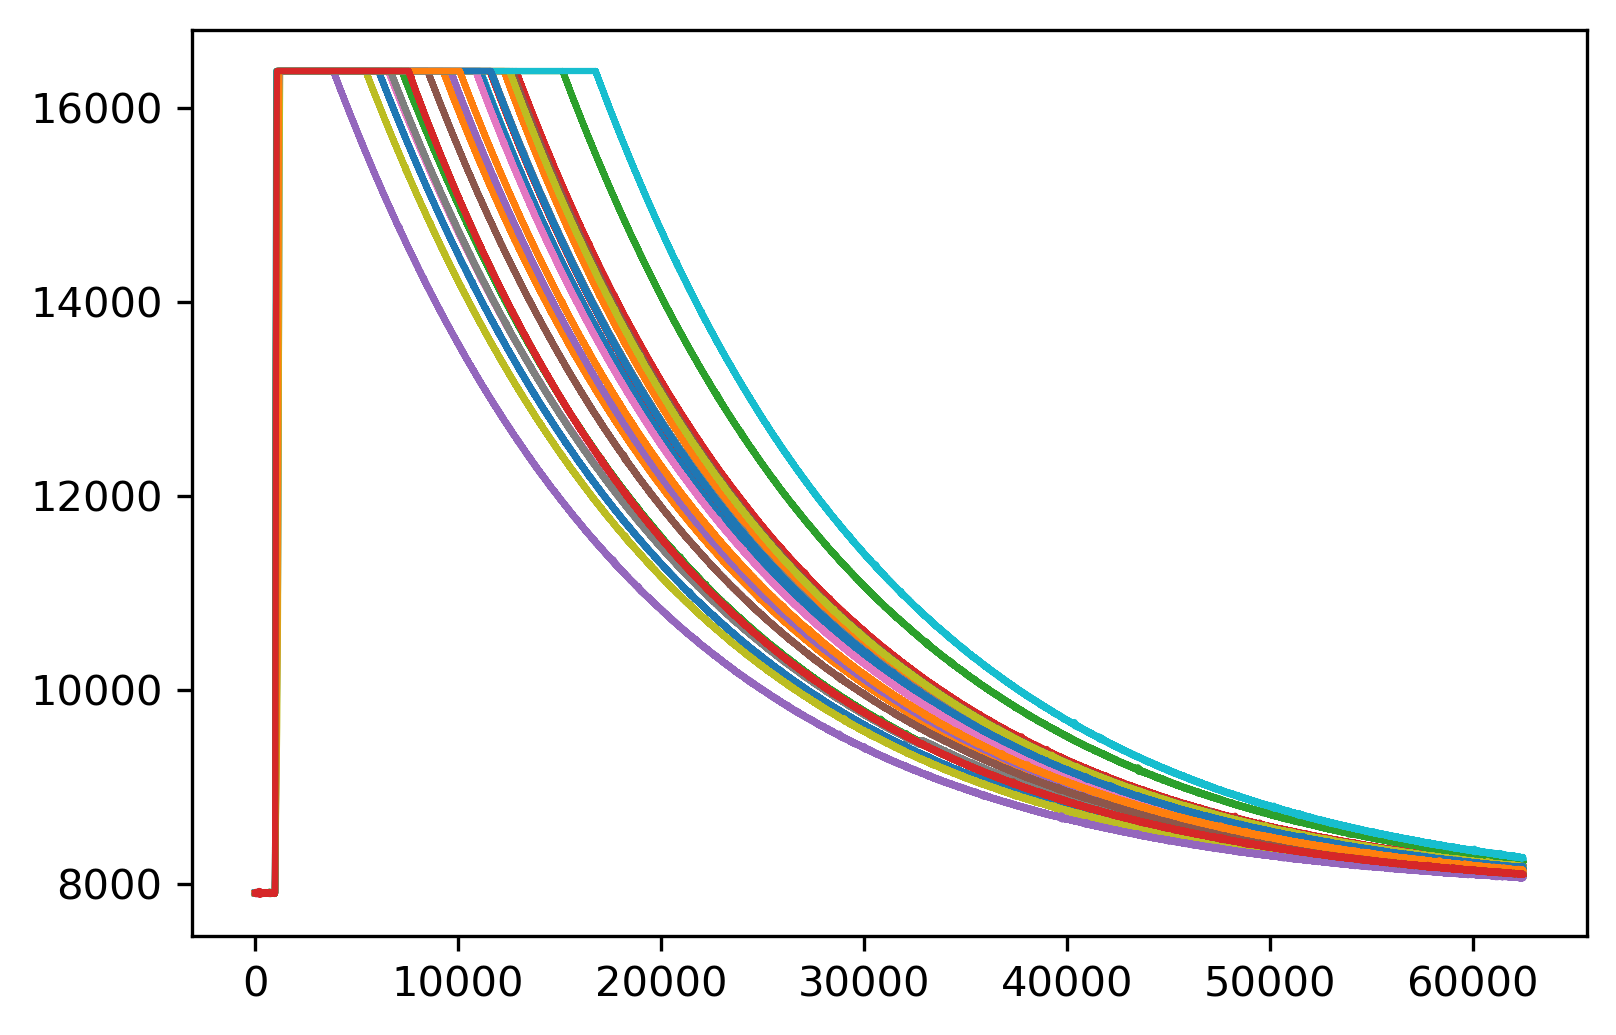

In [13]:
plt.figure(dpi=300)
for i in sat_i:
     plt.plot(test_np[i])
print(len(sat_i), "Saturated pulses")
plt.show()

In [3]:
t = np.arange(2000)

tau_r, tau_f = 20, 2000
shift = 500
test_pulse = np.exp(-(t-shift)/tau_f)*(1-np.exp(-(t-shift)/tau_r))
test_pulse_fix = np.where(test_pulse<0, 0, test_pulse)

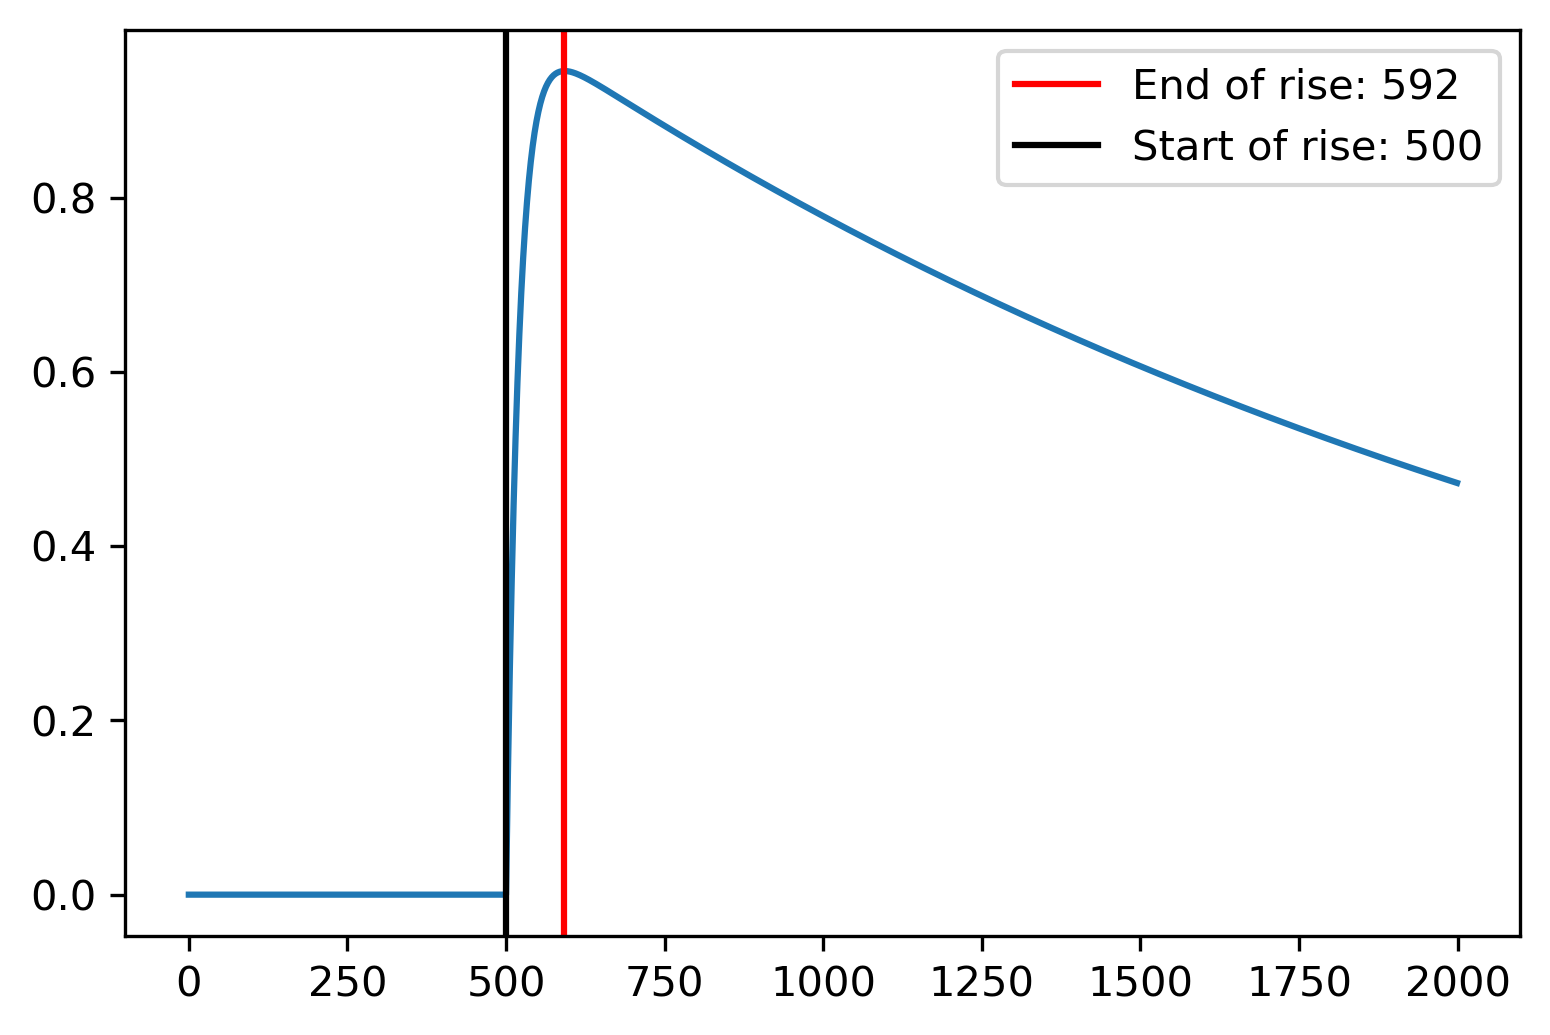

In [4]:
plt.figure(dpi=300)
plt.plot(t, test_pulse_fix)
plt.axvline(np.argmax(test_pulse_fix), c='r', label='End of rise: {}'.format(np.argmax(test_pulse_fix)))
plt.axvline(shift, c='k', label='Start of rise: {}'.format(shift))
plt.legend()
#plt.xlim(0, 5000)
plt.show()

In [665]:
def delay_signal(signal, delay=2000, w=500):
    noise_samp = signal[:w]
    mean, std = np.mean(noise_samp), np.std(noise_samp)
    noise = np.random.normal(mean, 0.9*std, delay)
    return np.hstack([noise, signal])

def dkl(signal, i, k, l, w=0):
    if w == 0:
        w = 2*k+l
    signal = delay_signal(signal, delay=w)
    vj = signal[i+w:i+w+w]
    vjk = signal[i-k+w:i+w+w-k]
    vjl = signal[i-l+w:i+w+w-l]
    vjkl = signal[i-k-l+w:i+w+w-k-l]
    try:
        return vj - vjk - vjl + vjkl
    except:
        print(i, k, l, w)
        return vj - vjk - vjl + vjkl
    
def s(signal, start_rise, tau, peaking_time, gap_time, w=0):
    if w == 0:
        w = 2*peaking_time+(peaking_time+gap_time)
    ss = []
    for j in range(w):
        if j == 0:
            ss.append(0)
        else:
            ss.append(ss[j-1]*(1+1/tau)+ dkl(signal, start_rise, peaking_time, peaking_time+gap_time, w)[j])
    return np.array(ss)

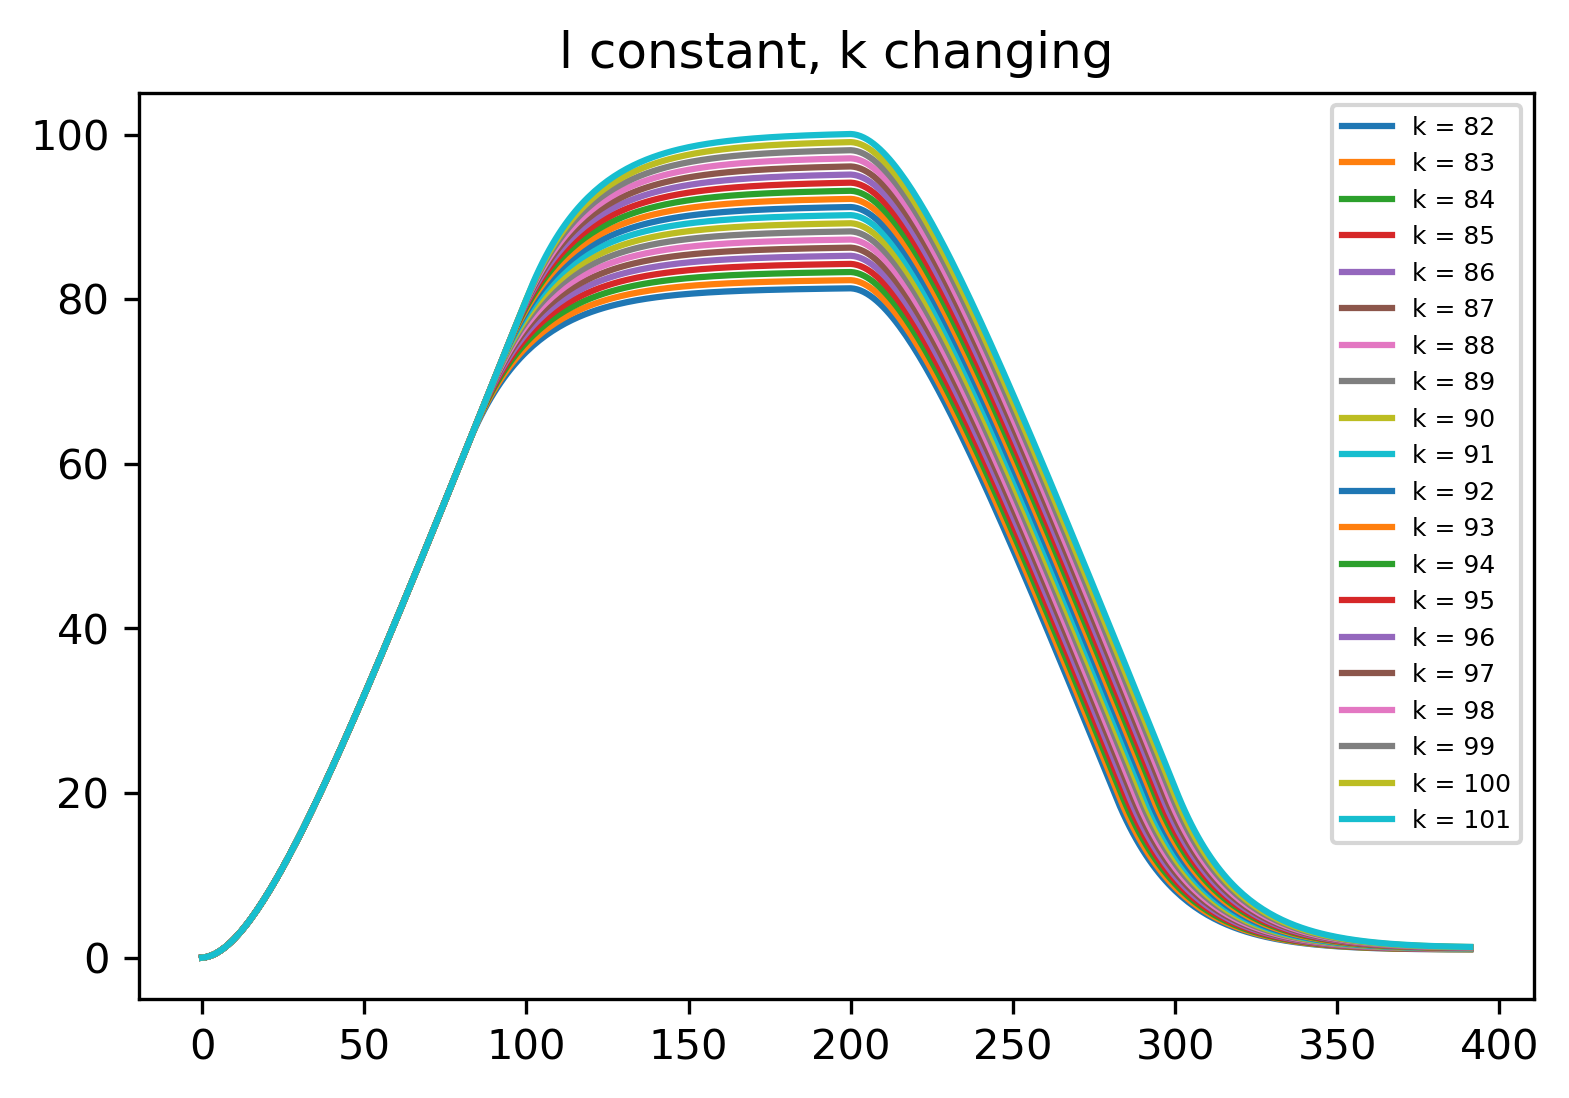

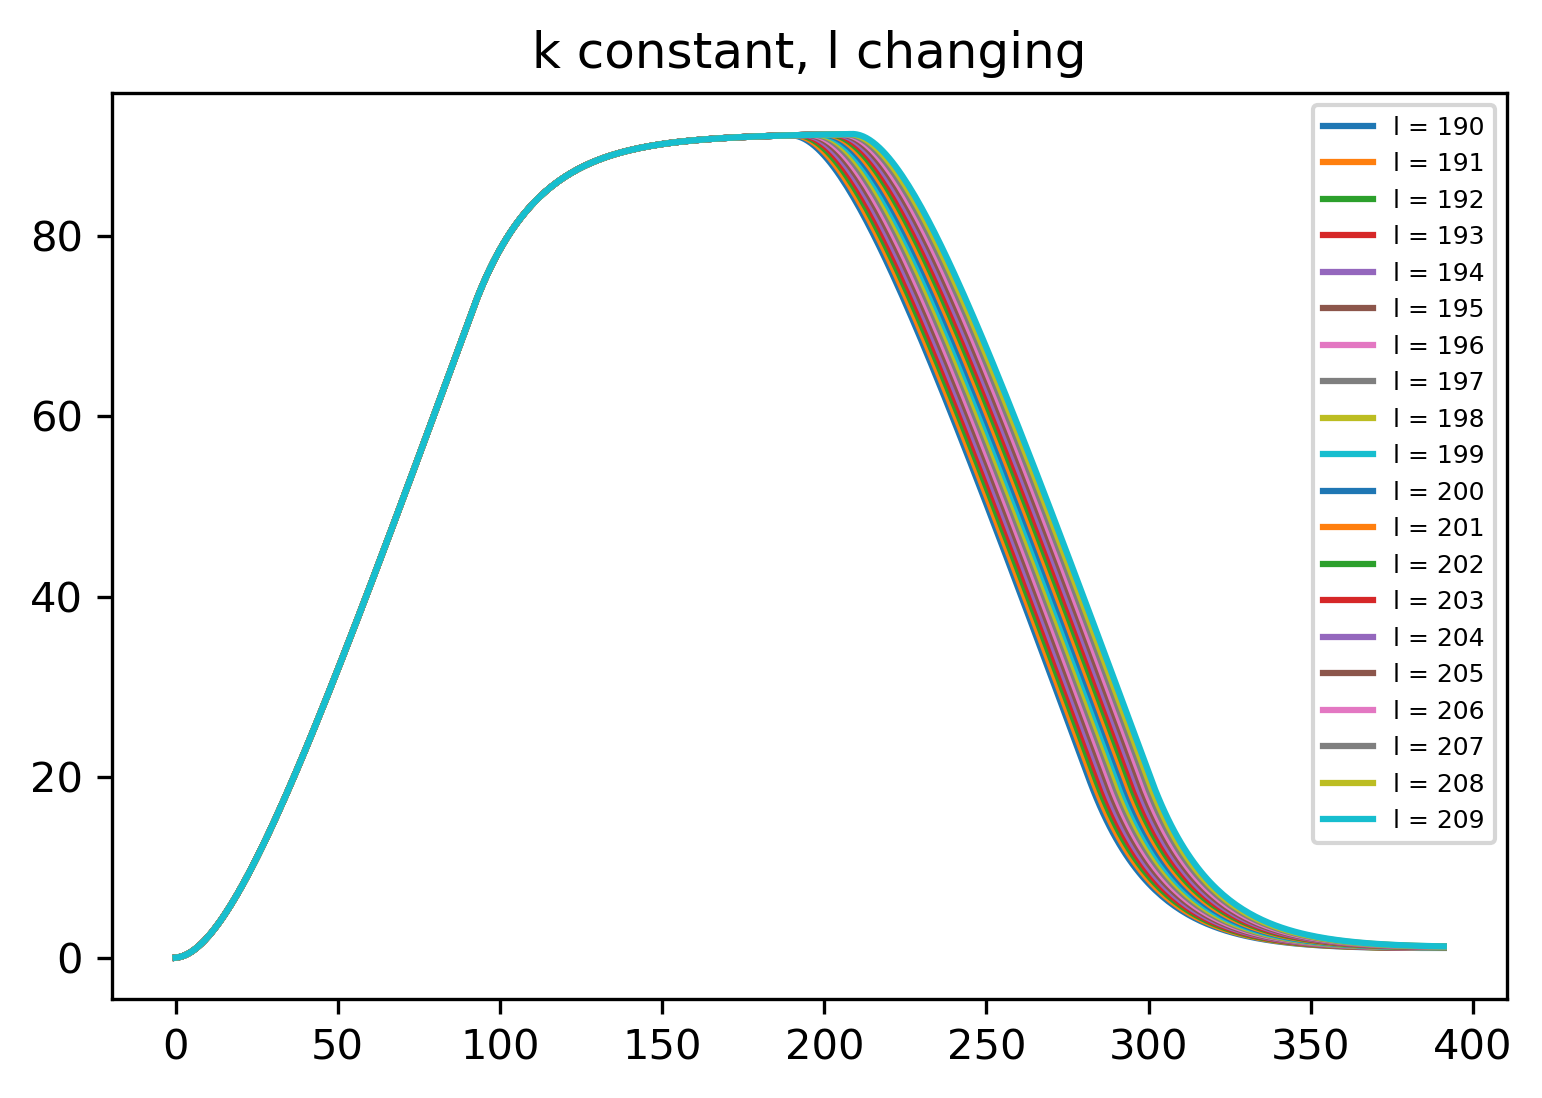

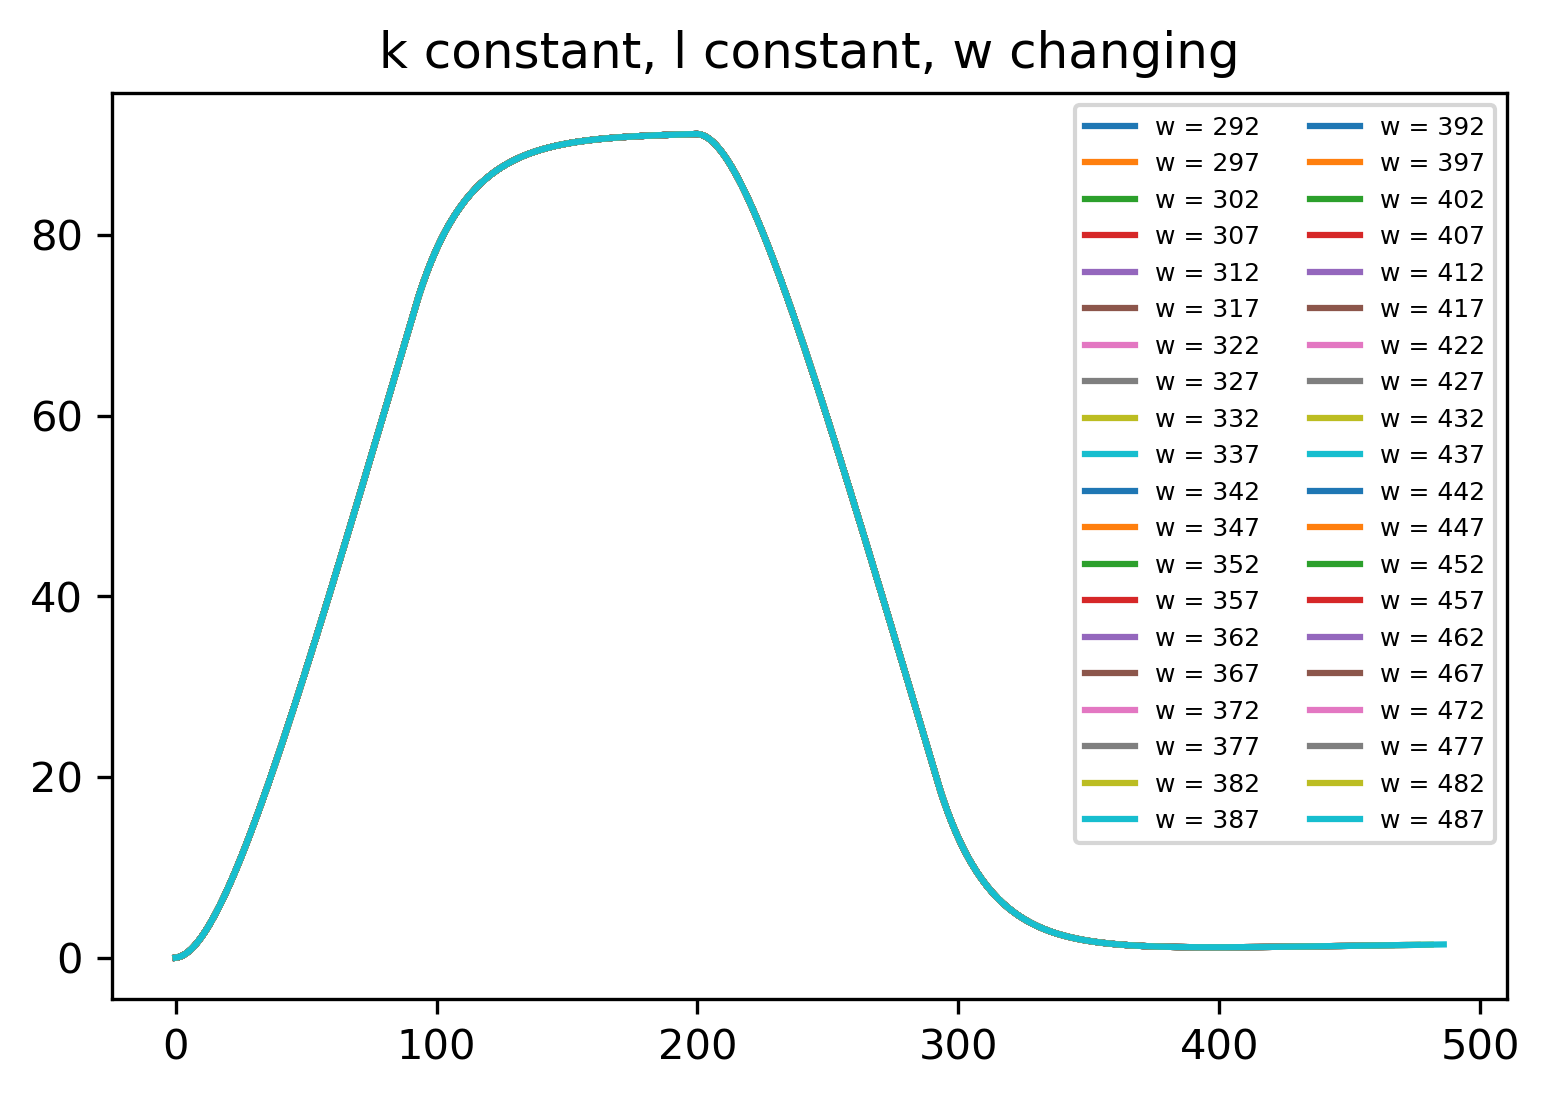

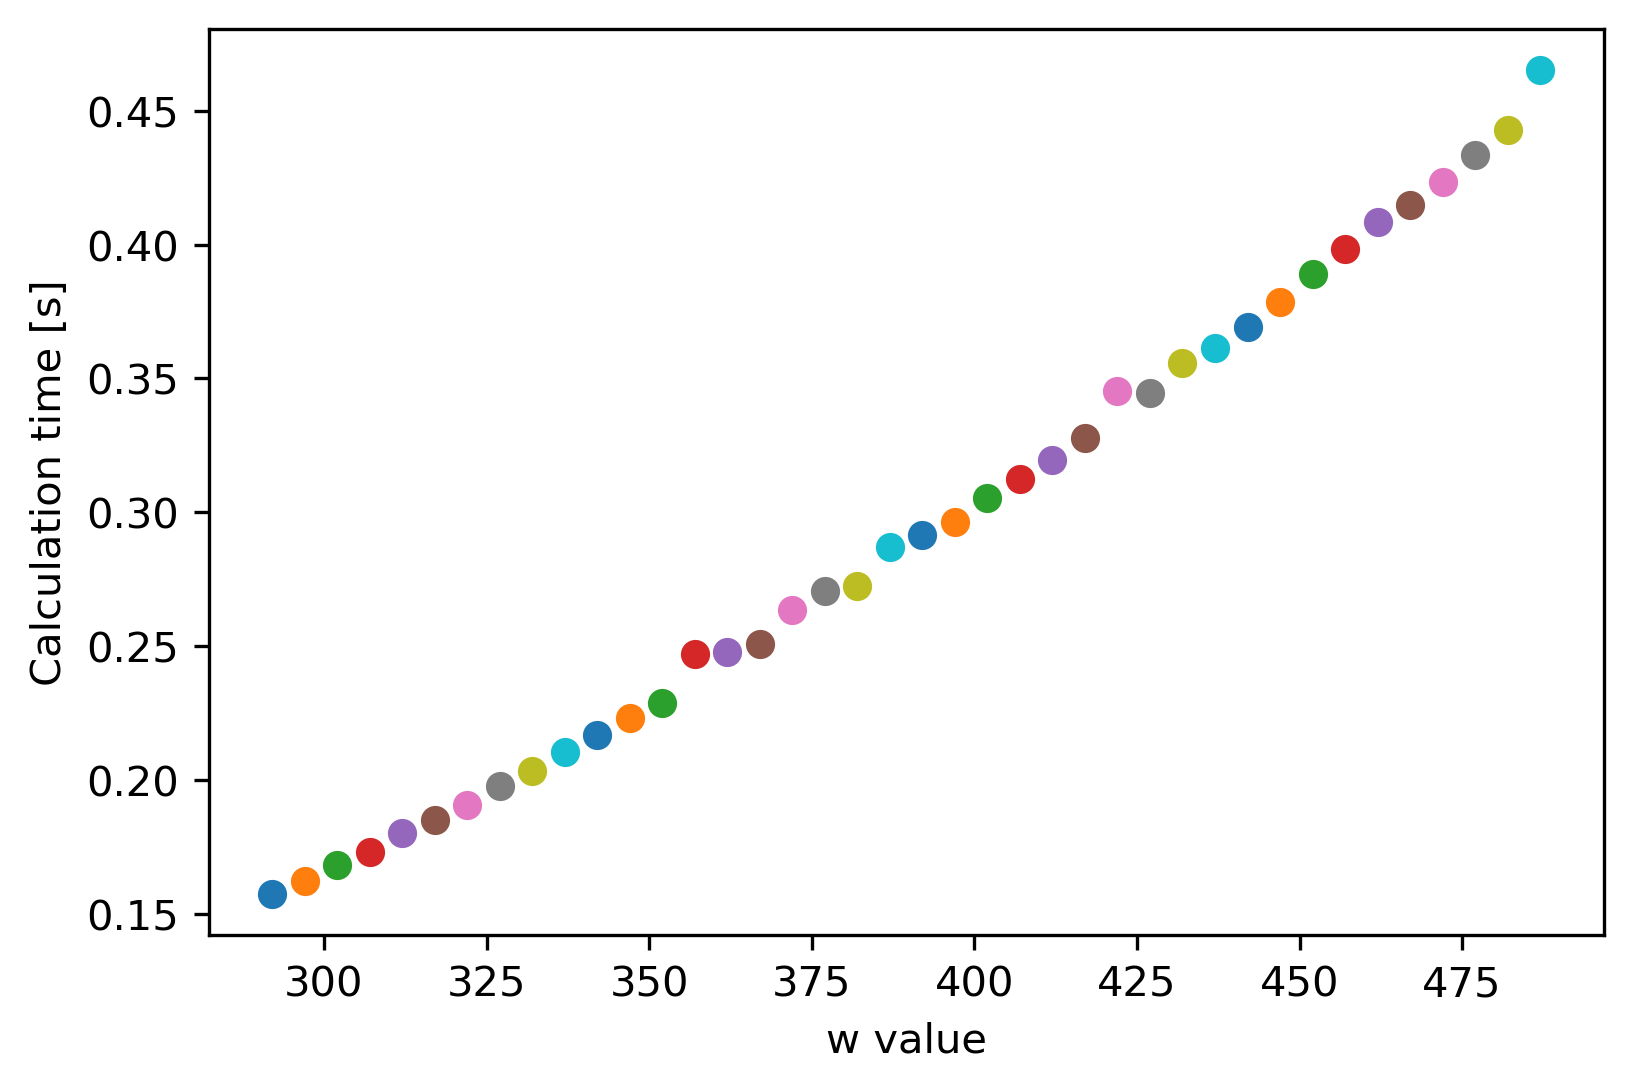

In [47]:
k, l = 92, 200
w = k+l+100
plt.figure(dpi=300)
for k_t in np.arange(k-10, k+10):
    plt.plot(s(test_pulse_fix, shift, tau_f, k_t, l, w), label='k = {}'.format(k_t))
plt.title('l constant, k changing')
plt.legend(fontsize=6)
plt.show()

plt.figure(dpi=300)
for l_t in np.arange(l-10, l+10):
    plt.plot(s(test_pulse_fix, shift, tau_f, k, l_t, w), label='l = {}'.format(l_t))
plt.title('k constant, l changing')
plt.legend(fontsize=6)
plt.show()

plt.figure(dpi=300)
w_time = []
for w_t in np.arange(w-100, w+100)[::5]:
    start_time = time.time()
    s_t = s(test_pulse_fix, shift, tau_f, k, l, w_t)
    w_time.append([w_t, time.time()-start_time])
    plt.plot(s_t, label='w = {}'.format(w_t))
plt.title('k constant, l constant, w changing')
plt.legend(fontsize=6, ncol=2)
plt.show()

plt.figure(dpi=300)
for w_ti in w_time:
    plt.scatter(w_ti[0], w_ti[1])
plt.xlabel('w value')
plt.ylabel('Calculation time [s]')
plt.show()

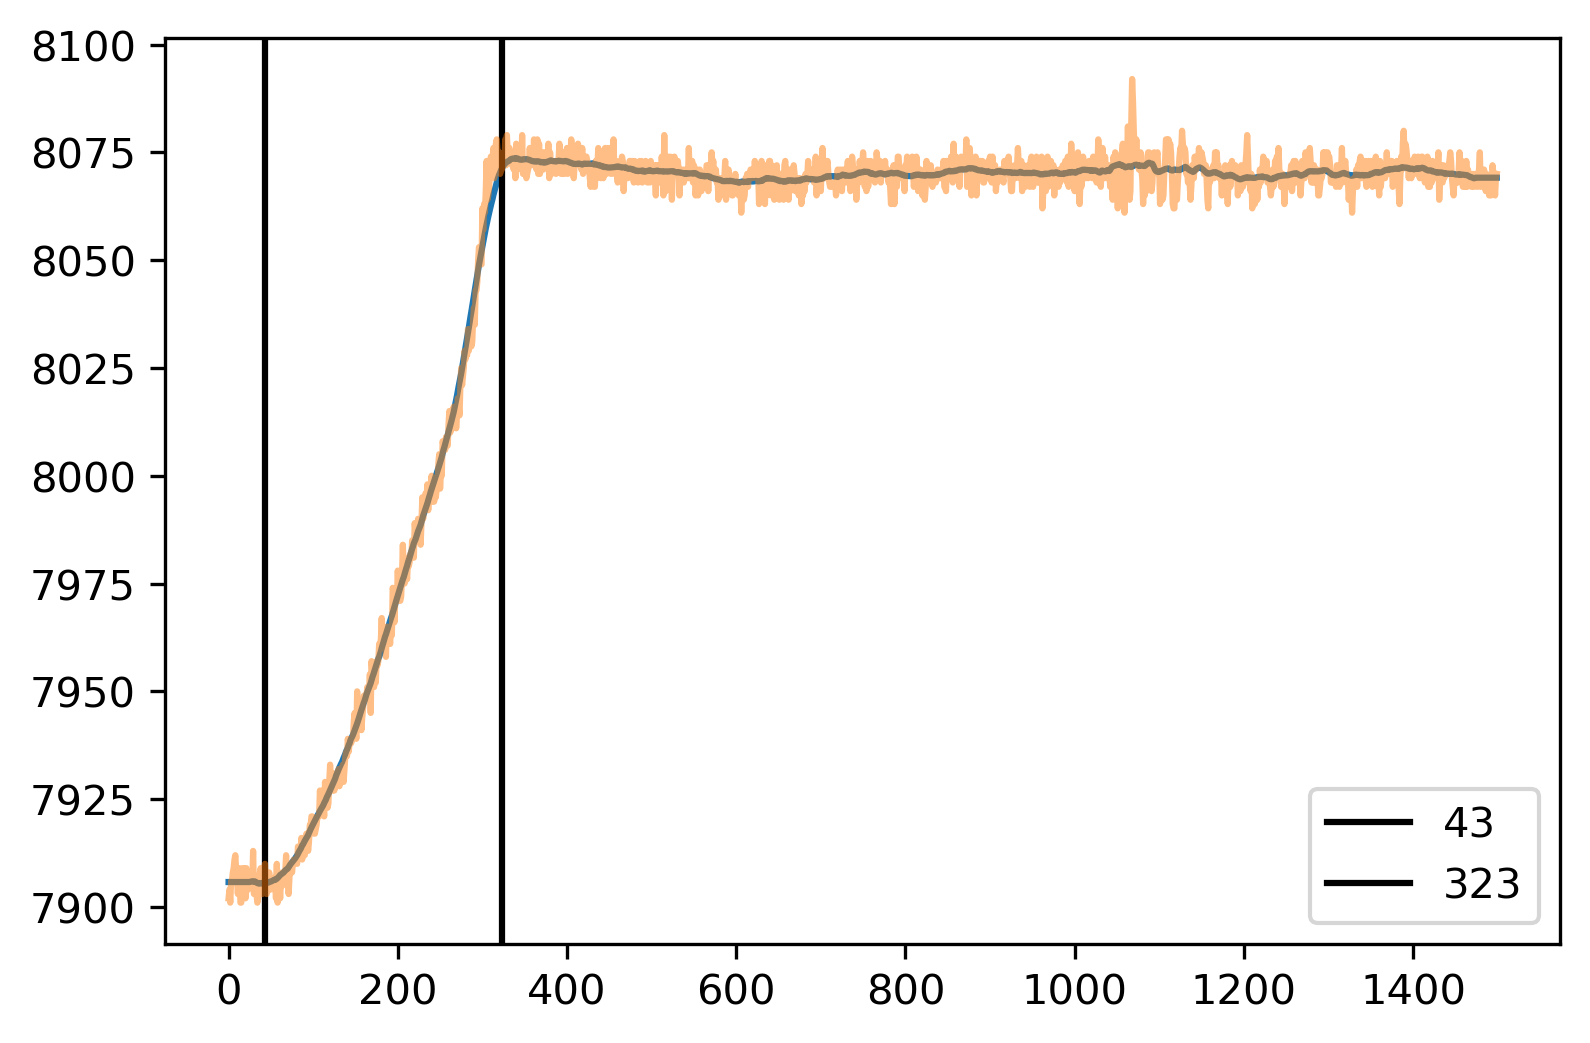

280
17042.937775260074


/var/folders/s7/9wfql9sd5c5dj0c1vflrn_d40000gn/T/ipykernel_30456/2527814596.py:2: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-b*t)+c


In [317]:
ind = 19
min_s, ra = 700, 51
plt.figure(dpi=300)
plt.plot(savgol_filter(test_np[ind][min_s:2200], ra, 0))
_min, _max = np.argmin(savgol_filter(test_np[ind][min_s:2200], ra, 2)), np.argmax(savgol_filter(test_np[ind][min_s:2200], ra, 2))
plt.axvline(_min, c='k', label=_min)
plt.axvline(_max, c='k', label=_max)
plt.plot(test_np[ind][min_s:2200], alpha=0.5)
plt.legend()
#plt.xlim(800, 2000)
plt.show()
print(_max-_min)

norm_sig = test_np[ind]/max(test_np[ind])
norm_sig_decay = norm_sig[np.argmax(norm_sig):]
popt_raw, pcov_raw = curve_fit(exp_fun, np.arange(len(norm_sig_decay)), norm_sig_decay)
print(1/popt_raw[1])

([], [])

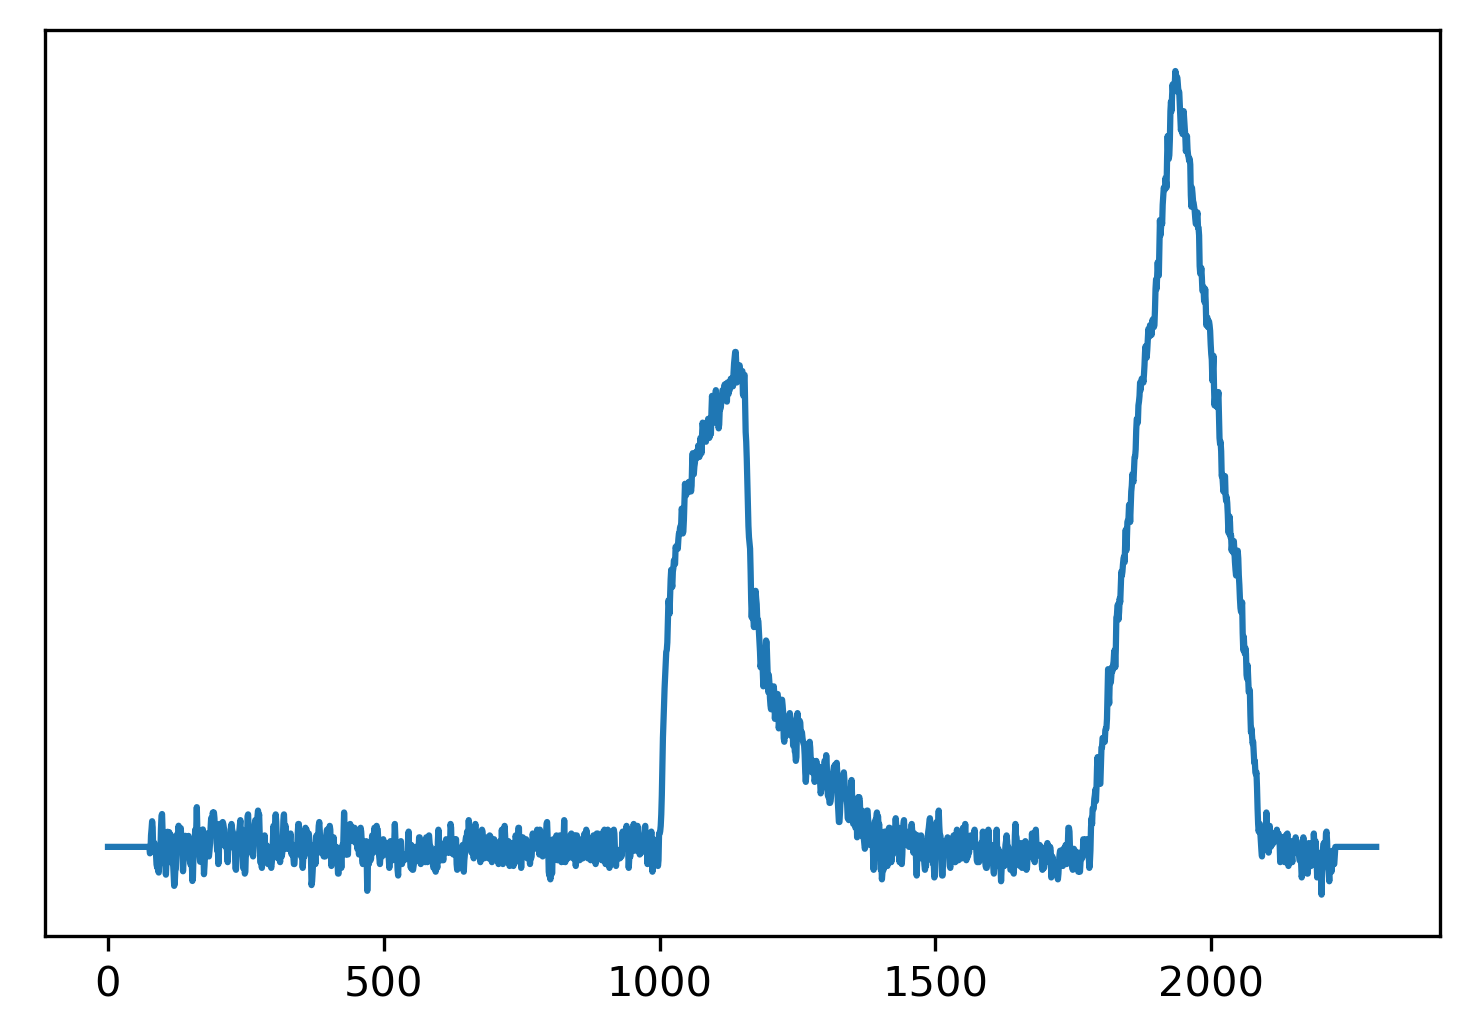

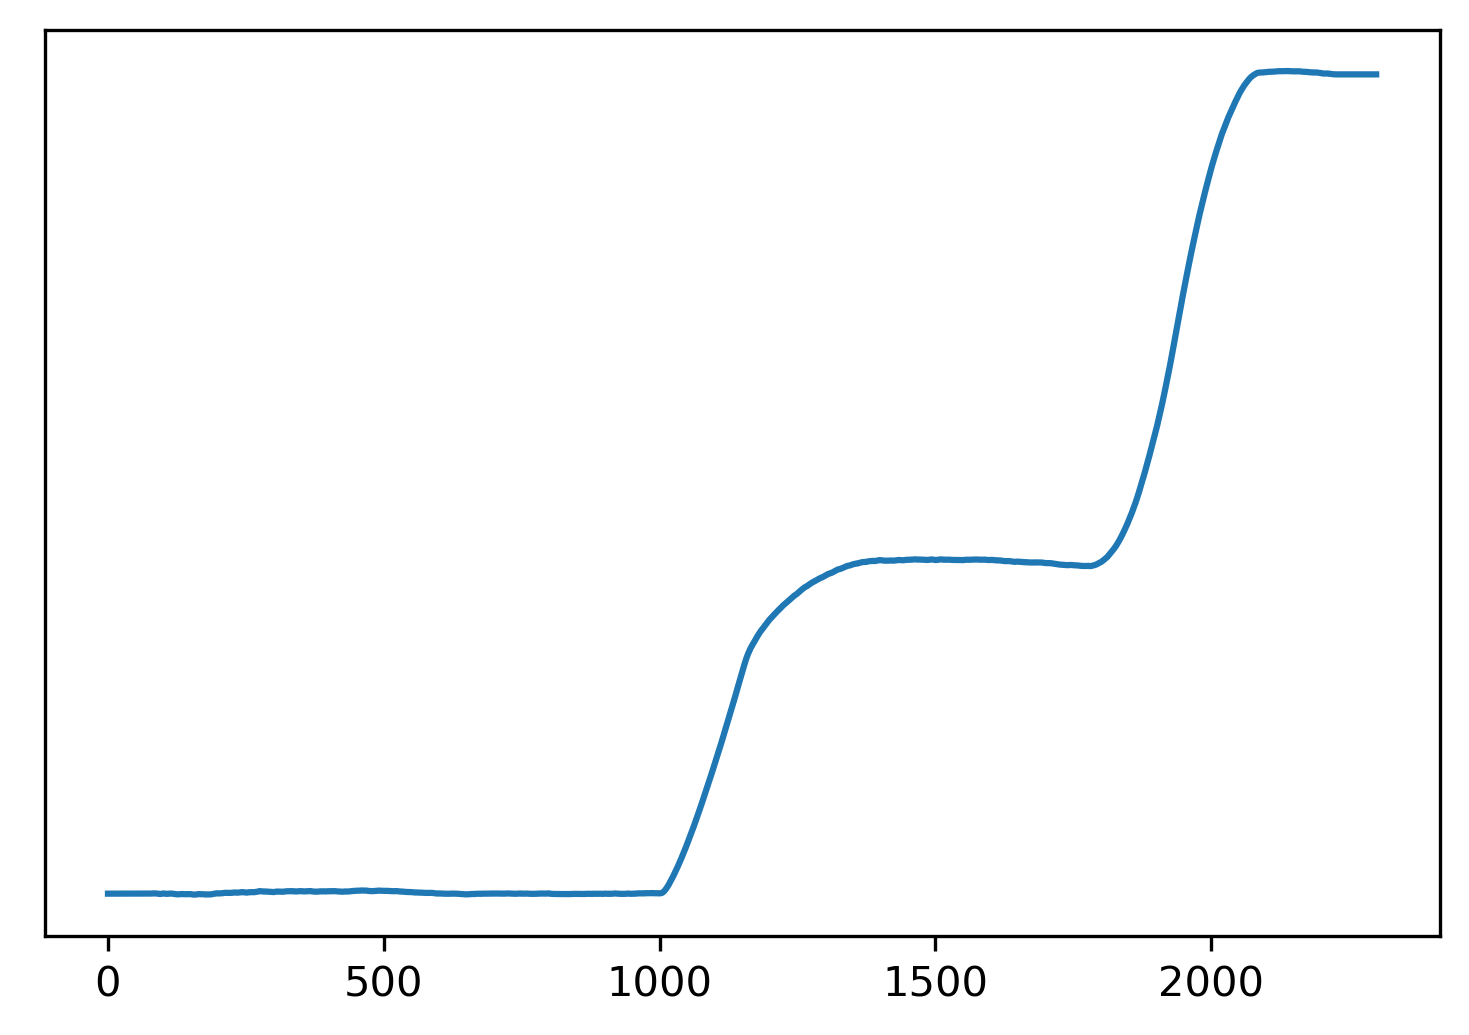

In [278]:
ind = 10
ra = 151

sig = savgol_filter(extend_pretrigger(test_np[ind][:2200], l=100), ra, 0)
sig_ = sig/max(sig)

g = np.gradient(sig)
g_ = g/max(g)

plt.figure(dpi=300)
plt.plot(g_)
plt.yticks([])

plt.figure(dpi=300)
plt.plot(sig_)
plt.yticks([])

In [283]:
def delay_signal(signal, delay=2000, w=500):
    noise_samp = signal[:w]
    mean, std = np.mean(noise_samp), np.std(noise_samp)
    noise = np.random.normal(mean, 0.9*std, l)
    return np.hstack([noise, signal])

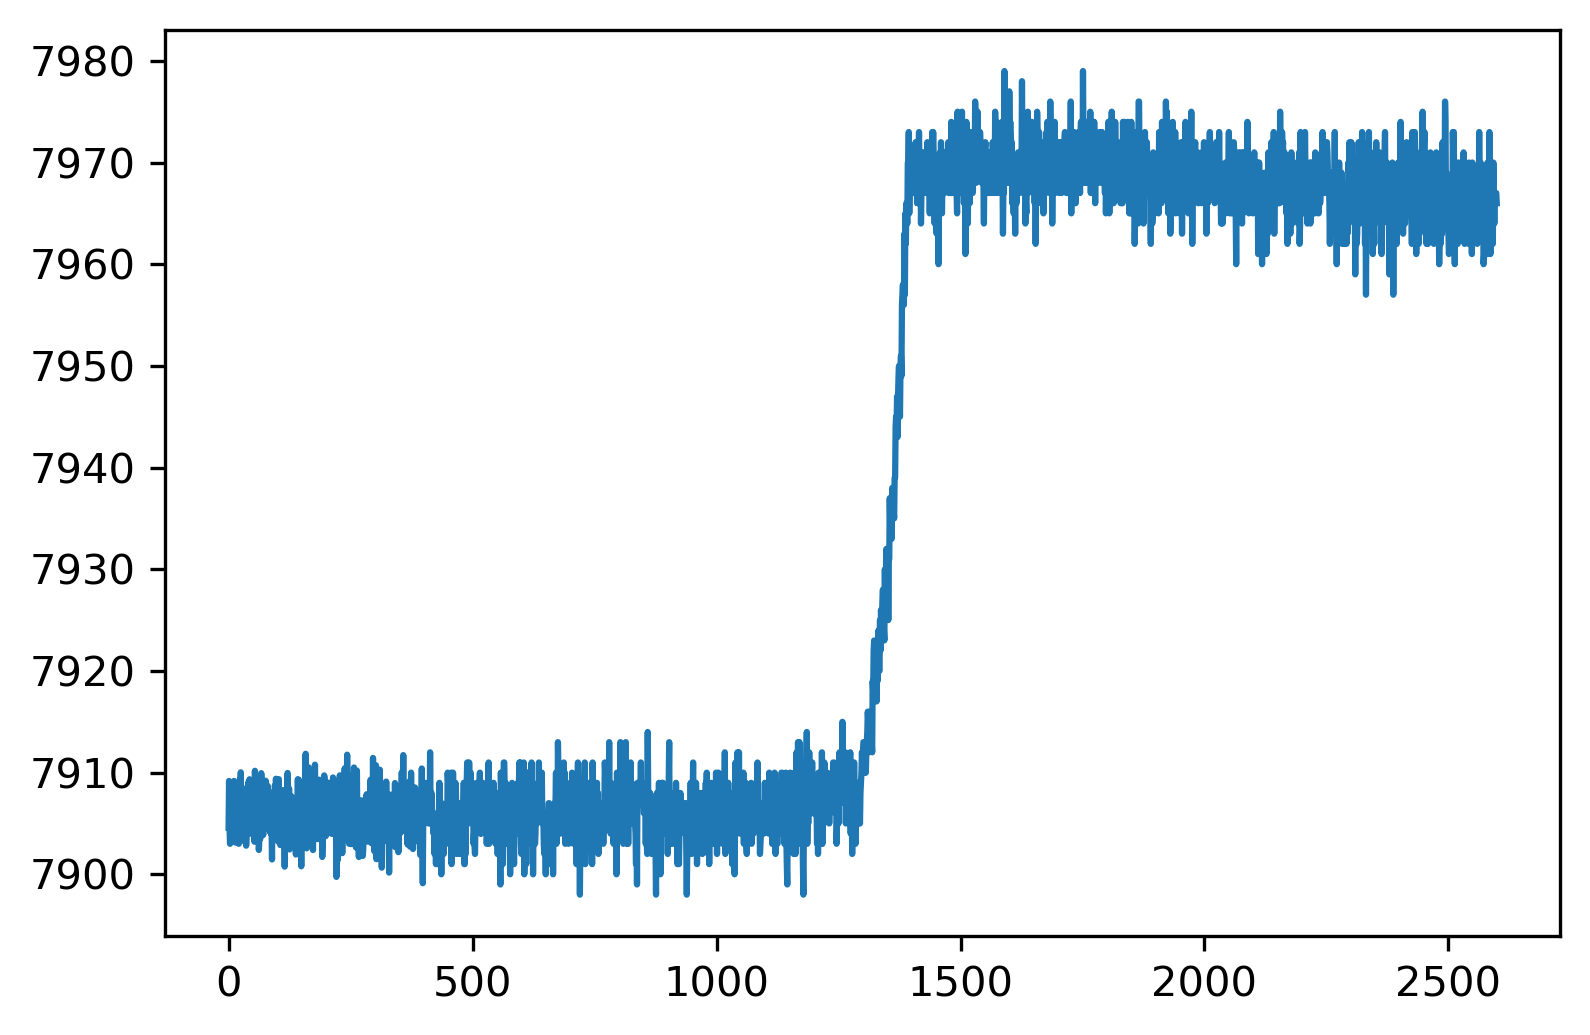

In [284]:
ind = 3

plt.figure(dpi=300)
plt.plot(delay_signal(test_np[ind][:2200], delay=70))
plt.show()

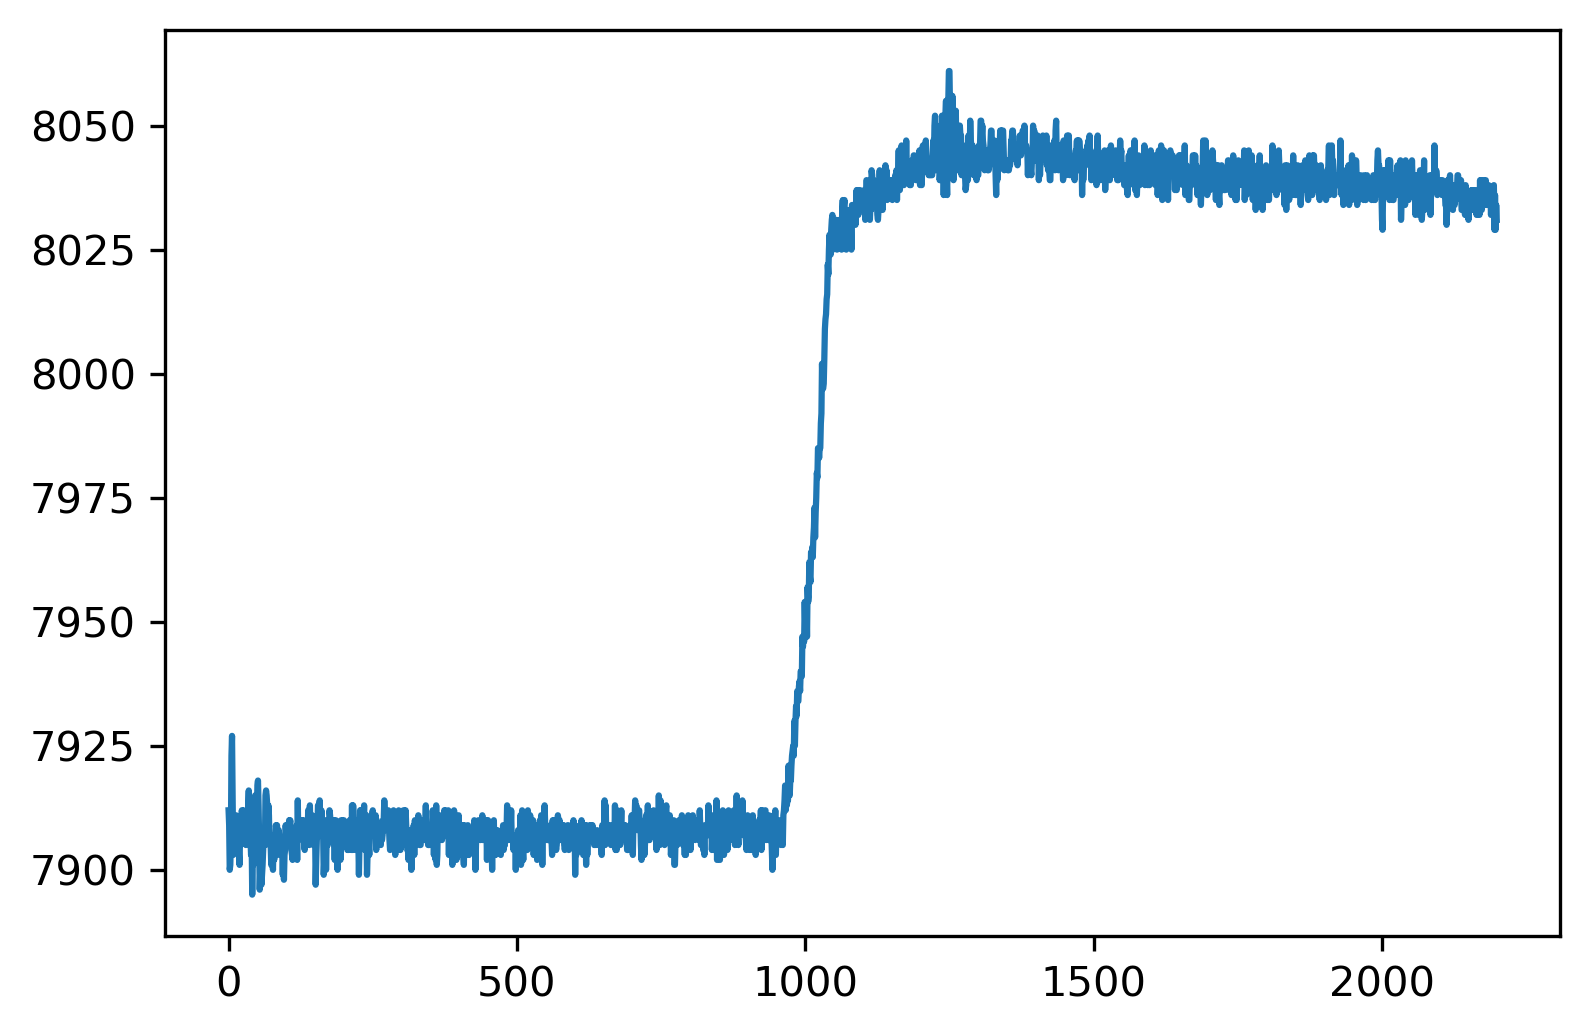

In [238]:
plt.figure(dpi=300)
plt.plot(test_np[0][:2200])


In [384]:
def get_k(signal):
    end_index = np.argmax(signal)
    diff_list = []
    N = 0
    diff_array = np.array([signal[end_index] - signal[end_index - n] for n in range(end_index)])
    med = np.mean(diff_array[500:])
    for n in range(len(diff_array)):
        if diff_array[n]>0.9999998*med:
            N = n
            break
    return np.array([N, end_index])
    #return diff_array

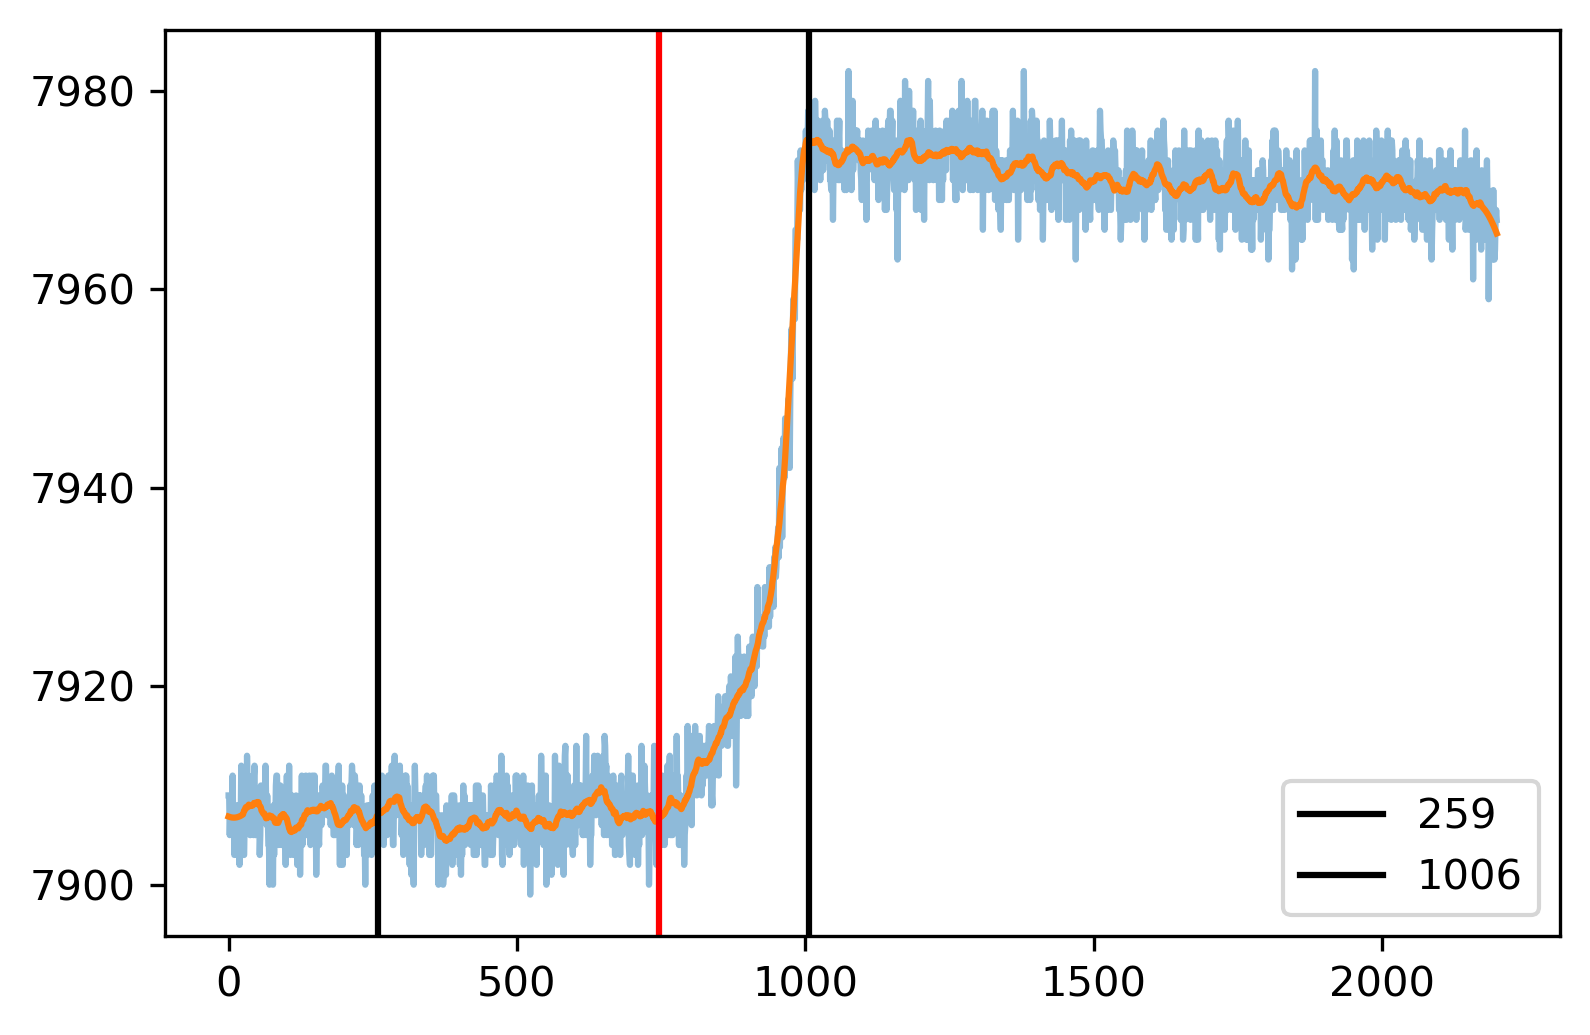

In [401]:
ind, ra = 1500, 51
fs = savgol_filter(test_np[ind][:2200], ra, 2)

gk = get_k(fs)

plt.figure(dpi=300)
plt.plot(test_np[ind][:2200], alpha=0.5)
plt.plot(fs)
plt.axvline(gk[0], c='k', label=gk[0])
plt.axvline(gk[1], c='k', label=gk[1])
plt.axvline(gk[1]-gk[0], c='r')
#plt.plot(gk)
plt.legend()
plt.show()

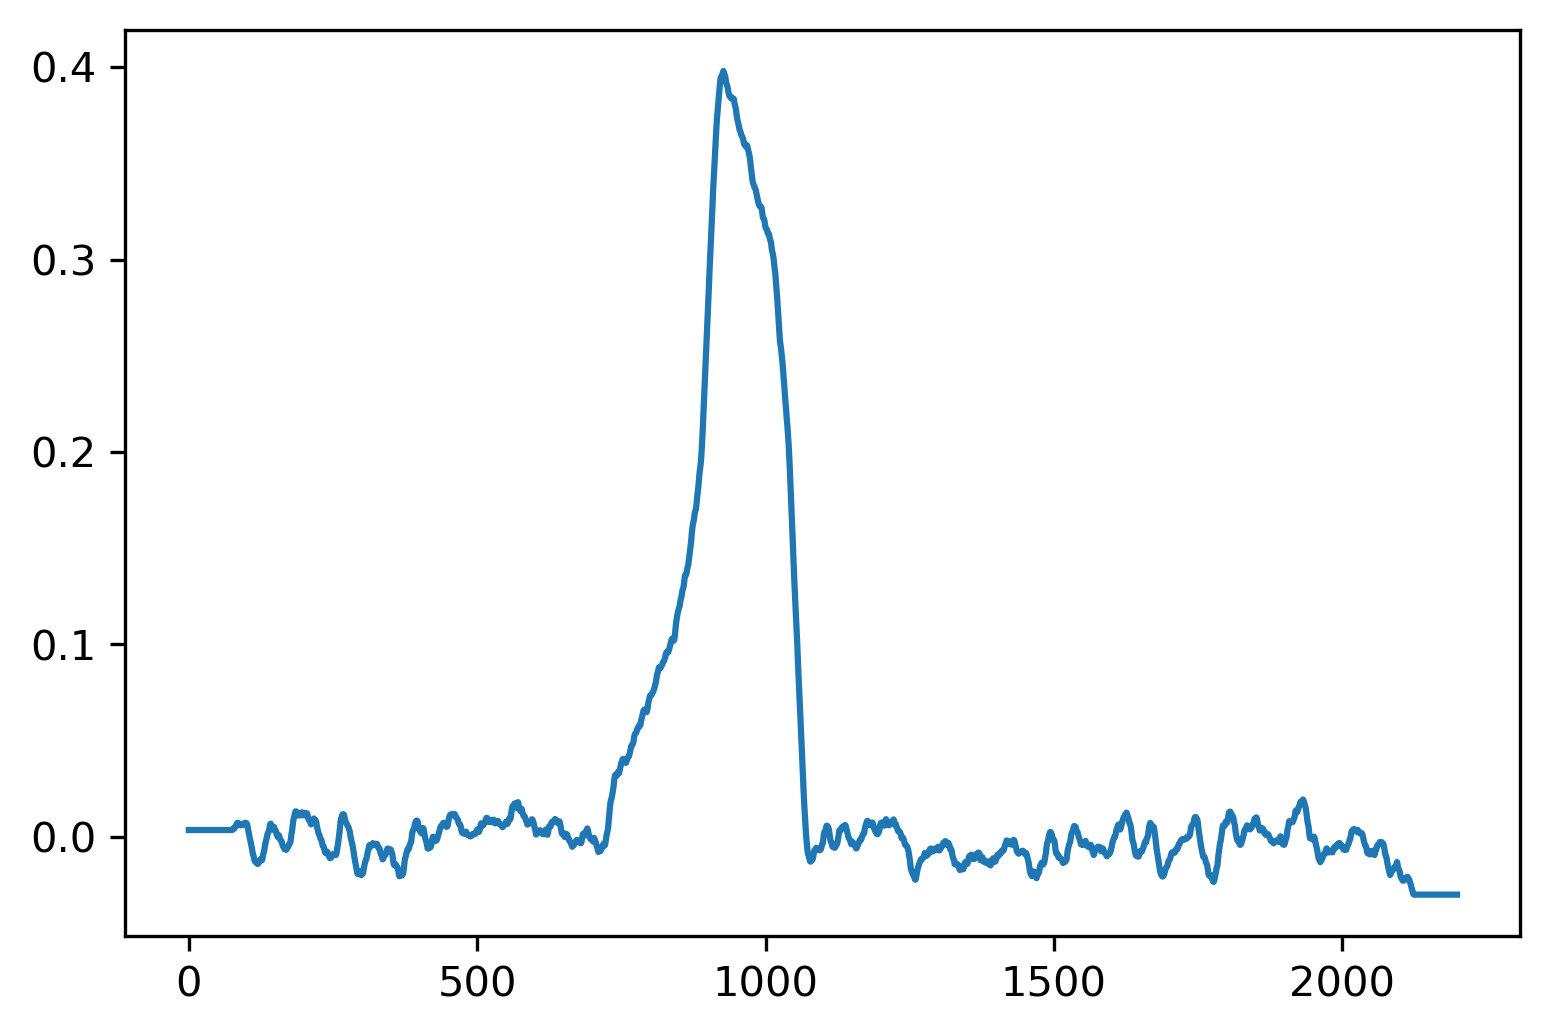

In [407]:
ind, ra = 1500, 51
fs = savgol_filter(test_np[ind][:2200], ra, 2)

plt.figure(dpi=300)
plt.plot(savgol_filter(np.gradient(fs), 151, 0))
plt.show()

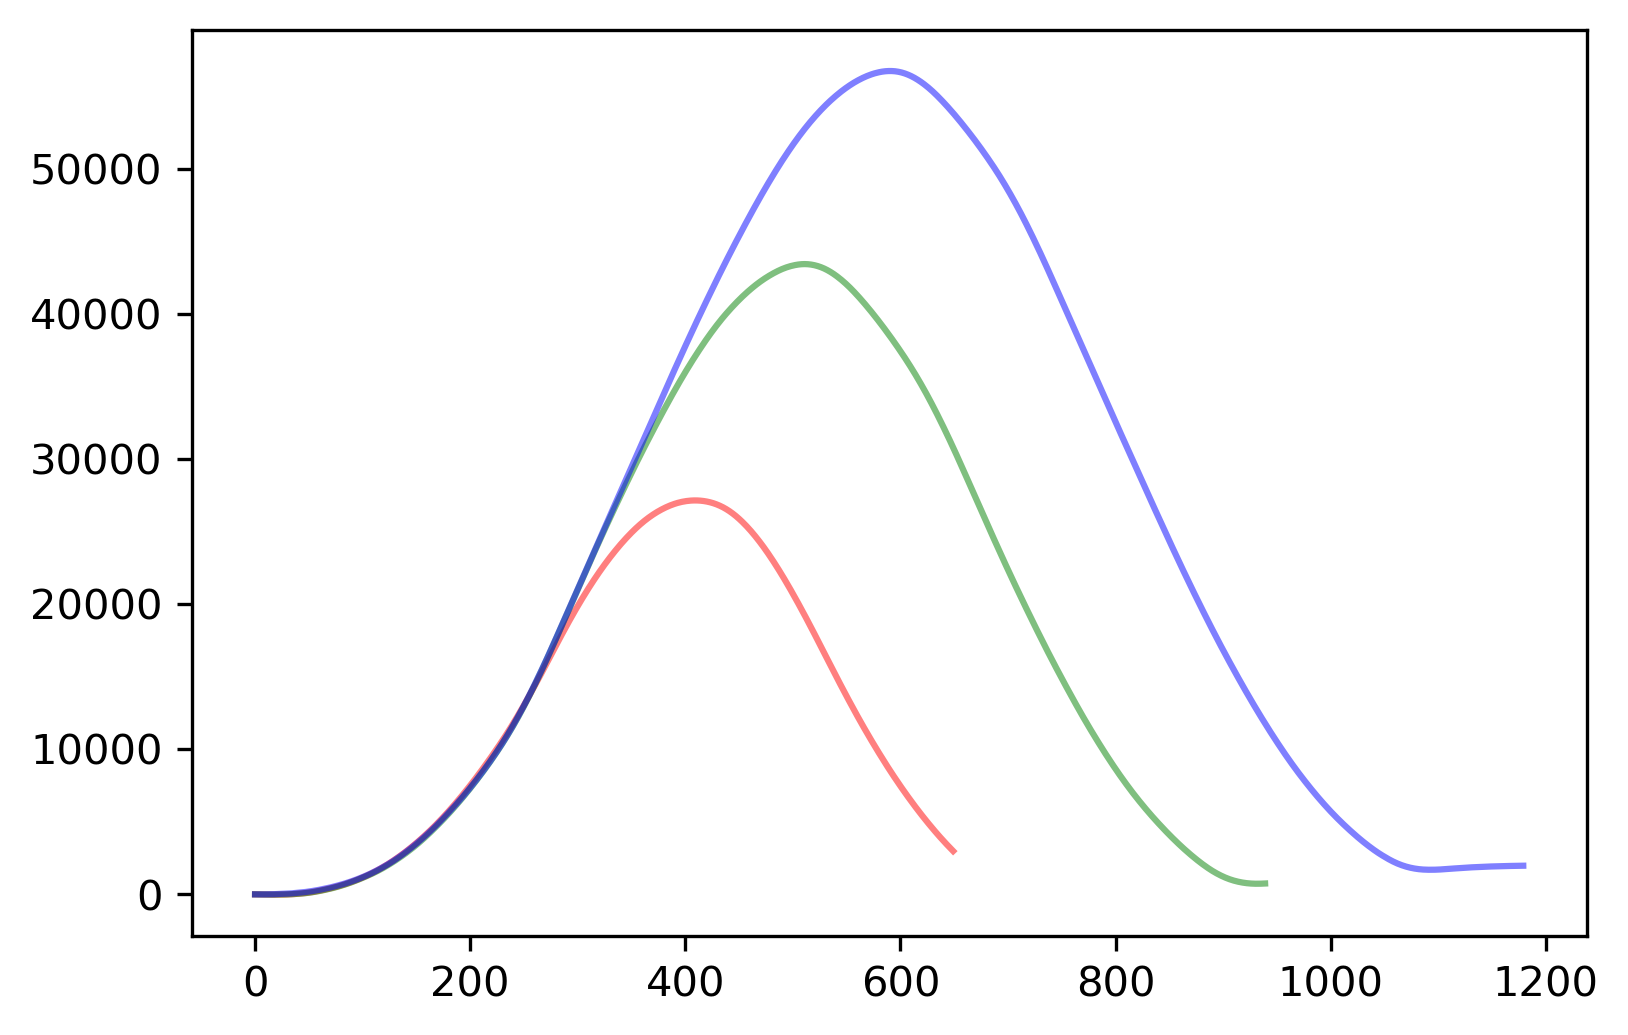

In [452]:
ind, ra = 19, 51
peak, gap = 200, 50
fs = savgol_filter(test_np[ind][:2200], ra, 0)
plt.figure(dpi=300)
plt.plot(s(fs, 743, 15000, peak, gap), c='r', alpha=0.5)

peak, gap = 280, 100
plt.plot(s(fs, 743, 15000, peak, gap), c='g', alpha=0.5)

peak, gap = 360, 100
plt.plot(s(fs, 743, 15000, peak, gap), c='b', alpha=0.5)
plt.show()

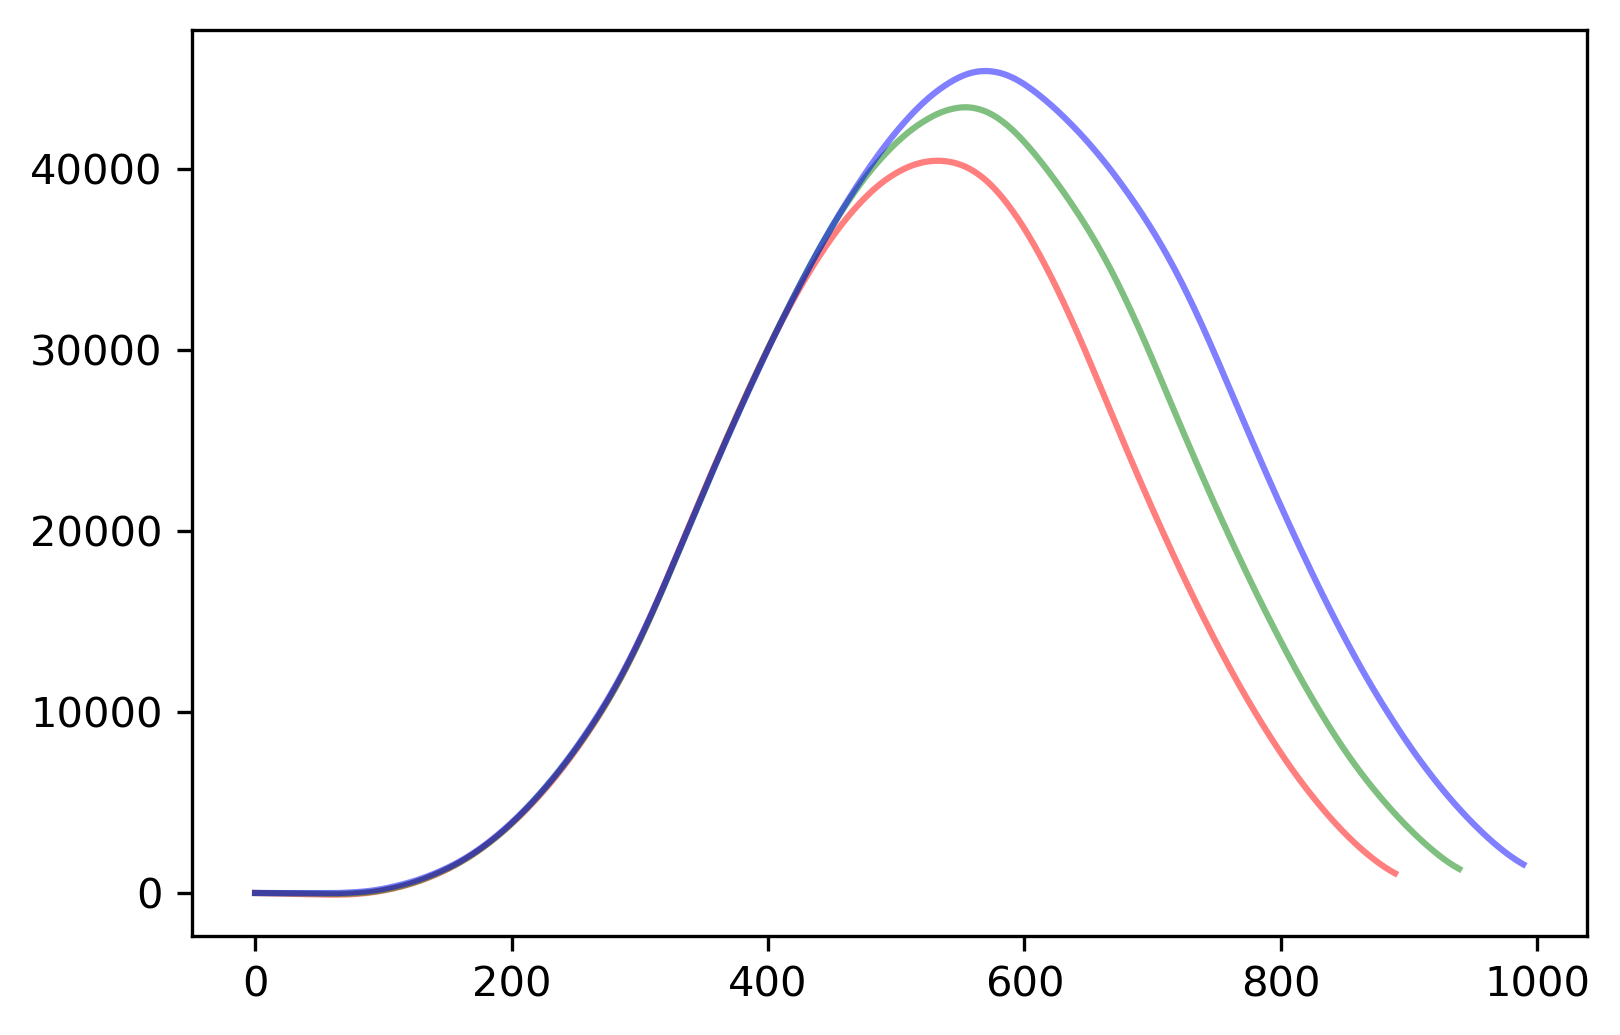

In [451]:
ind, ra = 19, 51
peak, gap = 280, 50
fs = savgol_filter(test_np[ind][:2200], ra, 0)
plt.figure(dpi=300)
plt.plot(s(fs, 700, 15000, peak, gap), c='r', alpha=0.5)

peak, gap = 280, 100
plt.plot(s(fs, 700, 15000, peak, gap), c='g', alpha=0.5)

peak, gap = 280, 150
plt.plot(s(fs, 700, 15000, peak, gap), c='b', alpha=0.5)
plt.show()

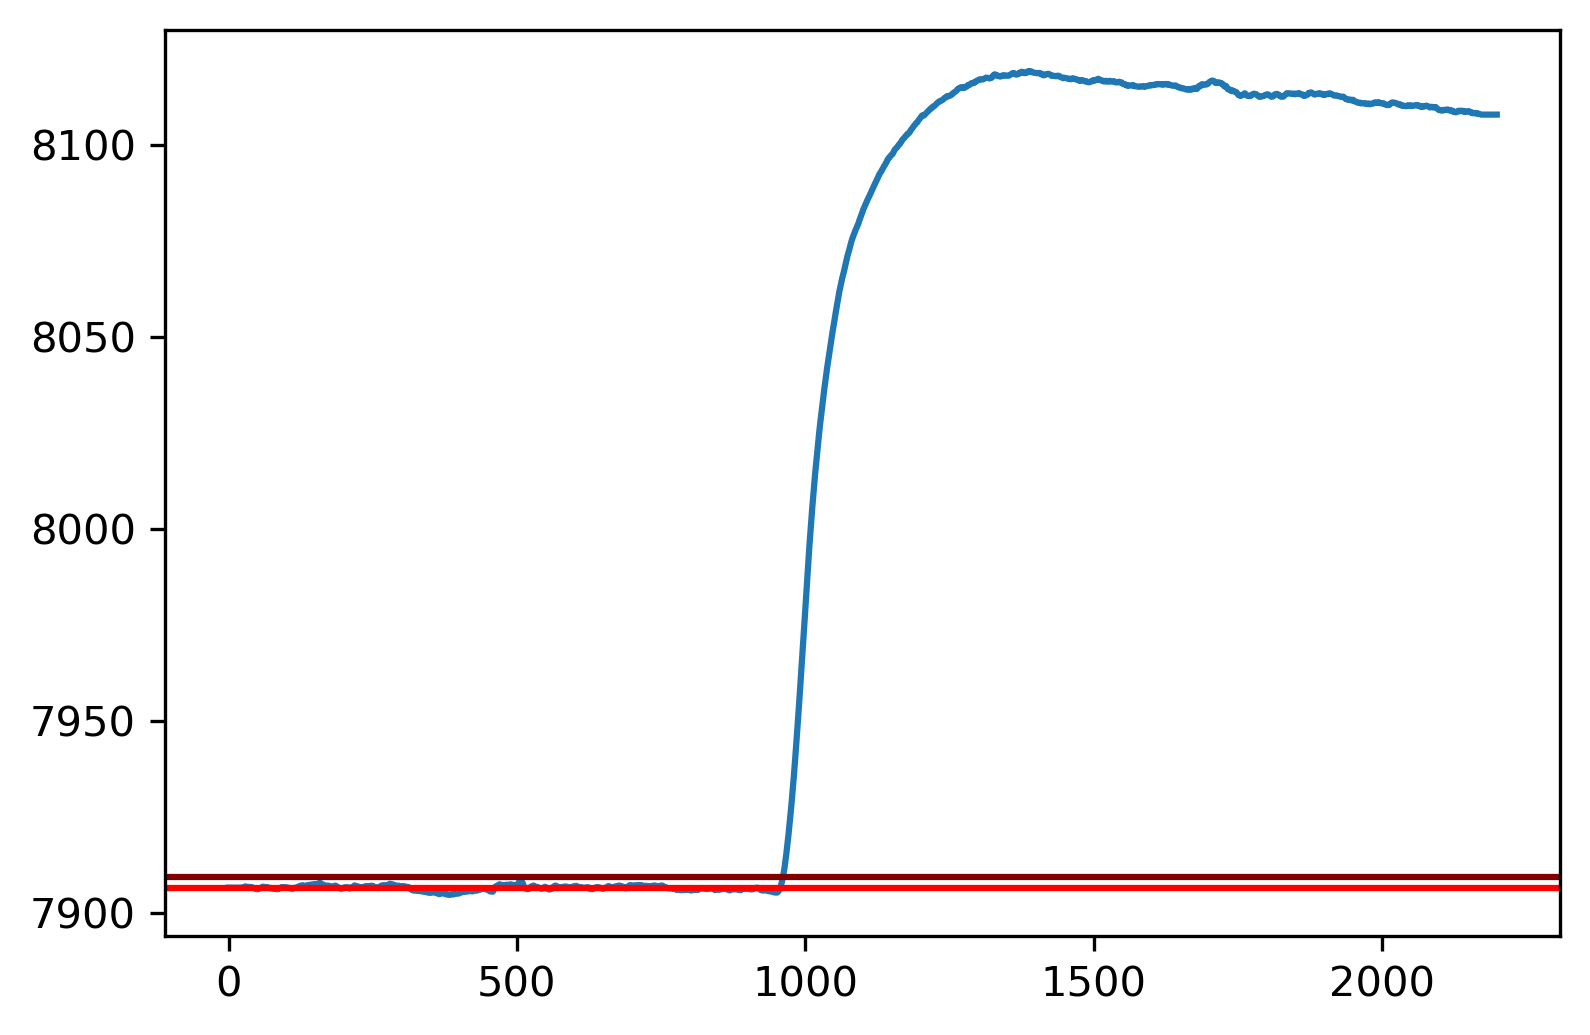

In [530]:
signal = savgol_filter(test_np[1][:2200], 51, 0)
noise_samp = signal[:500]
mean, std = np.mean(noise_samp), np.std(noise_samp)

test_cond = np.where(signal > mean+4*std, signal, 0)

plt.figure(dpi=300)
plt.plot(signal)
plt.axhline(mean, c='r')
plt.axhline(mean+4*std, c='maroon')
plt.show()

In [510]:
conds = []
for i, pulse in enumerate(tqdm(test_np)):
    if i not in sat_i:
        signal = savgol_filter(pulse[:2200], 51, 0)
        noise_samp = signal[:500]
        mean, std = np.mean(noise_samp), np.std(noise_samp)

        test_cond = np.where(signal > mean+8*std, signal, 0)
        conds.append(test_cond)

  0%|          | 0/3162 [00:00<?, ?it/s]

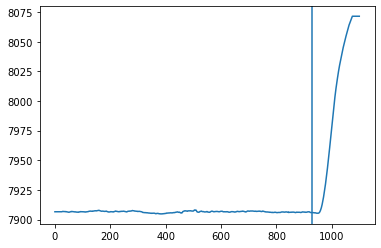

In [531]:
plt.plot(savgol_filter(test_np[1][:1100], 51, 0))
plt.axvline(938-10)

In [572]:
np.gradient(conds[124][:1100])[940:980]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.95494118e+03,
       3.95512745e+03, 3.62745098e-01, 4.41176471e-01, 3.92156863e-01,
       3.72549020e-01, 4.70588235e-01, 4.11764706e-01, 4.80392157e-01,
       5.19607843e-01, 5.09803922e-01, 5.78431373e-01, 5.19607843e-01,
       5.29411765e-01, 5.98039216e-01, 5.68627451e-01, 5.68627451e-01,
       5.68627451e-01, 6.37254902e-01, 6.66666667e-01, 6.56862745e-01,
       7.05882353e-01, 7.15686275e-01, 7.94117647e-01, 8.13725490e-01,
       8.03921569e-01, 8.72549020e-01, 8.82352941e-01, 9.31372549e-01])

In [573]:
np.gradient(conds[124][:1100])[510:530]

array([    0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,  3954.82352941,  3954.82352941,
       -3954.82352941, -3954.82352941,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [656]:
def determine_rise(signal, sigma=8, window=20, offset=15):
    noise_samp = signal[:500]
    mean, std = np.mean(noise_samp), np.std(noise_samp)
    
    grad = np.gradient(np.where(signal > mean+sigma*std, signal, 0))
    
    grad_pos, grad_neg = np.argwhere(grad>2), np.argwhere(grad<-2)
    
    rise_start = 0
    for gp in grad_pos:
        close = False
        for gn in grad_neg:
            if np.abs(gp-gn) < window:
                close = True
        if not close:
            rise_start = gp
            break
    
    return int(rise_start-offset)

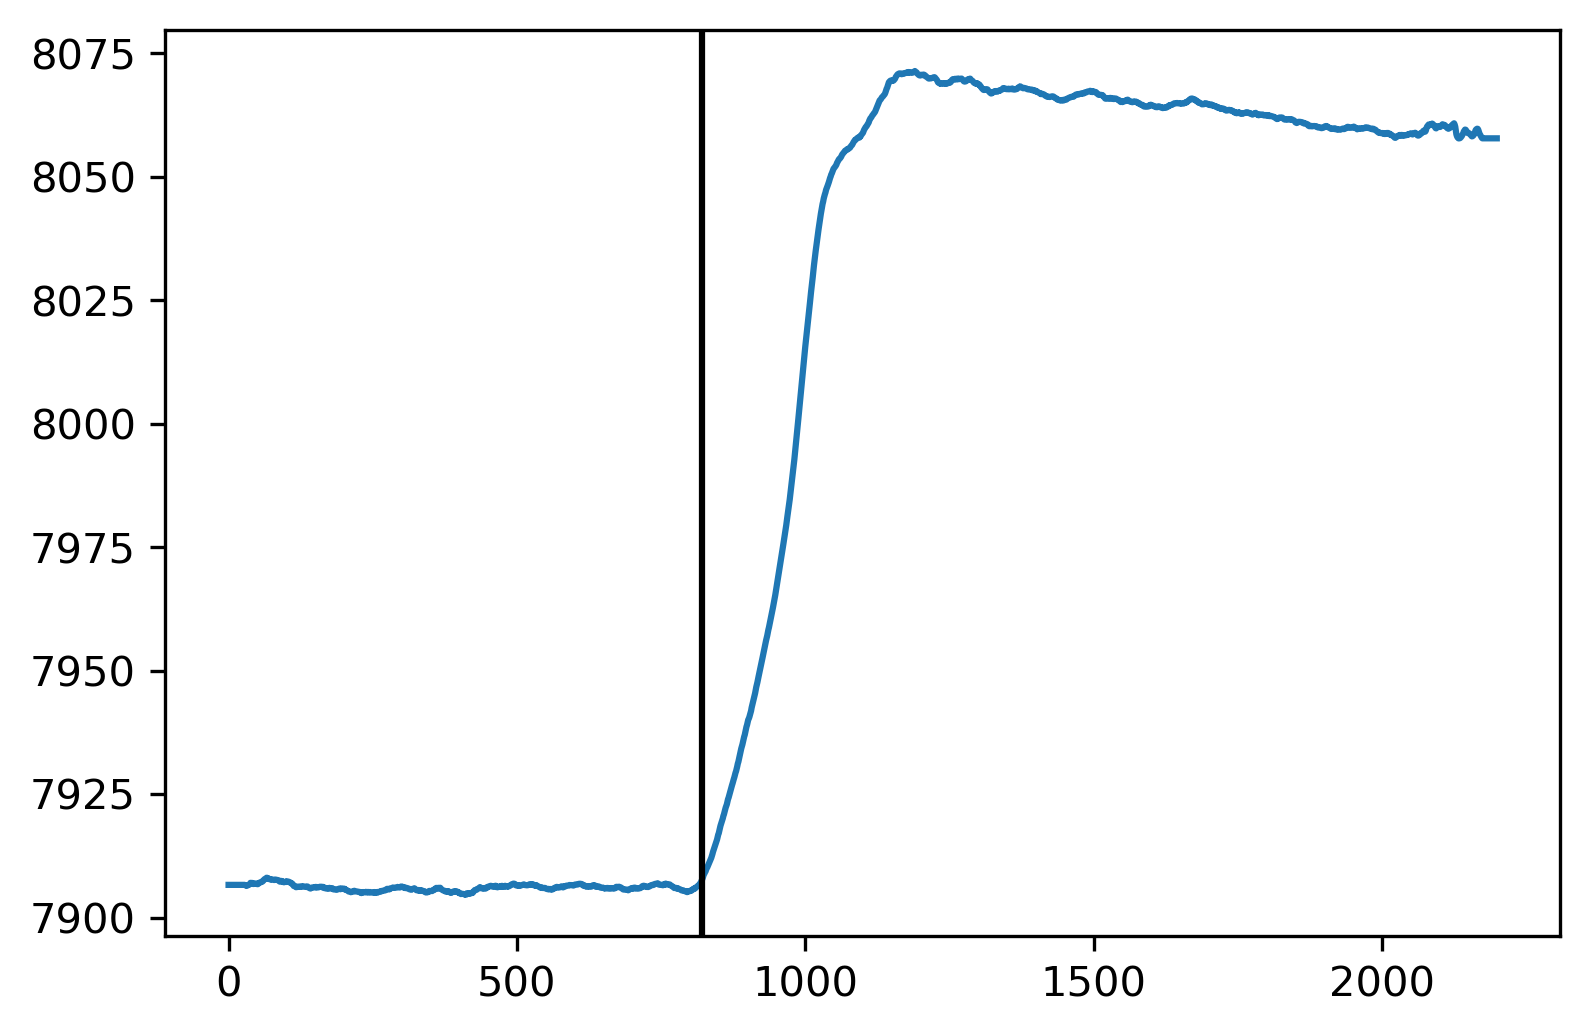

In [654]:
ind = 1684
# ind = 124

signal = savgol_filter(test_np[ind][:2200], 51, 0)
test = determine_rise(signal)

plt.figure(dpi=300)
plt.plot(signal)
plt.axvline(test, c='k')
plt.show()

In [ ]:
plt.plot(np.where(savgol_filter(test_np[124][:1100], 51, 0) )

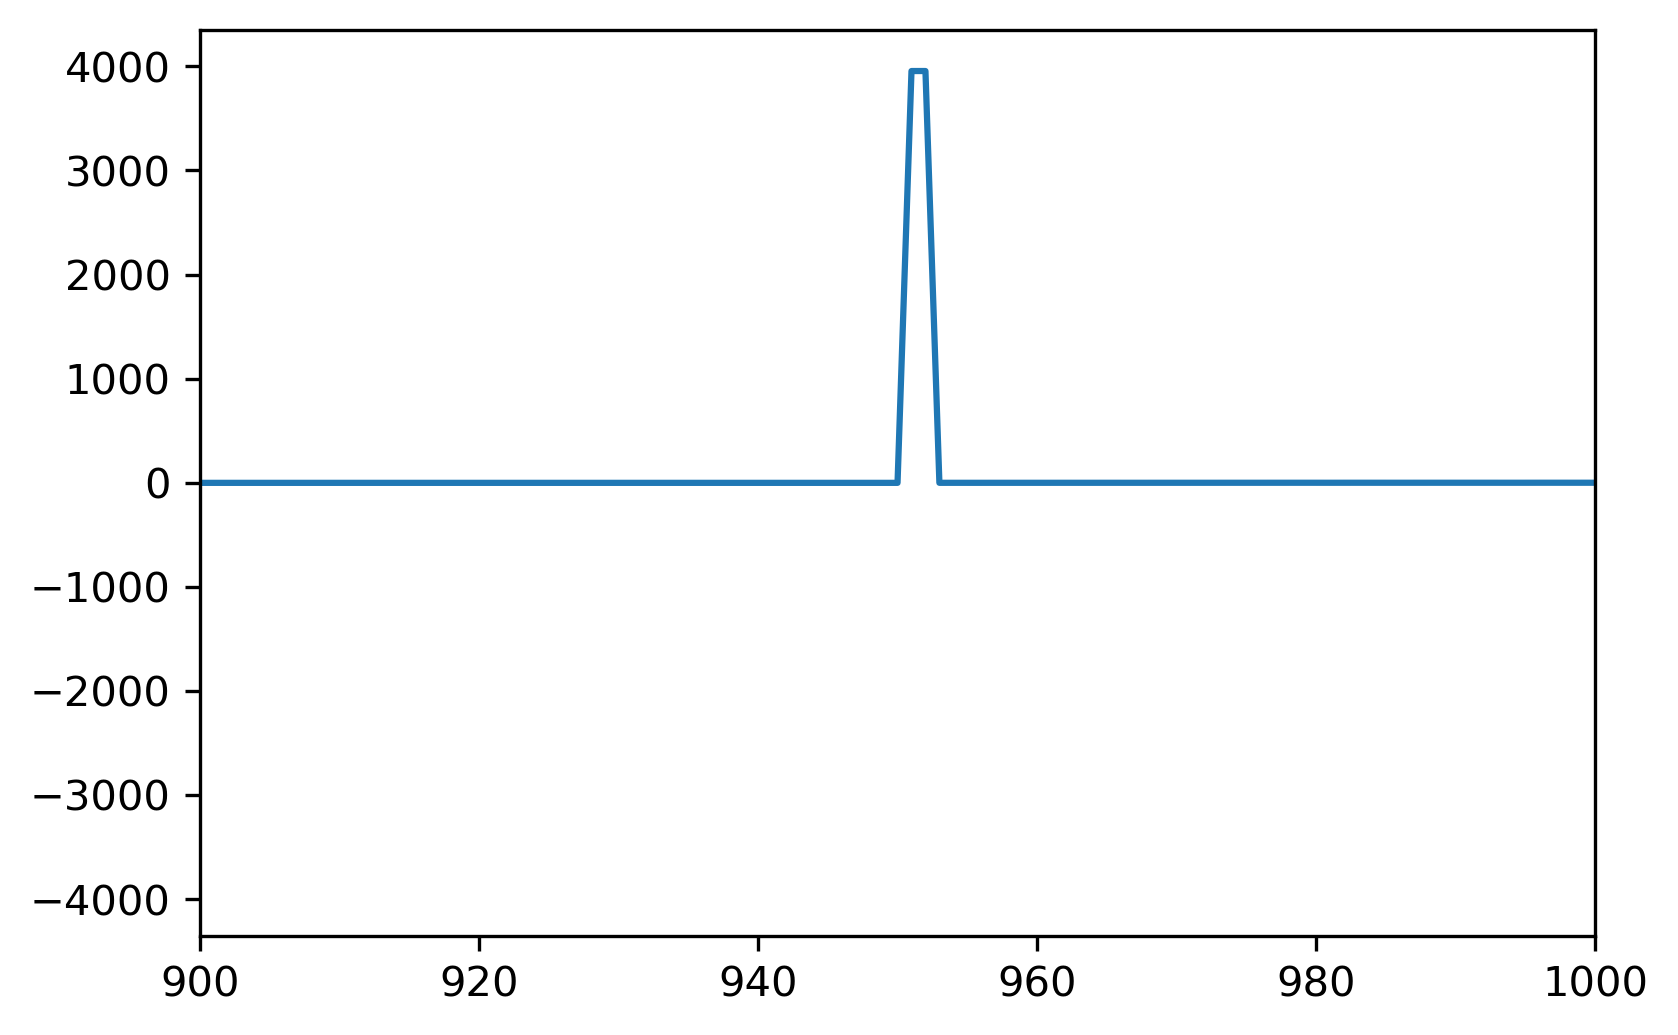

In [570]:
plt.figure(dpi=300)
plt.plot(np.gradient(conds[124][:1100]))
#plt.xlim(510,530)
plt.xlim(900,1000)
plt.show()

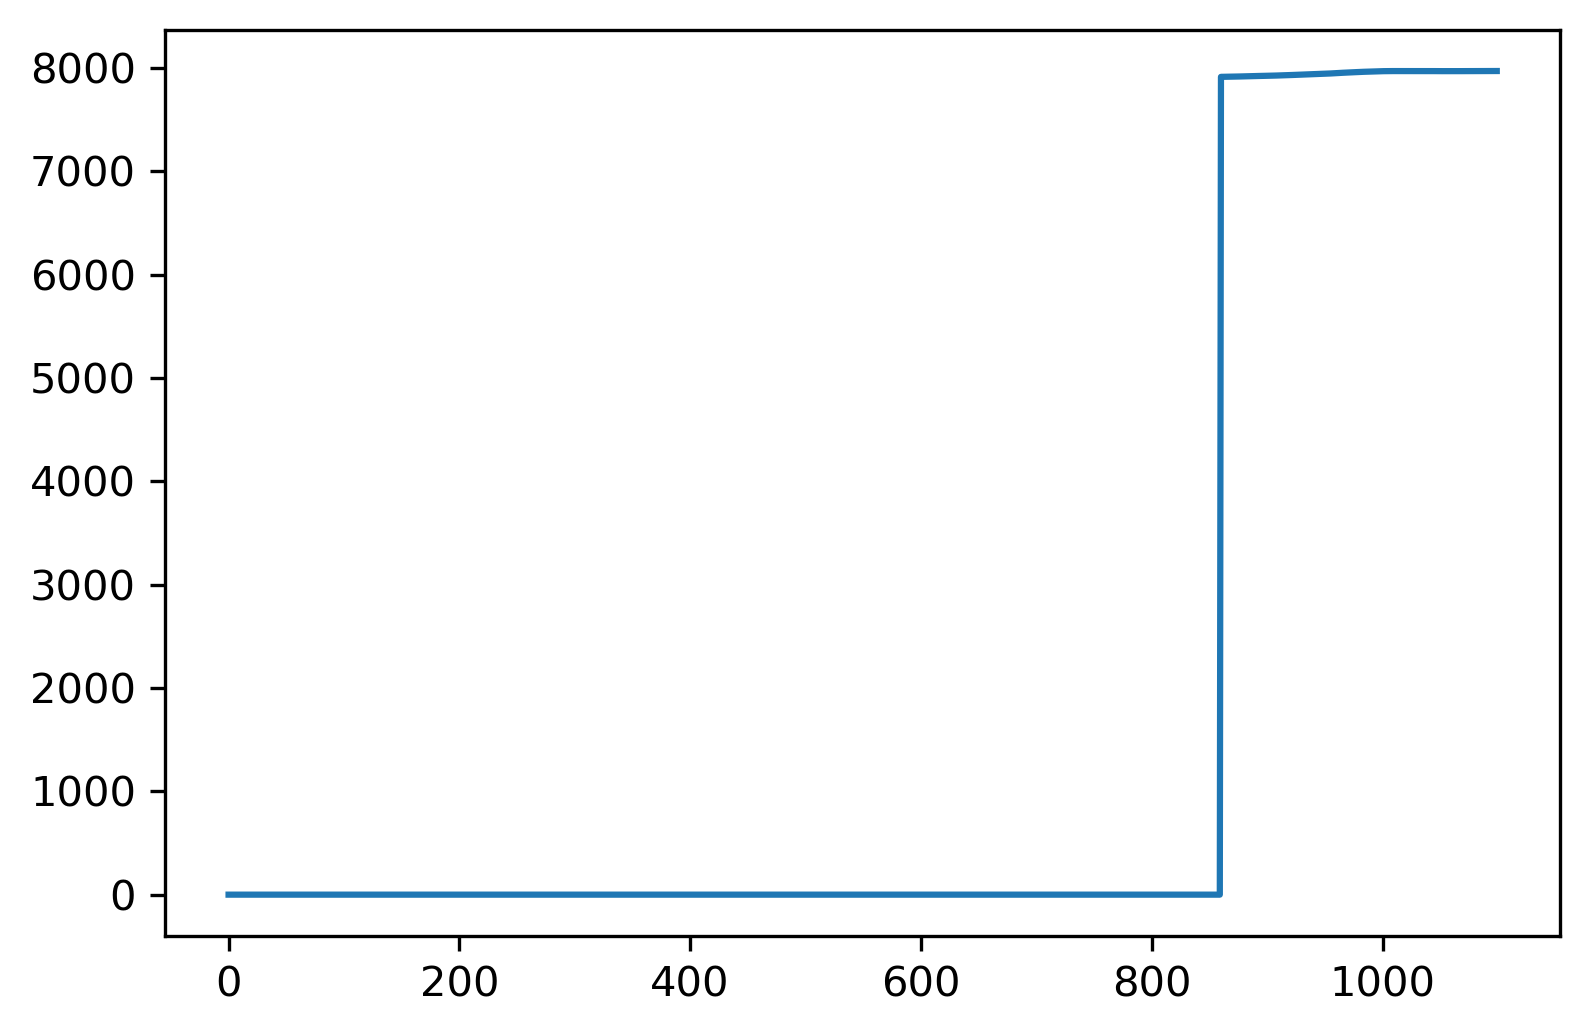

In [516]:
plt.figure(dpi=300)
plt.plot(conds[11][:1100])

In [548]:
len(conds)//8

392

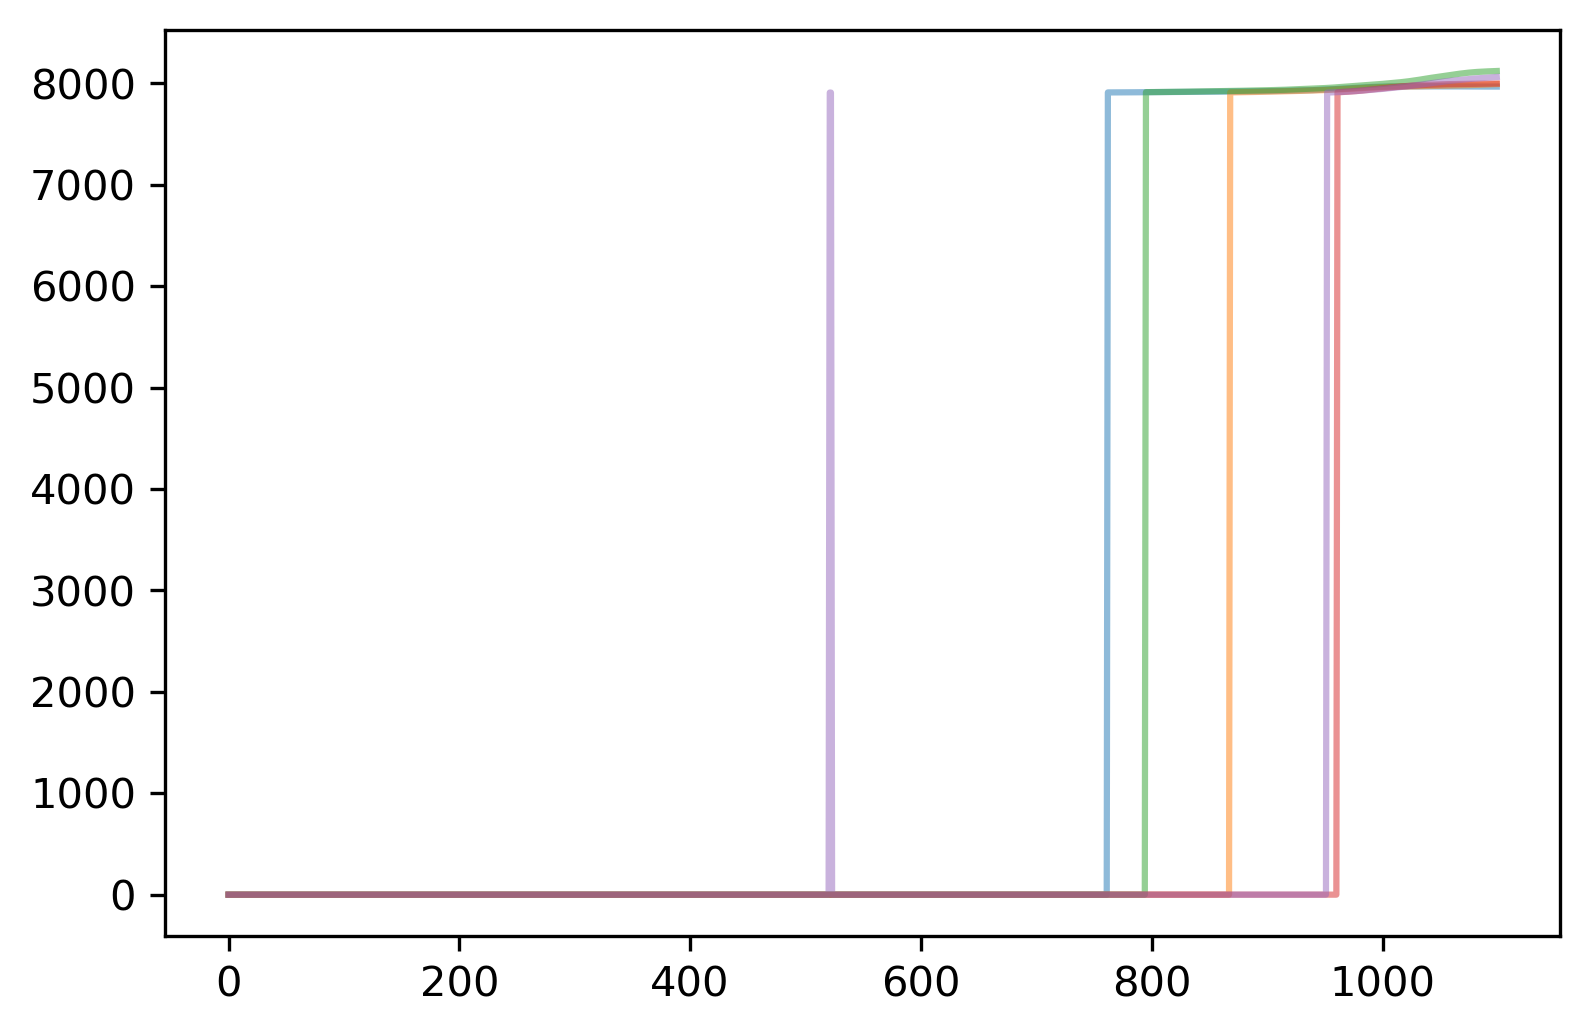

In [559]:
plt.figure(dpi=300)
for cond in range(120,125):
    plt.plot(conds[cond][0:1100], alpha=0.5)
plt.show()

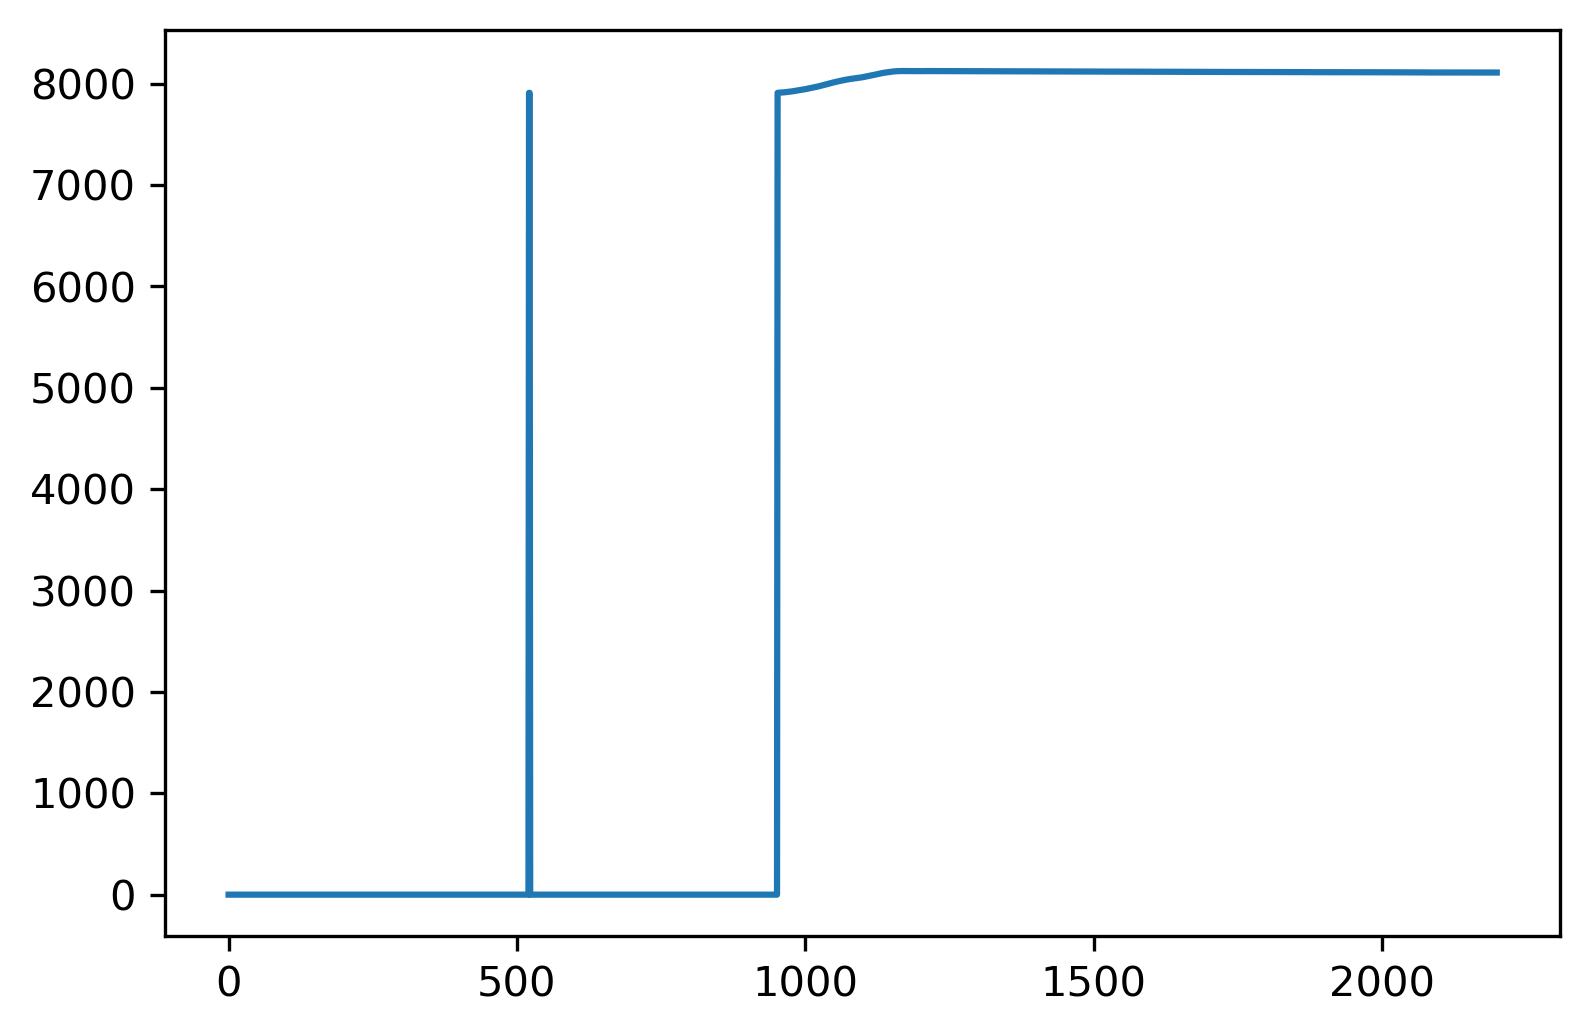

In [564]:
plt.figure(dpi=300)
plt.plot(conds[124])
plt.show()

In [658]:
determine_rise(fs)

943

In [667]:
ra = 51
peak, gap = 369, 300
traps = []
for i, pulse in enumerate(tqdm(test_np)):
    if i not in sat_i:
        fs = savgol_filter(pulse, ra, 0)
    
        trap = s(fs, determine_rise(fs), 15000, peak, gap)
        traps.append(trap)

  0%|          | 0/3162 [00:00<?, ?it/s]

In [664]:
dkl(fs, 943, 369, 669, 1407)

943 369 669 1407


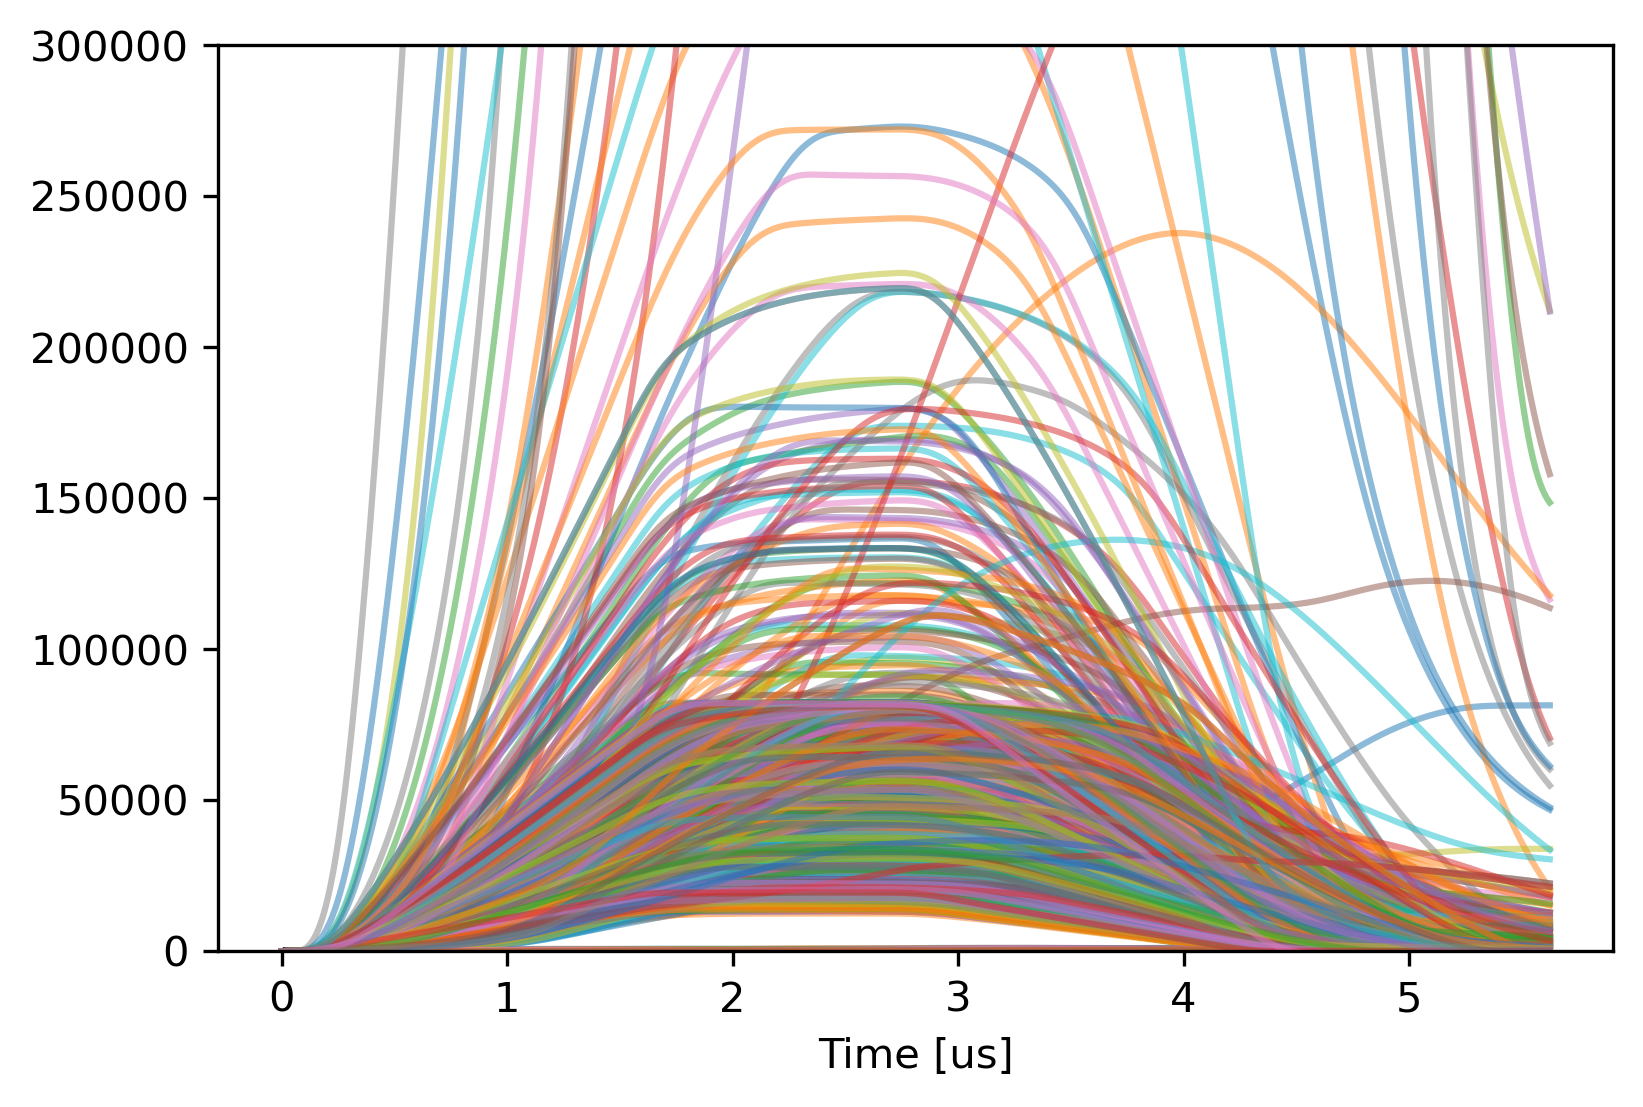

In [678]:
plt.figure(dpi=300)
for trap in traps:
    plt.plot(np.arange(1407)*4e-3, trap, alpha=0.5)
plt.ylim(0,0.3e6)
plt.xlabel("Time [us]")
plt.show()

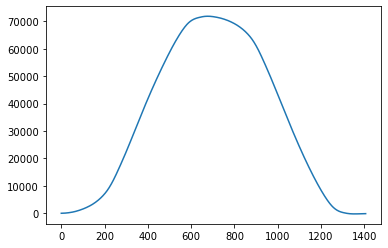

In [683]:
plt.plot(traps[1200])

In [668]:
spectra_mod = []

for trap in traps:
    if max(trap) < 150000:
        spectra_mod.append(max(trap))

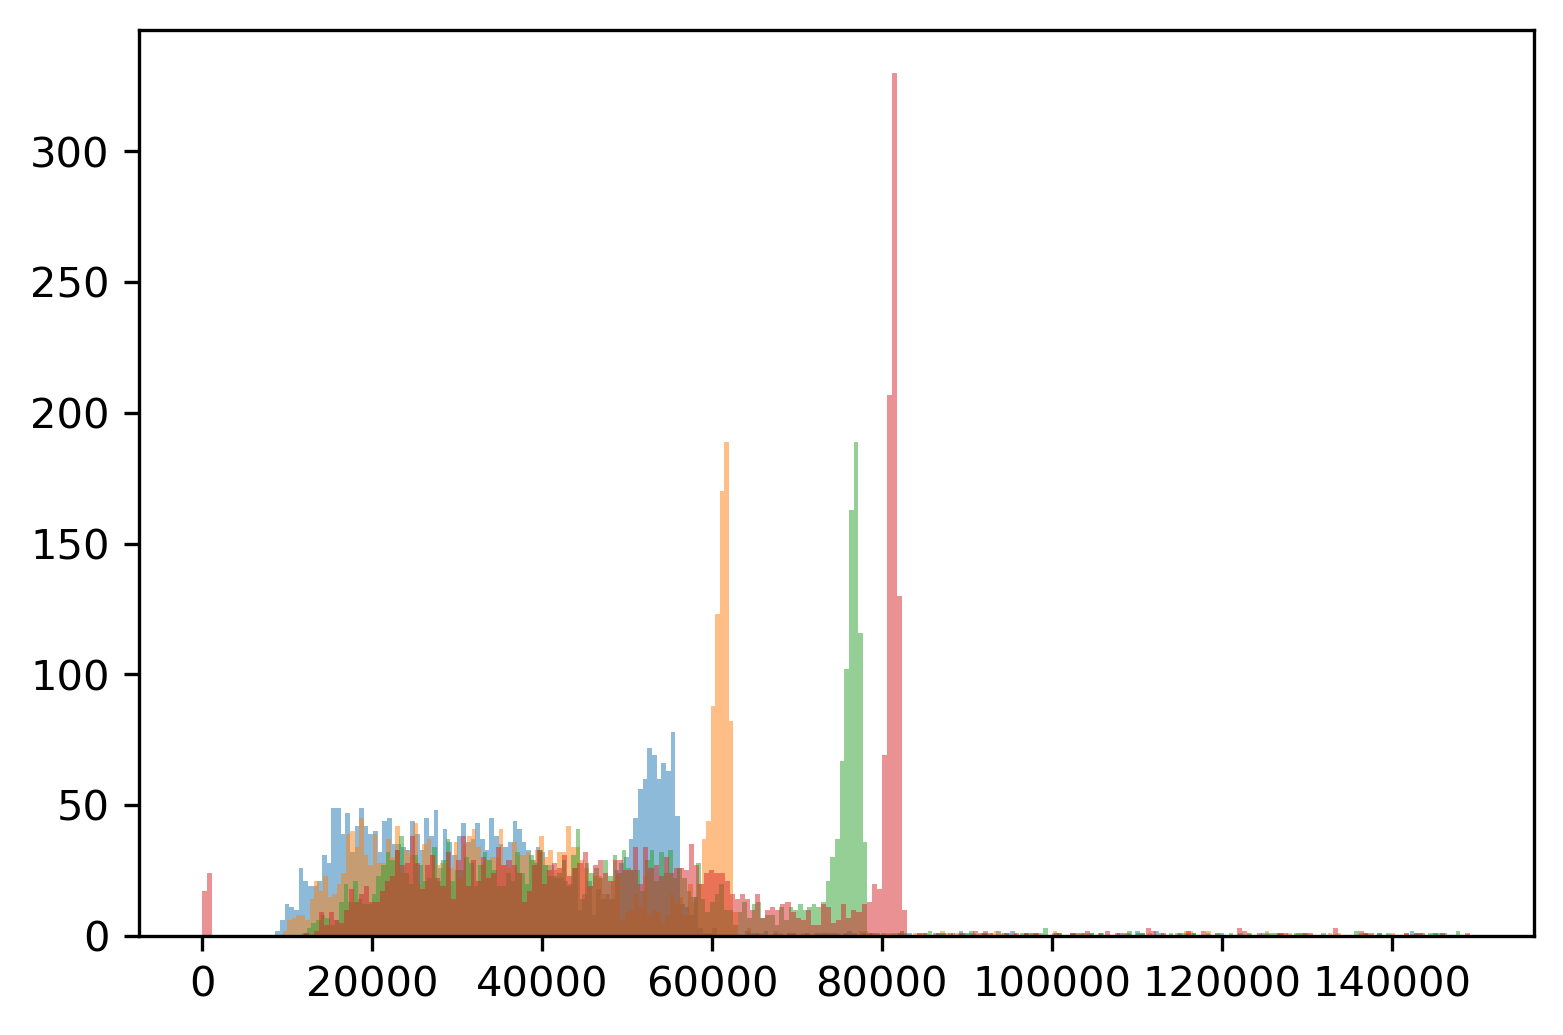

In [669]:
plt.figure(dpi=300)
plt.hist(spectra, bins=250, alpha=0.5, )
plt.hist(spectra2, bins=250, alpha=0.5)
plt.hist(spectra_350, bins=250, alpha=0.5, label='Peaking Time: 350')
plt.hist(spectra_mod, bins=250, alpha=0.5, label='Peaking Time: 369')
plt.show()

In [393]:
ind, ra = 19, 51

ks = []
for i, pulse in enumerate(tqdm(test_np)):
    if i not in sat_i:
        fs = savgol_filter(pulse[:2200], ra, 0)

        gk = get_k(fs)
        
        ks.append(gk[0])

  0%|          | 0/3162 [00:00<?, ?it/s]

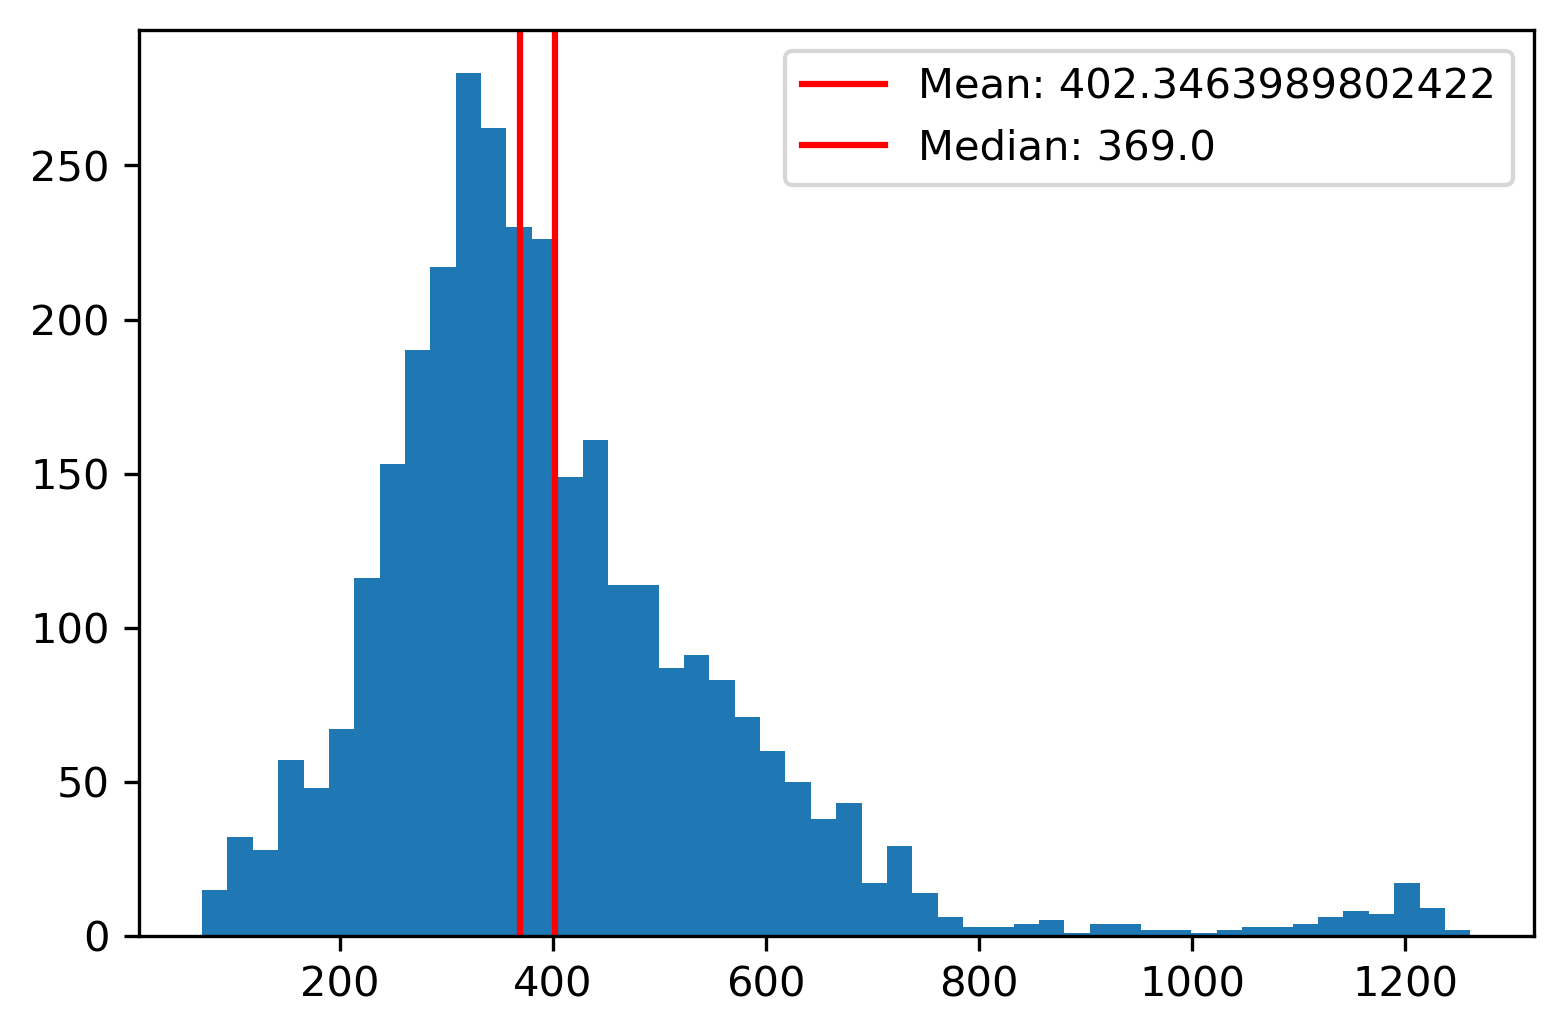

In [463]:
plt.figure(dpi=300)
plt.hist(ks, bins=50)
plt.axvline(np.mean(ks), c='r', label='Mean: {}'.format(np.mean(ks)))
plt.axvline(np.median(ks), c='r', label='Median: {}'.format(np.median(ks)))
plt.legend()
plt.show()

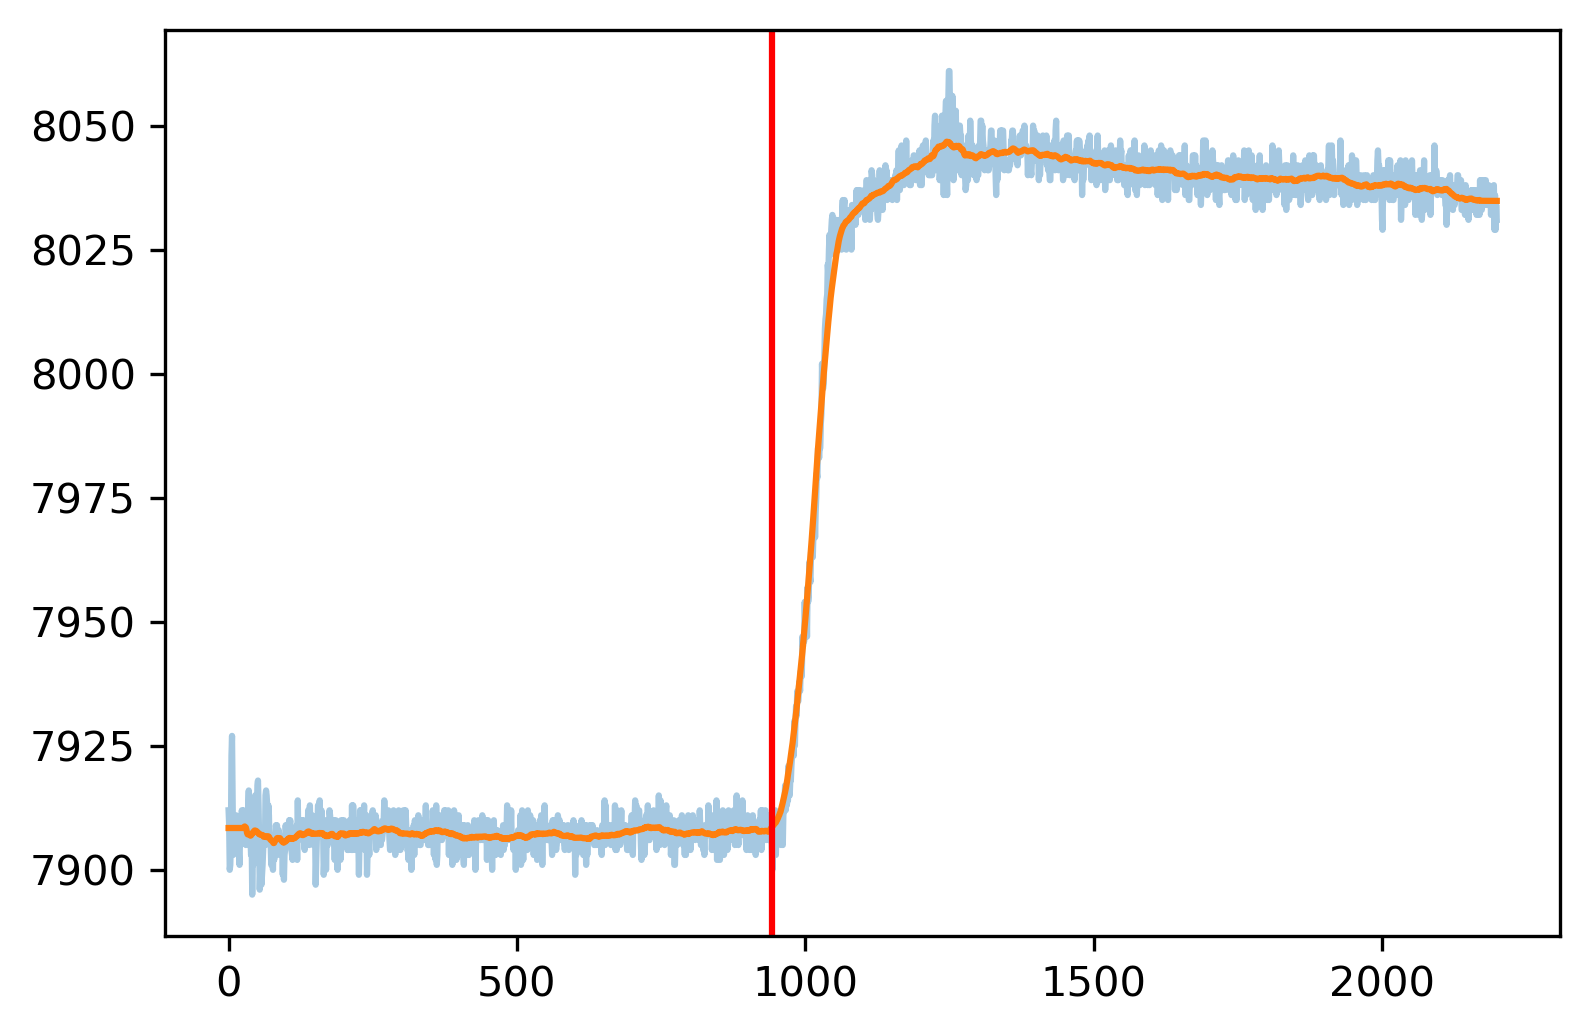

In [676]:
plt.figure(dpi=300)
plt.plot(test_np[0][:2200], alpha=0.4)
plt.plot(savgol_filter(test_np[0][:2200], 51, 0))
plt.axvline(determine_rise(savgol_filter(test_np[0][:2200], 51, 0)), c='r')
plt.show()

In [684]:
369*4e-3

1.476

In [688]:
f = h5py.File('/Users/raptor/Research/python3316/Data/Test-928/Co60-36in-1min_30.h5', 'r')

test_data = pd.DataFrame(f['raw_data'])
test_np = test_data.to_numpy()

sat_i = []
for i in range(len(test_np)):
    if test_np[i][1300] == 16383:
        sat_i.append(i)

print(len(test_np))

10262


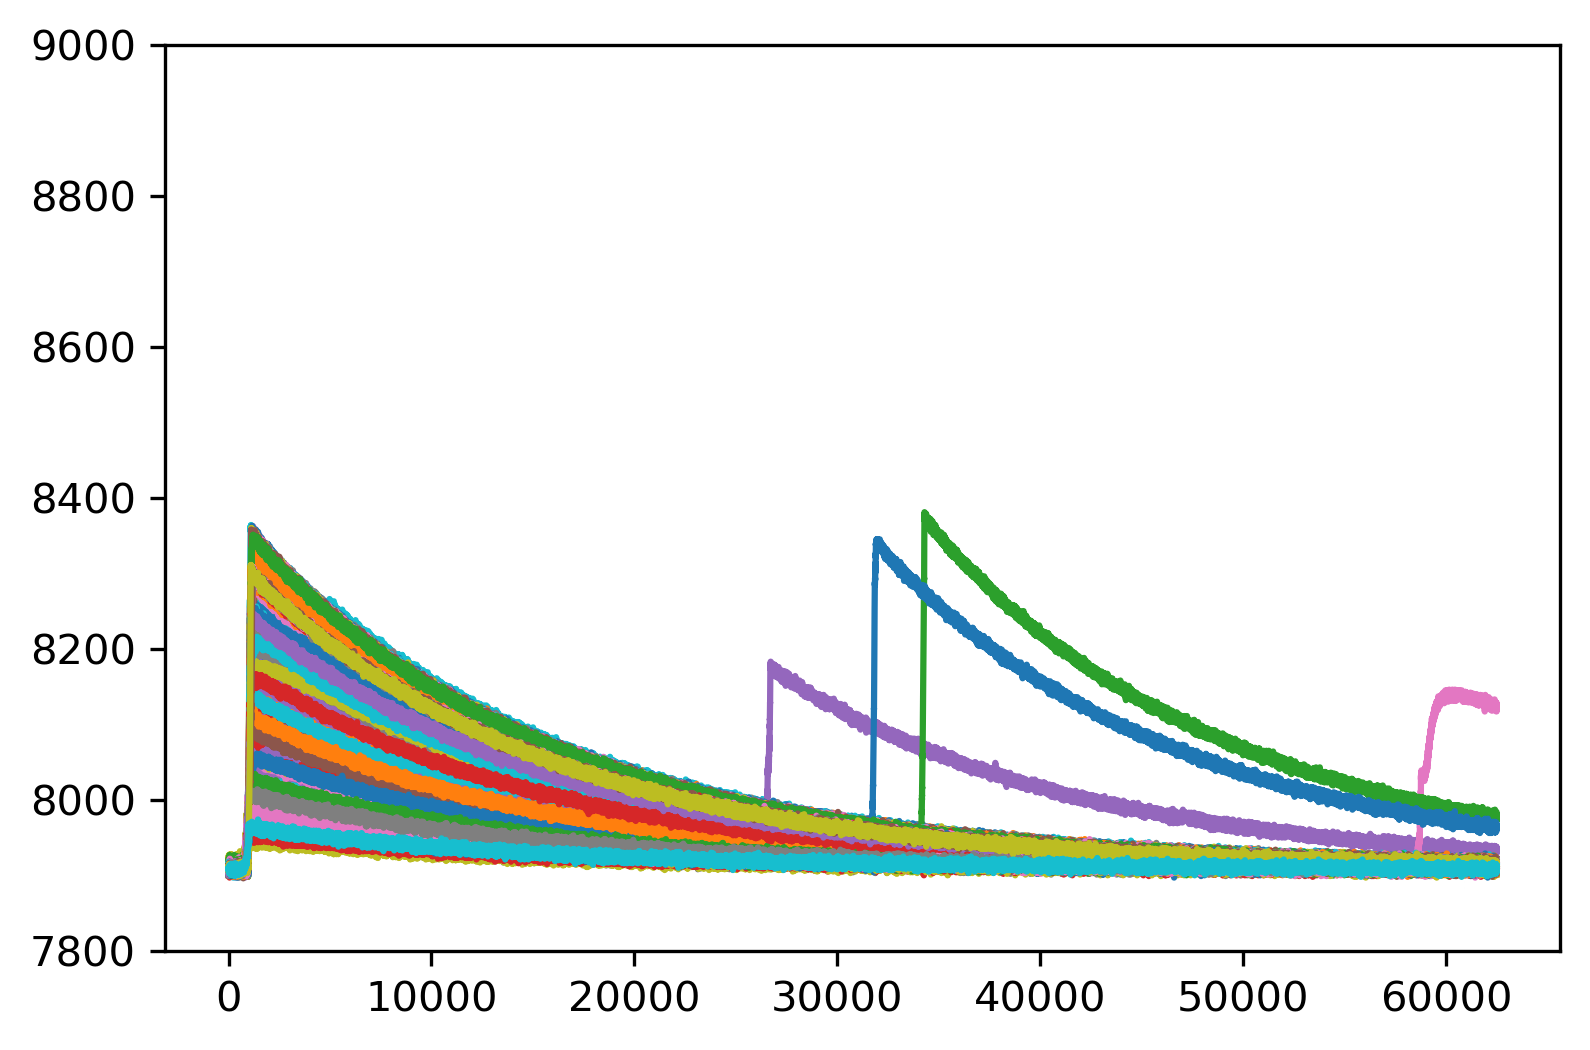

In [689]:
plt.figure(dpi=300)
for i in range(250):
    plt.plot(test_np[i])
plt.ylim(7800, 9000)
plt.show()

In [66]:
trap_files = [[int(f.split('.')[0].split('_')[2][1:]), 'Data/Fit-Data-Old/'+f] for f in os.listdir('Data/Fit-Data-Old/') if f != '.DS_Store' and 'p280' in f]
trap_files.sort()

In [302]:
trap_files

[[0, 'Data/Fit-Data-New/Cs137_p220_g0.npy'],
 [10, 'Data/Fit-Data-New/Cs137_p220_g10.npy'],
 [20, 'Data/Fit-Data-New/Cs137_p220_g20.npy'],
 [30, 'Data/Fit-Data-New/Cs137_p220_g30.npy'],
 [40, 'Data/Fit-Data-New/Cs137_p220_g40.npy'],
 [50, 'Data/Fit-Data-New/Cs137_p220_g50.npy'],
 [60, 'Data/Fit-Data-New/Cs137_p220_g60.npy'],
 [70, 'Data/Fit-Data-New/Cs137_p220_g70.npy'],
 [80, 'Data/Fit-Data-New/Cs137_p220_g80.npy'],
 [90, 'Data/Fit-Data-New/Cs137_p220_g90.npy'],
 [100, 'Data/Fit-Data-New/Cs137_p220_g100.npy'],
 [110, 'Data/Fit-Data-New/Cs137_p220_g110.npy'],
 [120, 'Data/Fit-Data-New/Cs137_p220_g120.npy'],
 [130, 'Data/Fit-Data-New/Cs137_p220_g130.npy'],
 [140, 'Data/Fit-Data-New/Cs137_p220_g140.npy'],
 [150, 'Data/Fit-Data-New/Cs137_p220_g150.npy'],
 [160, 'Data/Fit-Data-New/Cs137_p220_g160.npy'],
 [170, 'Data/Fit-Data-New/Cs137_p220_g170.npy'],
 [180, 'Data/Fit-Data-New/Cs137_p220_g180.npy'],
 [190, 'Data/Fit-Data-New/Cs137_p220_g190.npy'],
 [200, 'Data/Fit-Data-New/Cs137_p220_g200.

In [303]:
peak = 'p220'

trap_files = [[int(f.split('.')[0].split('_')[2][1:]), 'Data/Fit-Data-New/'+f] for f in os.listdir('Data/Fit-Data-New/') if f != '.DS_Store' and peak in f]
trap_files.sort()

cmap = plt.get_cmap('Reds')
colors = cmap(np.linspace(0.2, 1, len(trap_files)))

plt.figure(dpi=300)
for i, tf in enumerate(trap_files):
    f = np.load(tf[1])
    
    lab_l = tf[1].split('.')[0].split('_')
    
    spectra = []
    for j, trap in enumerate(f):
        th = trapezoid_height(trap)
        if not math.isnan(th):
            if th < 365000:
                spectra.append(th)
    
    plt.hist(spectra, bins=500, alpha=0.5, color=colors[i], 
             label='Gap: {}'.format(lab_l[2][1:]))
plt.legend(fontsize=6, loc=2, ncol=4)
plt.xlim(0,9.5e4)
plt.title('Cs137 w/ increasing gap time with set {} peaking time'.format(lab_l[1][1:]))
plt.ylabel('Counts')
plt.xlabel('"Channel"')
plt.savefig('Plots/Cs137_{}_gap-comp_white-new.png'.format(peak), bbox_inches='tight', facecolor='white', dpi=300)
plt.show()

KeyboardInterrupt: 

In [74]:
test = np.load(trap_files[0][1])

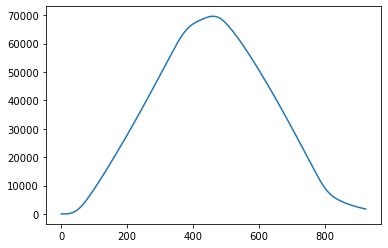

In [80]:
plt.plot(test[3])

In [76]:
test[0]

array([0.00000000e+00, 5.76470588e+00, 1.15101882e+01, 1.73344850e+01,
       2.29826994e+01, 2.88077610e+01, 3.48881129e+01, 4.08904388e+01,
       4.68147335e+01, 5.29355015e+01, 5.90566776e+01, 6.51586539e+01,
       7.13982920e+01, 7.77167773e+01, 8.39376447e+01, 9.02569661e+01,
       9.66355322e+01, 1.03210602e+02, 1.09805718e+02, 1.16440489e+02,
       1.23095311e+02, 1.29711360e+02, 1.36347459e+02, 1.43121255e+02,
       1.49934718e+02, 1.56827066e+02, 1.63876737e+02, 1.71064133e+02,
       1.78232400e+02, 1.85303105e+02, 1.92413498e+02, 1.99622404e+02,
       2.06910222e+02, 2.14433820e+02, 2.21957919e+02, 2.29541344e+02,
       2.37066451e+02, 2.44807745e+02, 2.52608380e+02, 2.60487965e+02,
       2.68681802e+02, 2.77072263e+02, 2.85659362e+02, 2.94698014e+02,
       3.04050994e+02, 3.13561460e+02, 3.23307854e+02, 3.33074506e+02,
       3.43253574e+02, 3.53727438e+02, 3.64319647e+02, 3.74932170e+02,
       3.85800303e+02, 3.96845631e+02, 4.07911303e+02, 4.18997320e+02,
      

In [ ]:
popt, pcov = curve_fit(trapezoid, xdata, ydata, method = 'lm')

In [205]:
def determine_rise(signal, sigma=8, window=20, offset=15):
    noise_samp = signal[:500]
    mean, std = np.mean(noise_samp), np.std(noise_samp)
    
    grad = np.gradient(np.where(signal > mean+sigma*std, signal, 0))
    
    grad_pos, grad_neg = np.argwhere(grad>2), np.argwhere(grad<-2)
    
    rise_start = 0
    for gp in grad_pos:
        close = False
        for gn in grad_neg:
            if gn-gp < window and gn-gp > 0:
                close = True
        if not close:
            rise_start = gp
            break
    
    return int(rise_start-offset)

In [207]:
f = h5py.File('Data/Test-923/Cs137-1min.h5')

test_data = pd.DataFrame(f['raw_data'])
test_np = test_data.to_numpy()

sat_i = []
for i in range(len(test_np)):
    if test_np[i][1300] == 16383:
        sat_i.append(i)

print(len(test_np))

3162


In [208]:
rts = []
for i, pulse in enumerate(tqdm(test_np)):
    fs = savgol_filter(pulse, 51, 0)
    
    rts.append(determine_rise(fs))

  0%|          | 0/3162 [00:00<?, ?it/s]

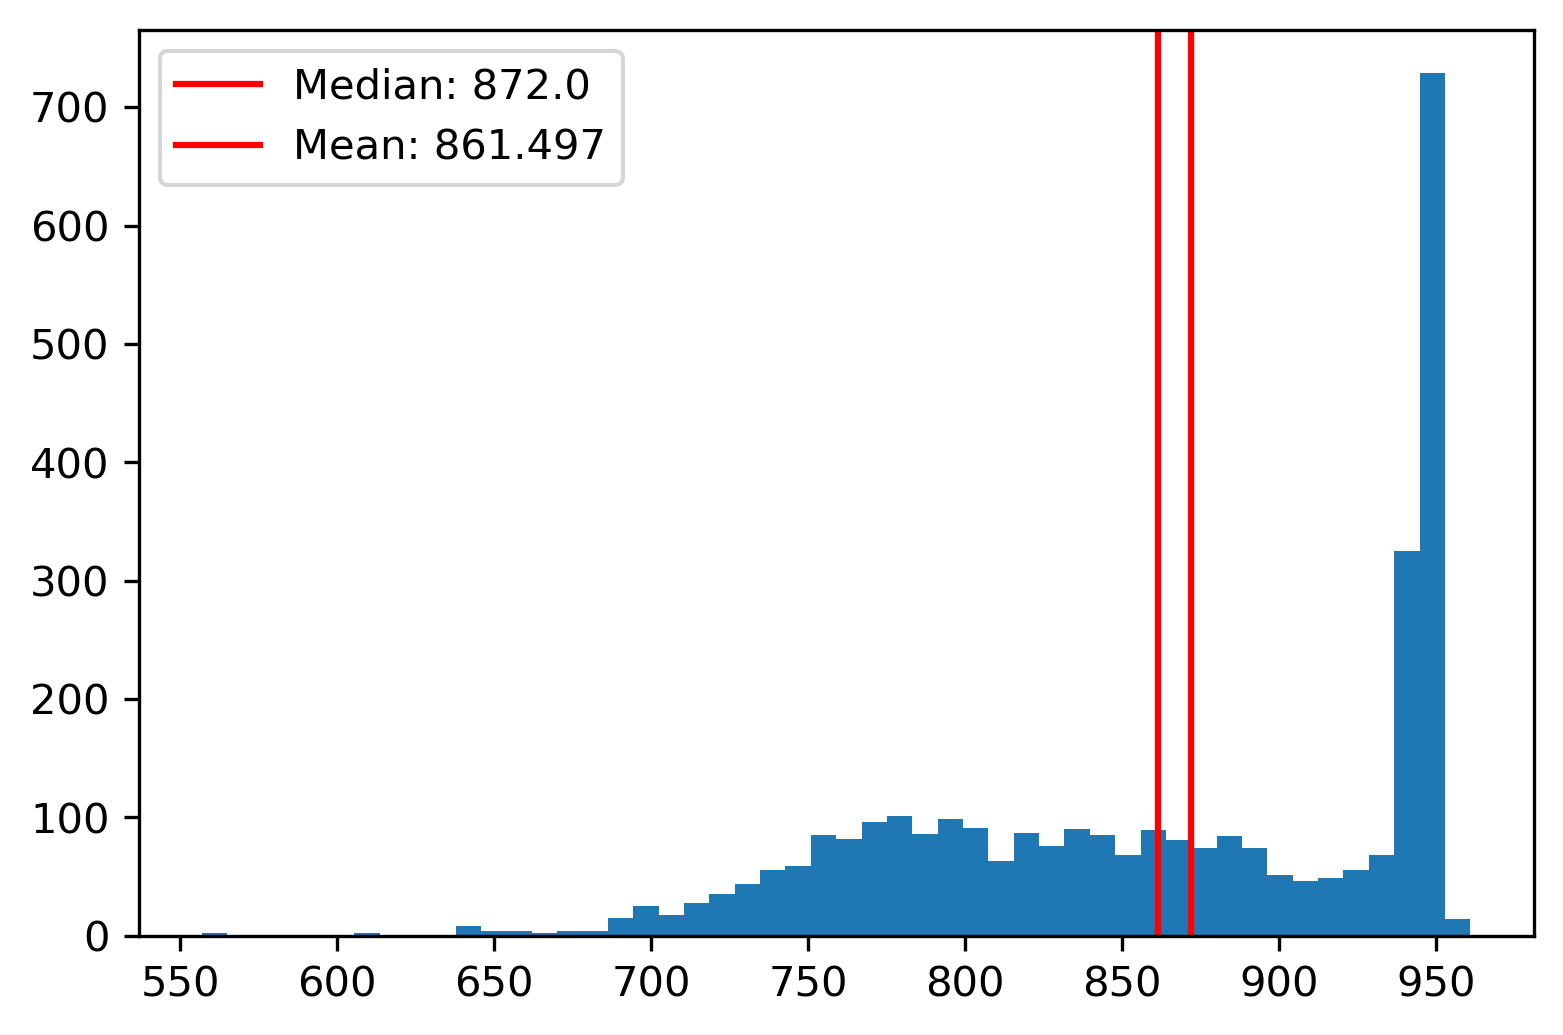

In [211]:
plt.figure(dpi=300)
plt.hist(rts, bins=50)
plt.axvline(np.median(rts), c='r', label='Median: {}'.format(round(np.median(rts), 3)))
plt.axvline(np.mean(rts), c='r', label='Mean: {}'.format(round(np.mean(rts), 3)))
plt.legend()
#plt.xlim(500, 1200)
plt.show()

In [92]:
max(rts)

55749

In [162]:
fs = savgol_filter(test_np[81], 51, 0)

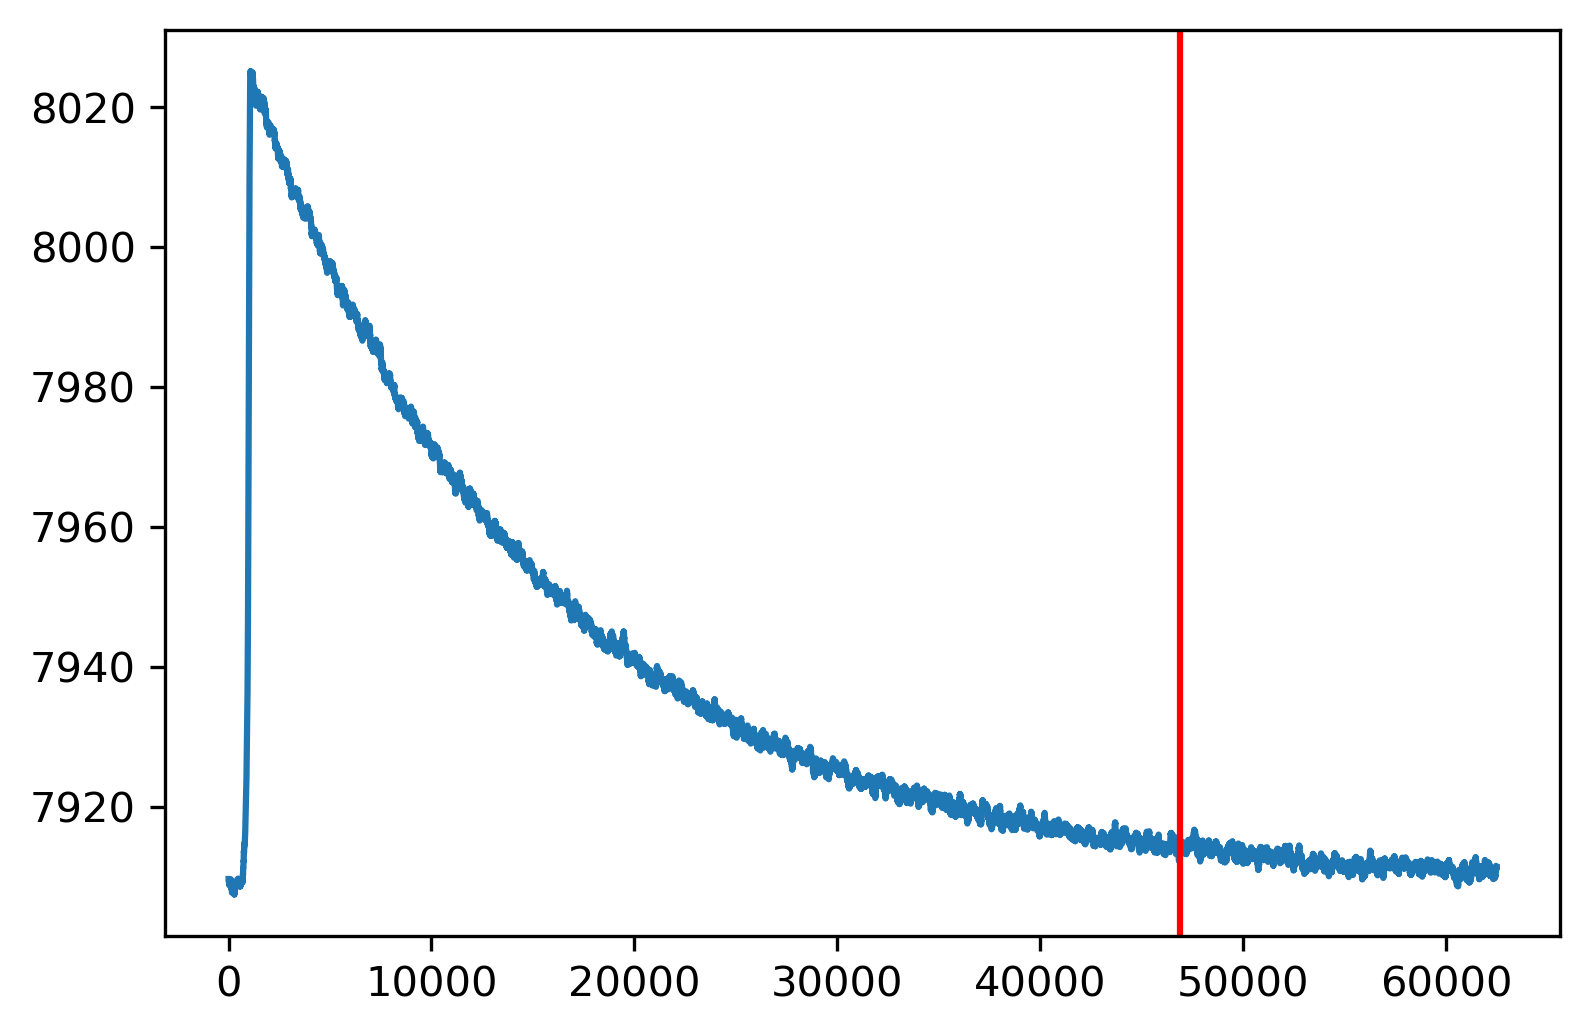

In [165]:
plt.figure(dpi=300)
plt.plot(fs)
plt.axvline(determine_rise(fs)[4], c='r')
#plt.xlim(0,2200)
plt.show()

In [328]:
f = h5py.File('Data/Test-923/Cs137-1min.h5', 'r')
#f = h5py.File('/Users/raptor/Research/python3316/Data/Test-928/Cs137-24in-1min_5.h5')

test_data = pd.DataFrame(f['raw_data'])
test_np = test_data.to_numpy()

sat_i = []
for i in range(len(test_np)):
    if test_np[i][1300] == 16383:
        sat_i.append(i)

print(len(test_np))

3162


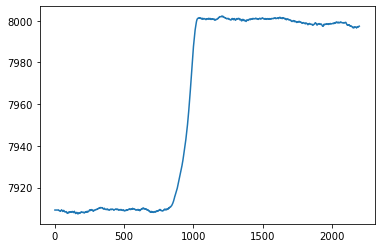

In [134]:
plt.plot(fs[:2200])

In [195]:
fs = savgol_filter(test_np[81], 51, 0)
#fs = savgol_filter(test_np[124], 51, 0)

In [196]:
mean_test, std_test, grad_test, where_test, val = determine_rise(fs)

In [197]:
grad_pos, grad_neg = np.argwhere(grad_test>2), np.argwhere(grad_test<-2)

In [198]:
grad_pos[:4]

array([[750],
       [751],
       [761],
       [762]])

In [199]:
grad_neg[:4]

array([[  759],
       [  760],
       [45768],
       [46076]])

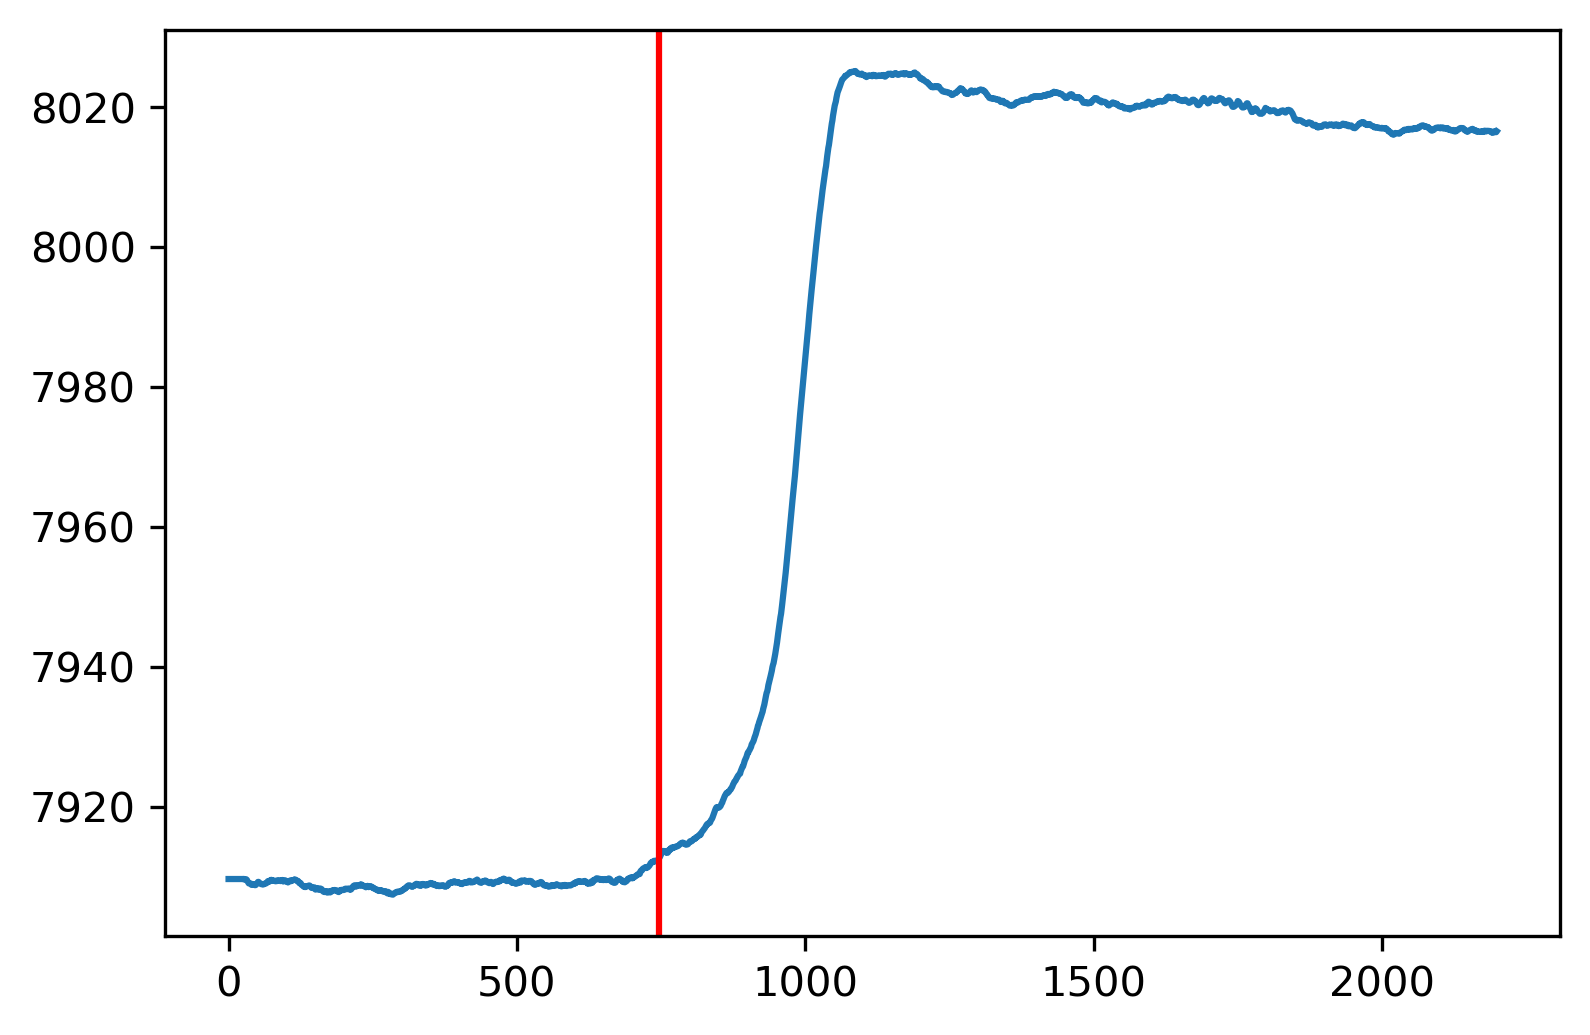

In [204]:
plt.figure(dpi=300)
plt.plot(fs[:2200])
plt.axvline(val, c='r')
plt.show()

(700.0, 800.0)

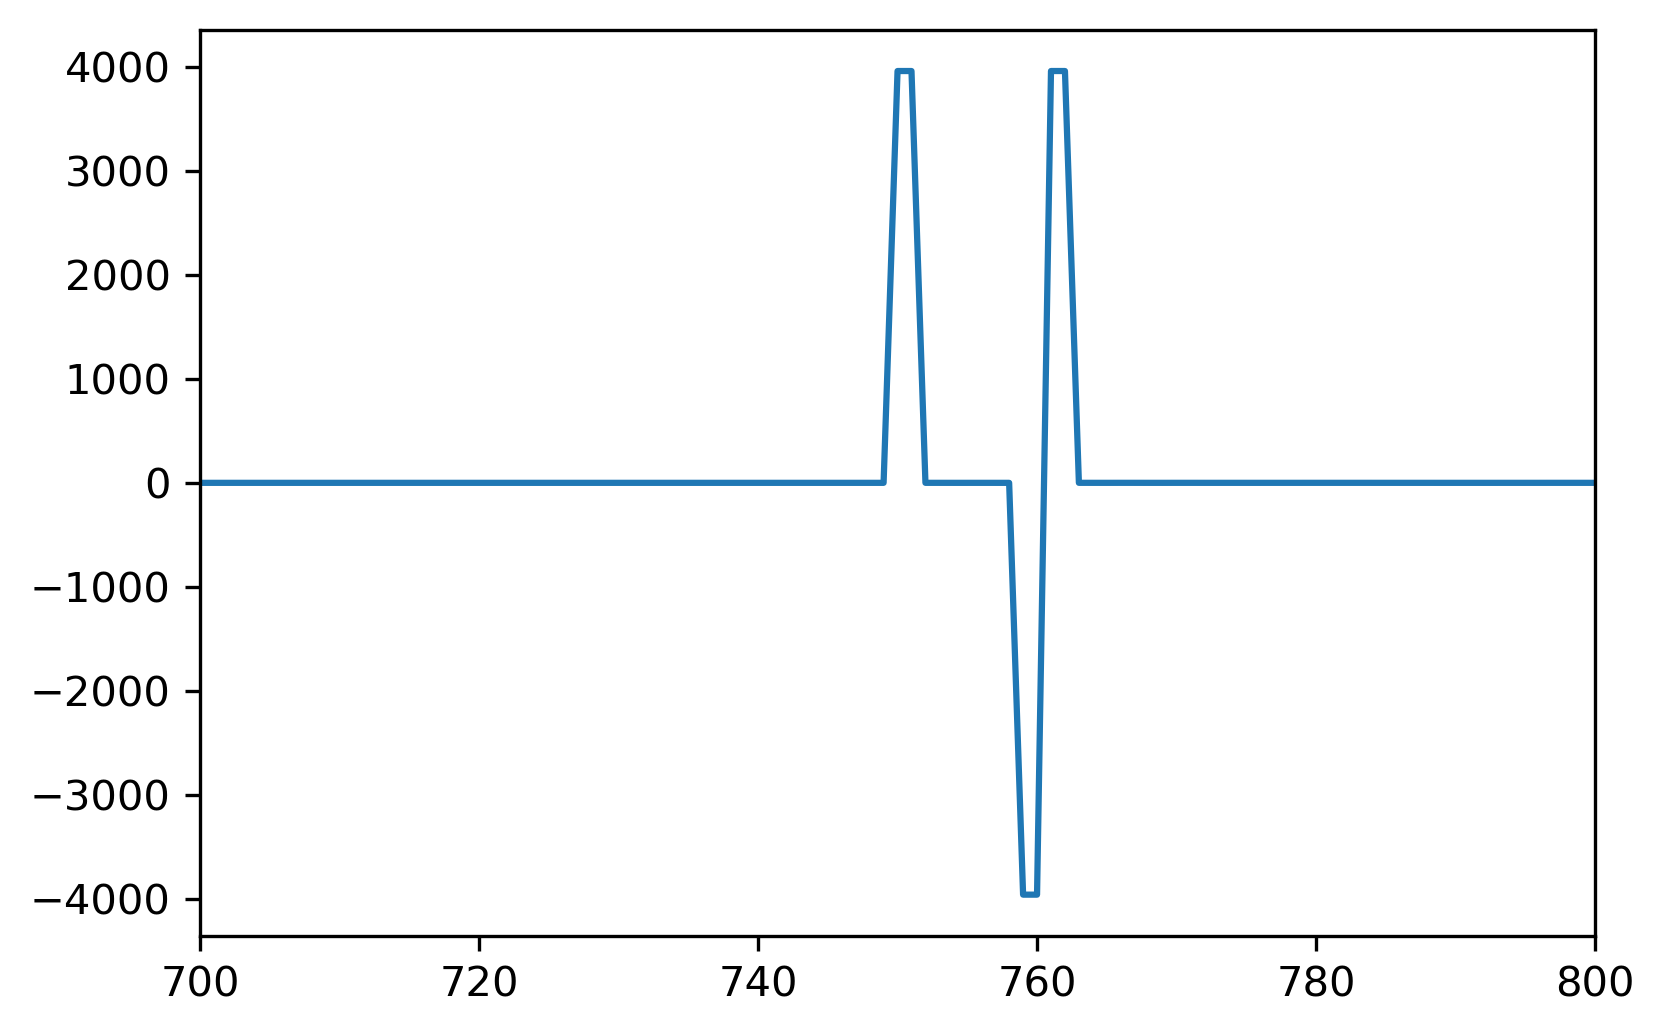

In [200]:
plt.figure(dpi=300)
plt.plot(grad_test[:2200])
plt.xlim(700,800)

In [213]:
test_np

array([[7912, 7909, 7900, ..., 7909, 7907, 7910],
       [7905, 7901, 7903, ..., 7908, 7908, 7912],
       [7905, 7908, 7905, ..., 7902, 7911, 7902],
       ...,
       [7904, 7909, 7908, ..., 7905, 7907, 7911],
       [7905, 7913, 7905, ..., 7906, 7907, 7910],
       [7903, 7907, 7903, ..., 7913, 7910, 7907]], dtype=uint16)

In [2]:
def determine_rise(signal, sigma=8, window=20, offset=15):
    noise_samp = signal[:500]
    mean, std = np.mean(noise_samp), np.std(noise_samp)
    
    grad = np.gradient(np.where(signal > mean+sigma*std, signal, 0))
    
    grad_pos, grad_neg = np.argwhere(grad>2), np.argwhere(grad<-2)
    
    rise_start = 0
    for gp in grad_pos:
        close = False
        for gn in grad_neg:
            if gn-gp < window and gn-gp > 0:
                close = True
        if not close:
            rise_start = gp
            break
    
    return int(rise_start-offset)

def delay_signal(signal, delay=2000, w=500, seed=69):
    np.random.seed(seed)
    noise_samp = signal[:w]
    mean, std = np.mean(noise_samp), np.std(noise_samp)
    noise = np.random.normal(mean, 0.9*std, delay)
    return np.hstack([noise, signal])

def dkl(signal, i, k, l, w):
    signal = delay_signal(signal, delay=w)
    vj = signal[i+w:i+w+w]
    vjk = signal[i-k+w:i+w+w-k]
    vjl = signal[i-l+w:i+w+w-l]
    vjkl = signal[i-k-l+w:i+w+w-k-l]
    return vj - vjk - vjl + vjkl
    
def s(signal, start_rise, tau, peaking_time, gap_time, w=0):
    if w == 0:
        w = int(round(2.5*peaking_time+gap_time, 0))
    ss = []
    dkl_s = dkl(signal, start_rise, peaking_time, peaking_time+gap_time, w)
    for j in range(w):
        if j == 0:
            ss.append(0)
        else:
            ss.append(ss[j-1]*(1+1/tau)+ dkl_s[j])
    return np.array(ss)

In [330]:
p, g = 646, 500
ra = 51
traps = []
for i, pulse in enumerate(tqdm(test_np, desc="Peak = {}, Gap = {}".format(p, g), leave=False)):
    fs = savgol_filter(pulse, ra, 0)

    #trap = s(fs, determine_rise(fs), 15000, p, g)
    trap = s(fs, determine_rise(fs), 14968, p, g)
    traps.append(trap)
trap_np = np.concatenate(traps).reshape(len(traps), len(traps[0]))

Peak = 646, Gap = 500:   0%|          | 0/3162 [00:00<?, ?it/s]

In [226]:
def trapezoid(x, a, b, c, tau1, tau2):
    y = np.zeros(len(x))
    c = -np.abs(c)
    a = np.abs(a)
    (tau1,tau2) = (min(tau1,tau2),max(tau1,tau2))
    y[:int(tau1)] =  a*x[:int(tau1)] + b
    y[int(tau1):int(tau2)] =  a*tau1 + b 
    y[int(tau2):] = c*(x[int(tau2):]-tau2) + (a*tau1 + b)
    return y

In [227]:
ind = 51
popt, pcov = curve_fit(trapezoid, np.arange(len(trap_np[ind])), trap_np[ind], method = 'lm')

[   62.19357758 -3707.89259189    53.46802534   733.75049824
  1161.23008151]


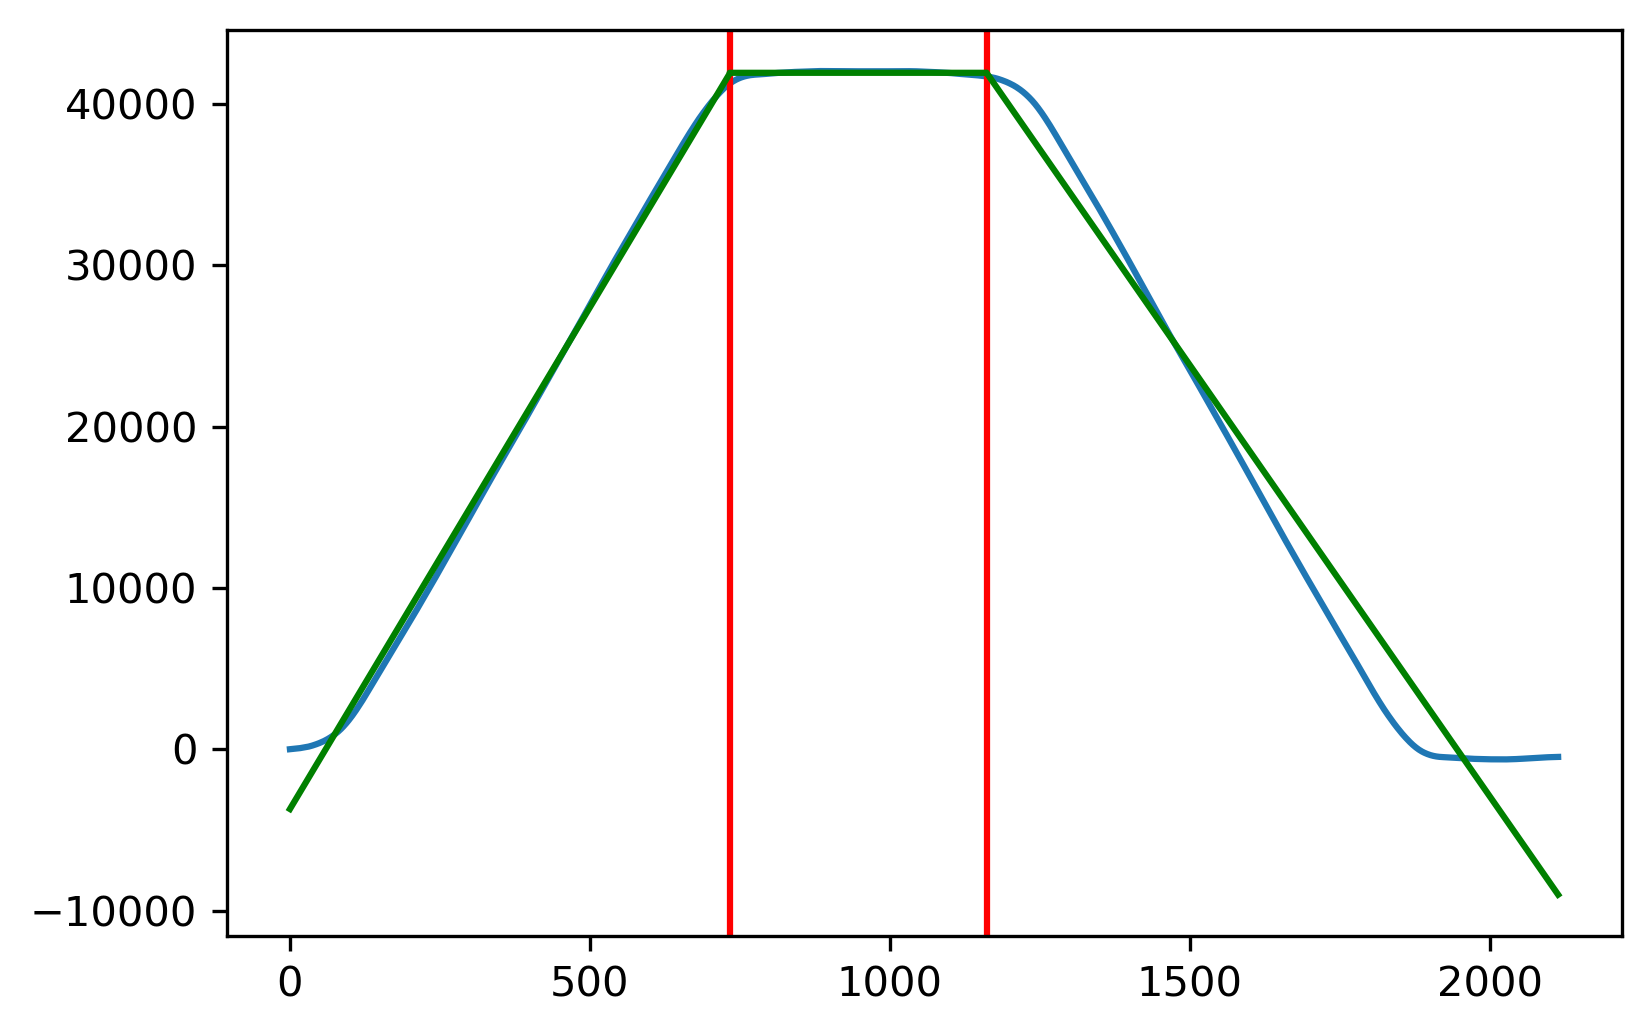

In [331]:
#ind = 1004
ind = 3
popt, pcov = curve_fit(trapezoid, np.arange(len(trap_np[ind])), trap_np[ind], method = 'lm',
                      p0=[200, -8000, 200, 400, 800])

print(popt)
plt.figure(dpi=300)
plt.plot(trap_np[ind])
plt.axvline(popt[3], c='r')
plt.axvline(popt[4], c='r')
plt.plot(trapezoid(np.arange(len(trap_np[ind])), *popt), c='g')
plt.show()

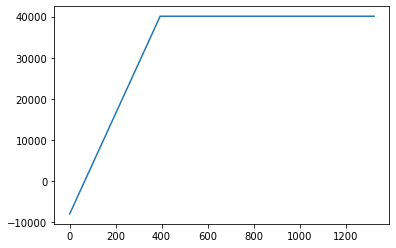

In [238]:
plt.plot(trapezoid(np.arange(len(trap_np[ind])), *popt))

In [3]:
def trapezoid(x, a, b, c, tau1, tau2):
    y = np.zeros(len(x))
    c = -np.abs(c)
    a = np.abs(a)
    (tau1,tau2) = (min(tau1,tau2),max(tau1,tau2))
    y[:int(tau1)] =  a*x[:int(tau1)] + b
    y[int(tau1):int(tau2)] =  a*tau1 + b 
    y[int(tau2):] = c*(x[int(tau2):]-tau2) + (a*tau1 + b)
    return y

def trapezoid_height(trapezoid_signal, tau1=400, tau2=800):
    popt, pcov = curve_fit(trapezoid, np.arange(len(trapezoid_signal)), trapezoid_signal, method = 'lm',
                      p0=[200, -8000, 200, tau1, tau2])
    trap_height = np.mean(trapezoid_signal[math.floor(popt[3]):math.ceil(popt[4])])
    return trap_height

def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

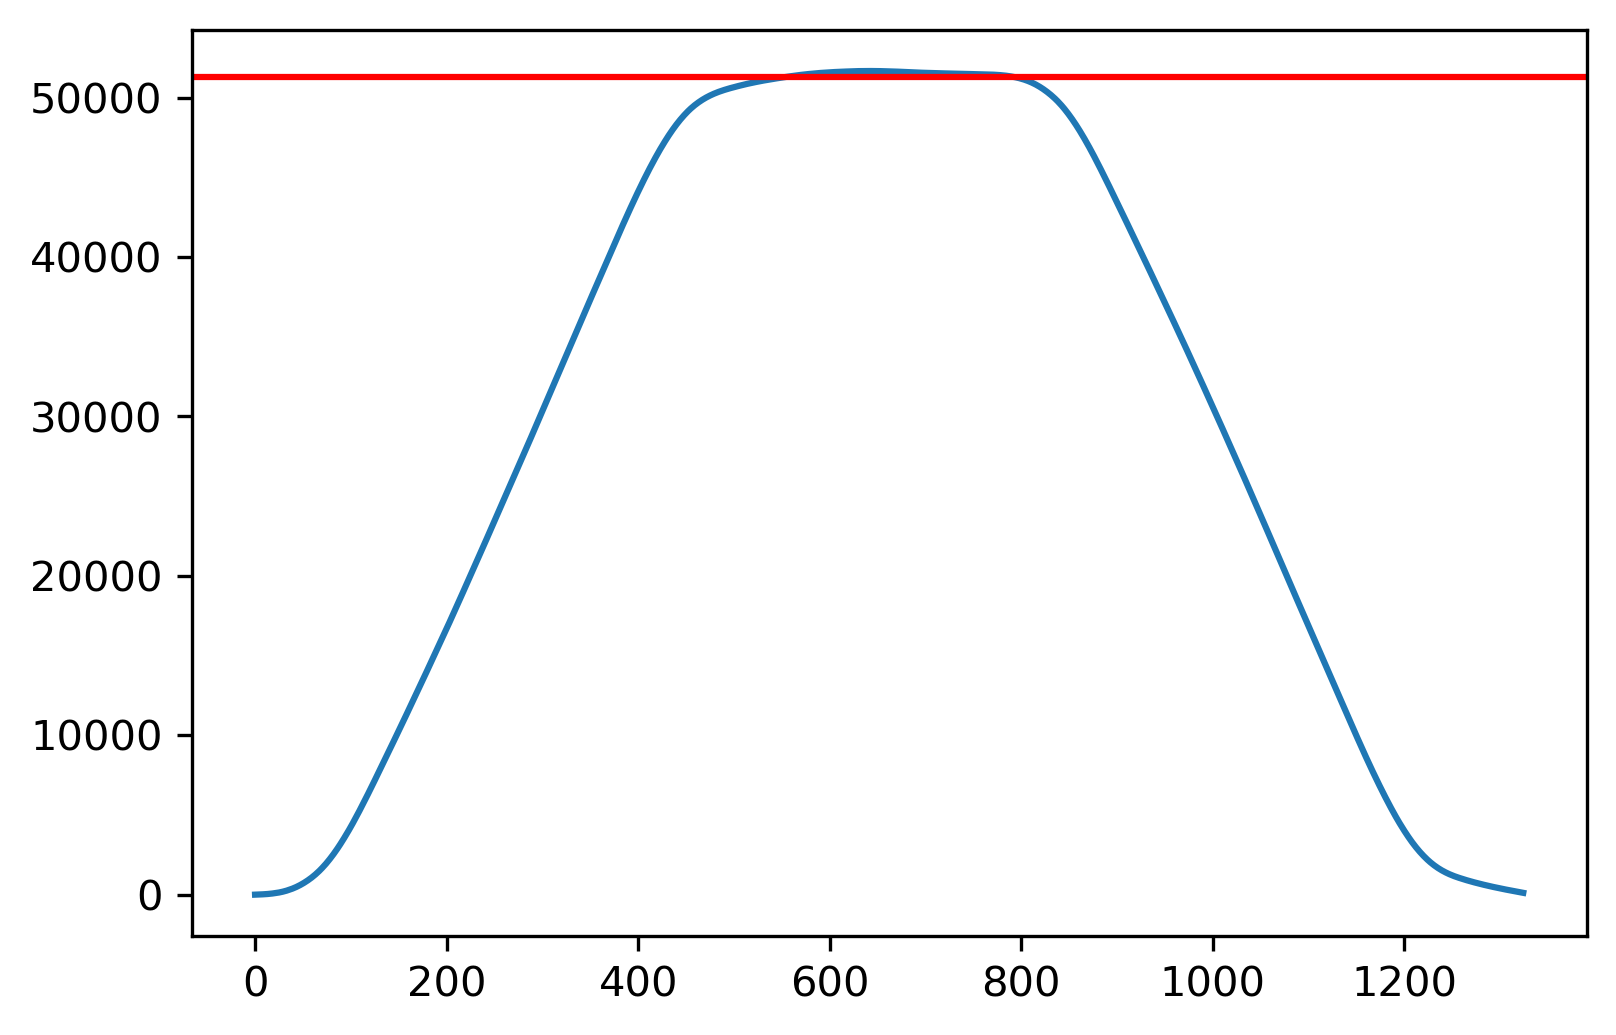

In [281]:
ind = 
th = trapezoid_height(trap_np[ind])

plt.figure(dpi=300)
plt.plot(trap_np[ind])
plt.axhline(th, c='r')
plt.show()

In [322]:
trap_np = np.load('Data/Fit-Data-New/Cs137_p220_g0.npy')

In [ ]:
plt.plot(fit_trap(np.arange(len(traps[i])), *h))

In [332]:
spectra_height = []
nans = []

for i, trap in enumerate(trap_np):
    th = trapezoid_height(trap)
    if math.isnan(th):
        nans.append(i)
        continue
        
    if th < 365000:
        spectra_height.append(th)

/Users/raptor/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/raptor/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/raptor/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


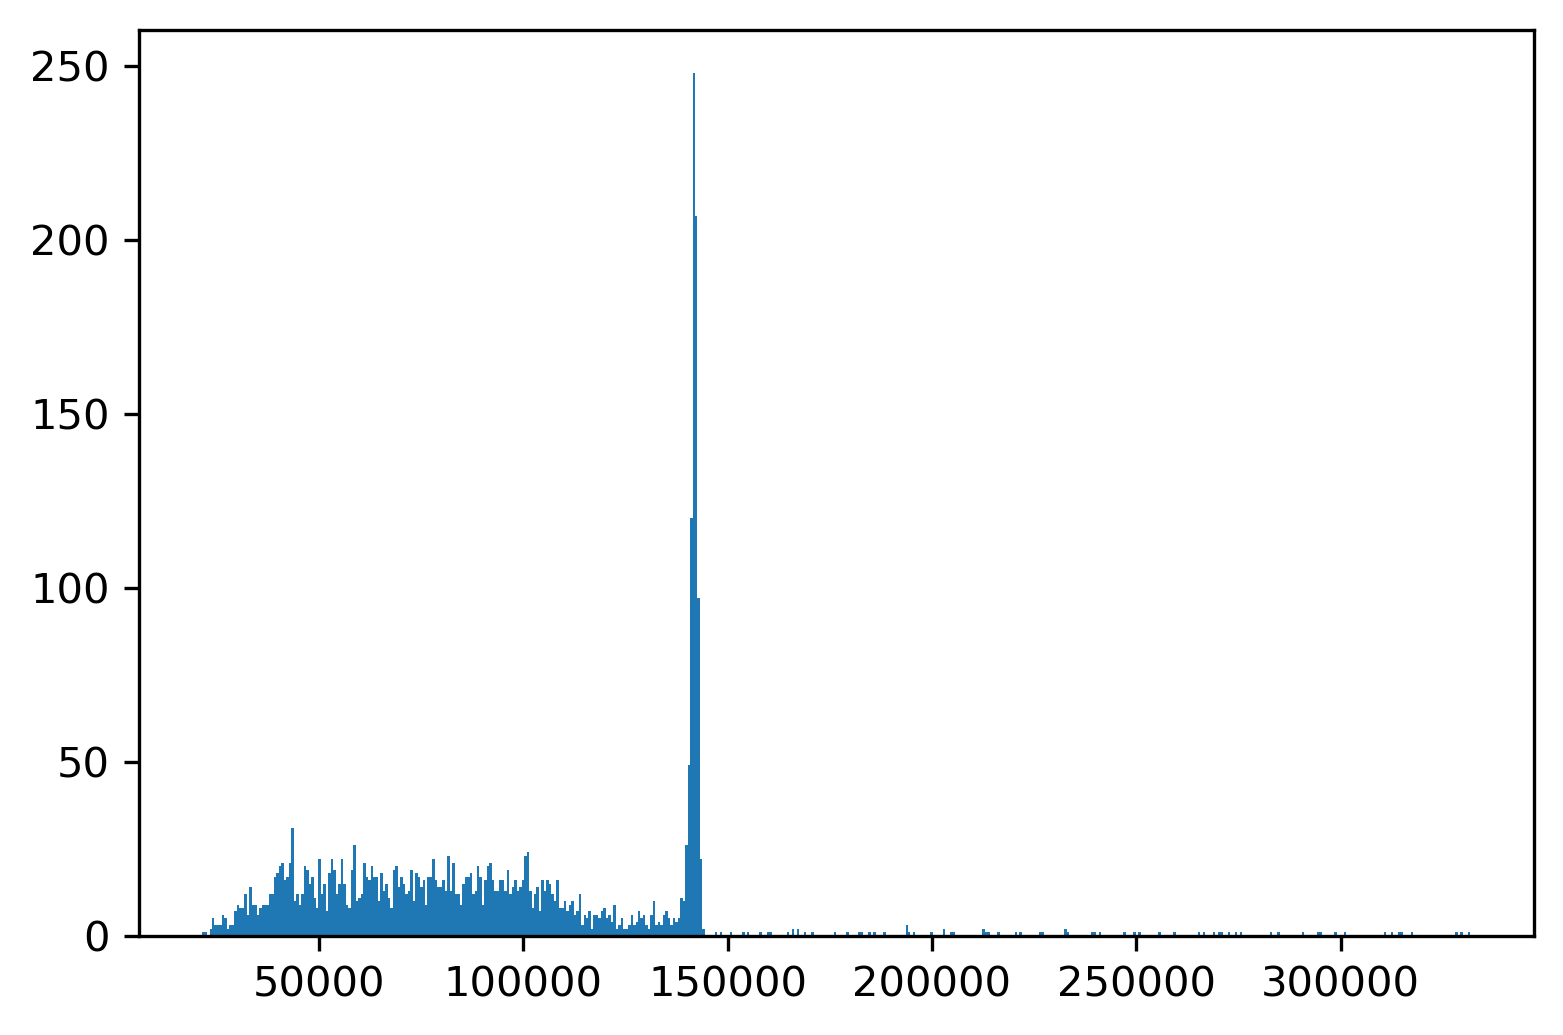

In [334]:
plt.figure(dpi=300)
plt.hist(spectra_height, bins=2**9)
plt.show()

In [324]:
nans

[76,
 83,
 175,
 189,
 425,
 464,
 641,
 949,
 1016,
 1428,
 1454,
 1754,
 1850,
 1888,
 2099,
 2105,
 2208,
 2242,
 2288,
 2322,
 2779,
 2986,
 3116,
 3126,
 3208,
 3306,
 3356,
 3517,
 3529,
 3641,
 3752,
 3986,
 4063,
 4185,
 4251,
 4317,
 4351,
 4458,
 4489,
 4513,
 4555,
 4989,
 5102,
 5243,
 5275,
 5539,
 5648,
 5733,
 5946,
 6049,
 6321,
 6428,
 6463,
 6497,
 6517,
 6961,
 6996,
 7030,
 7050]

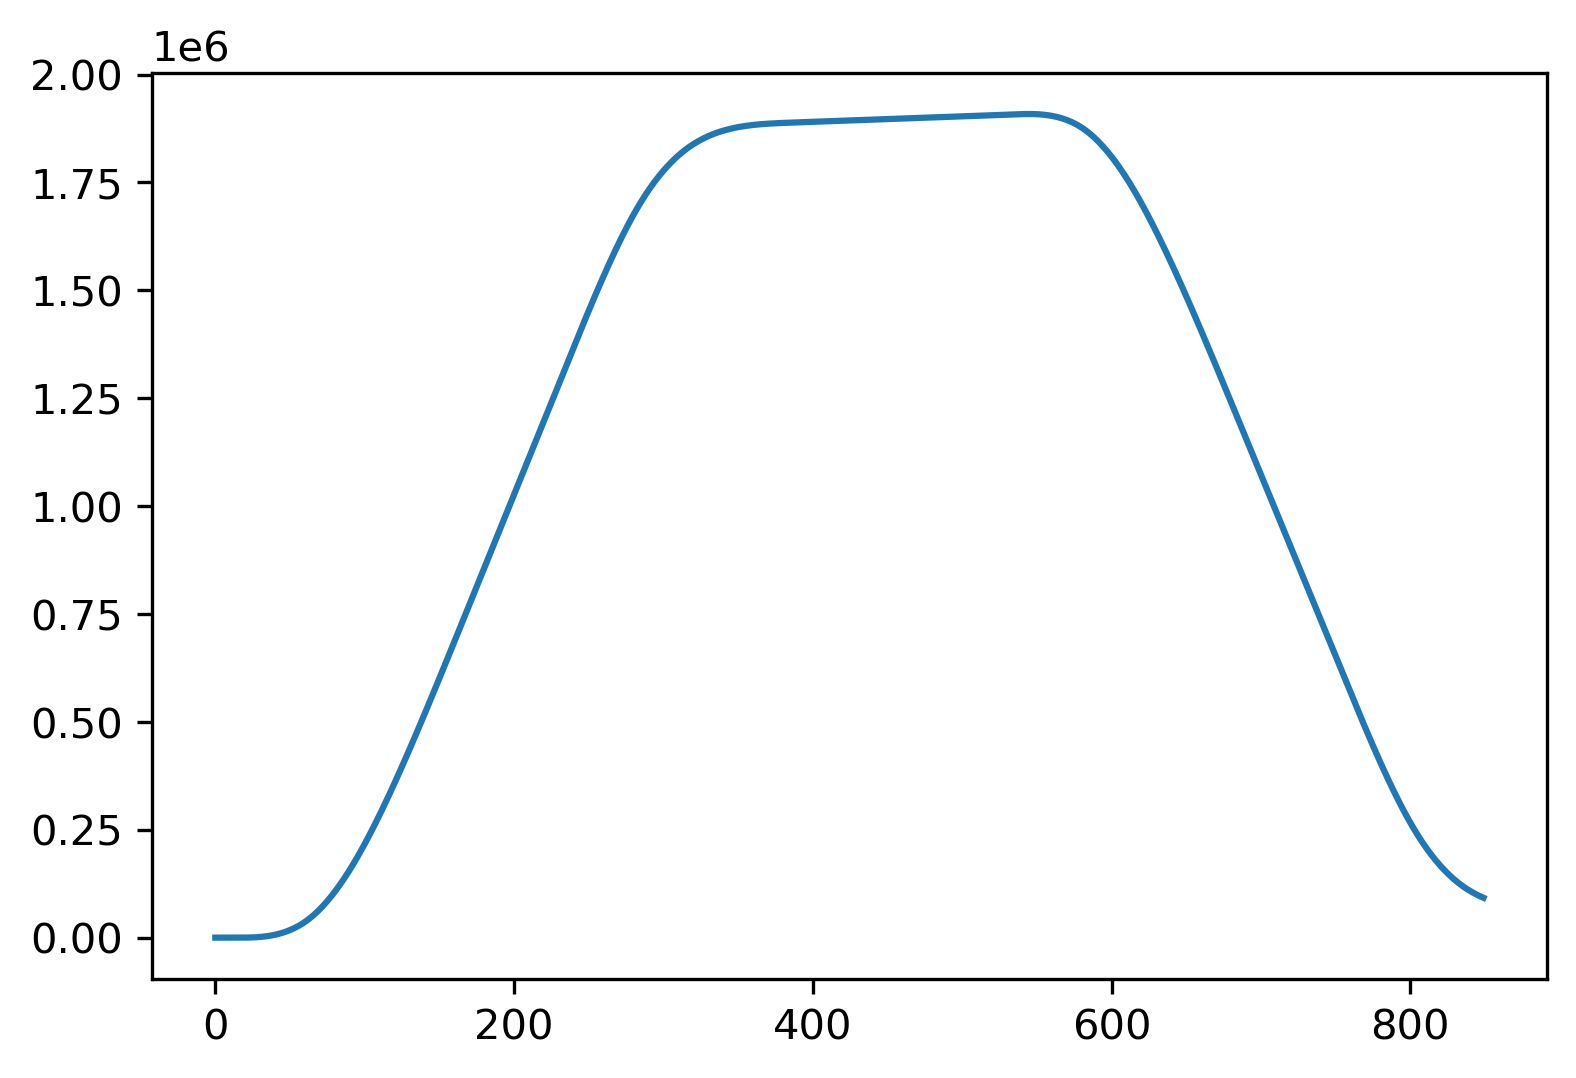

In [326]:
plt.figure(dpi=300)
plt.plot(trap_np[76])

In [336]:
test_220_0 = np.load('Data/Fit-Data-New/Cs137_p220_g0.npy')
test_220_500 = np.load('Data/Fit-Data-New/Cs137_p220_g500.npy')

In [337]:
spec_0 = []
for trap in tqdm(test_220_0):
    th = trapezoid_height(trap)
    if not math.isnan(th):
        if th < 365000:
            spec_0.append(th)
        
spec_500 = []
for trap in tqdm(test_220_500):
    th = trapezoid_height(trap)
    if not math.isnan(th):
        if th < 365000:
            spec_500.append(th)

  0%|          | 0/7432 [00:00<?, ?it/s]

  0%|          | 0/7432 [00:00<?, ?it/s]

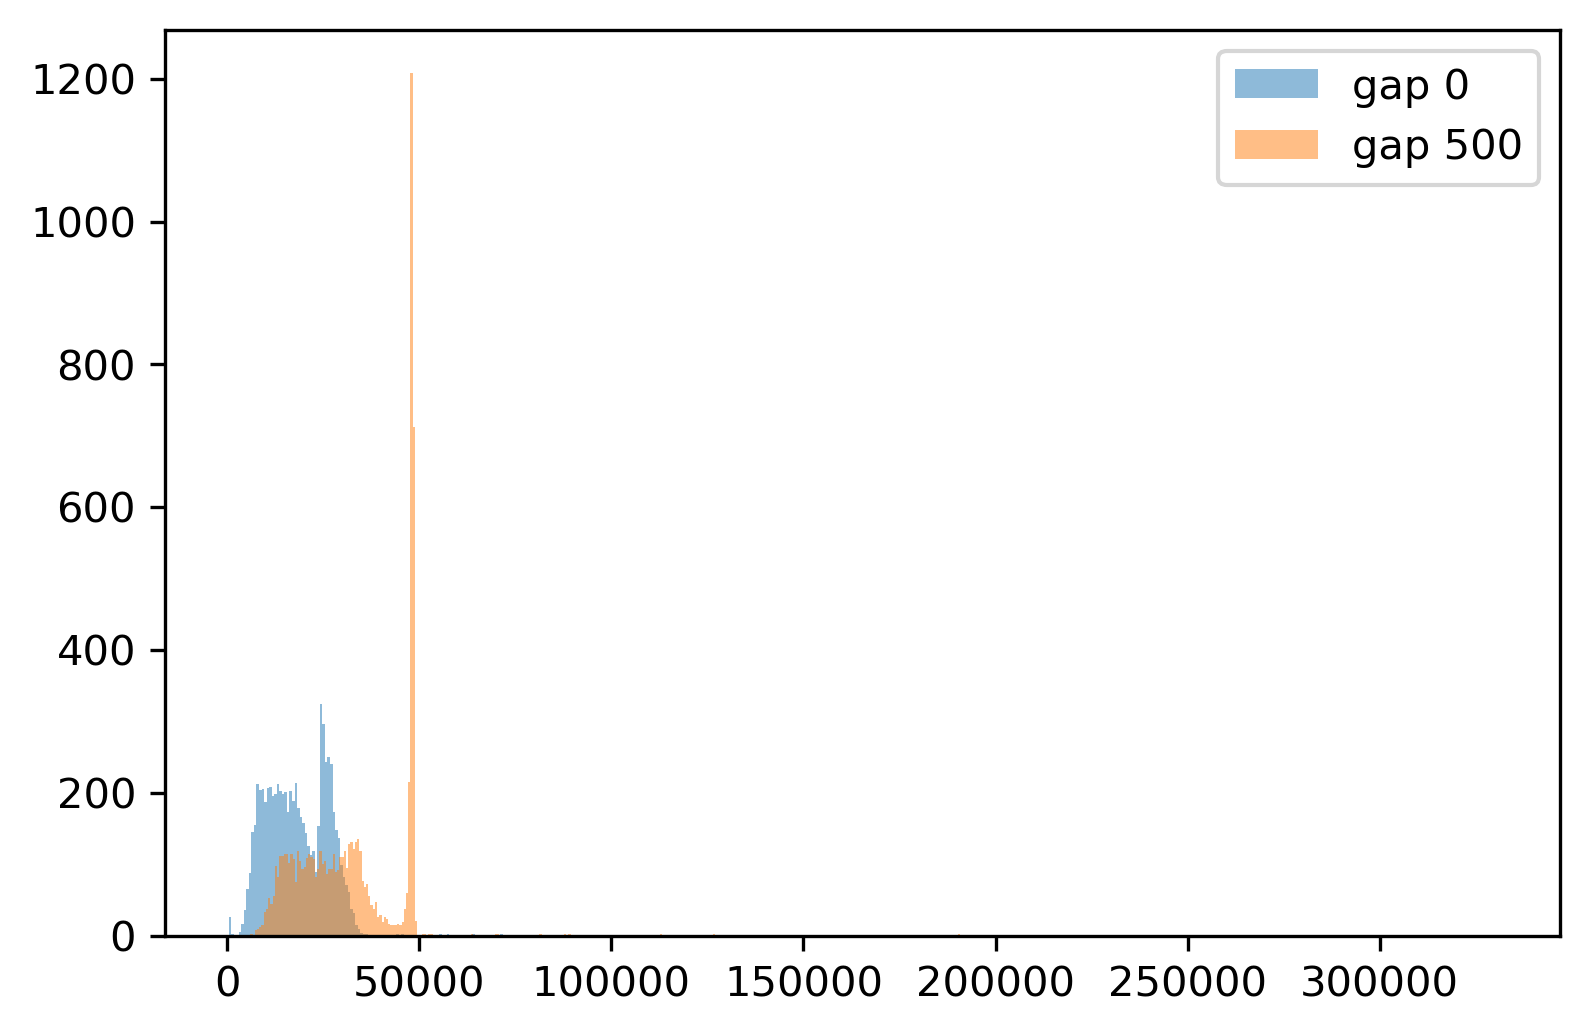

In [338]:
plt.figure(dpi=300)
plt.hist(spec_0, bins=500, alpha=0.5, label='gap 0')
plt.hist(spec_500, bins=500, alpha=0.5, label='gap 500')
plt.legend()
plt.show()

In [6]:
#peak_int = 'p220'
peak_values = ['p{}'.format(p) for p in range(220,530,10)]

pv = 'p530'
#for pv in tqdm(peak_values):
trap_files = [[int(f.split('.')[0].split('_')[2][1:]), 'Data/Fit-Data-New/'+f] for f in os.listdir('Data/Fit-Data-New/') if f != '.DS_Store' and pv in f]
trap_files.sort()

gauss_fit_results = []

import warnings
warnings.filterwarnings("ignore")

all_counts = []
for tf in tqdm(trap_files, leave=False, desc='Fitting Gaussians'):
    traps = np.load(tf[1])

    spectra = []

    for tr, trap in enumerate(tqdm(traps, desc='Creating spectra', leave=False)):
        try:
            th = trapezoid_height(trap)
        except:
            print('g{}: Index {} failed to fit trapezoid'.format(tf[0], tr))
            continue
        if not math.isnan(th):
            if th < 365000:
                spectra.append(th)
    bins_ = np.linspace(0,365000,1024)
    counts, bins, patches = plt.hist(spectra, bins=bins_)
    all_counts.append(counts)
    win_min, win_max = 0.90*bins[np.argmax(counts)], 1.4*bins[np.argmax(counts)]
    plt.axvline(win_min, c='r')
    plt.axvline(win_max, c='r')


    start = np.argmin(np.abs(bins - win_min))
    end = np.argmin(np.abs(bins - win_max))

    gauss_result = gauss_fit(bins[start:end], counts[start:end])

    plt.plot(bins, gauss(bins, *gauss_result))
    plt.xlim(0.5*win_min, 1.5*win_max)
    plt.ylim(0, max(counts)*1.1)

    tit_inf = tf[1].split('.')[0].split('_')
    plt.title('Peak: {}, Gap: {}\nResolution: {}%'.format(tit_inf[-2][1:], tit_inf[-1][1:], round(np.abs(((gauss_result[3]*2.35482)/gauss_result[2])*100), 3)))
    plt.savefig('Plots/Cs137_Fitting/Fit_gaussian_cs137_p{}_g{}.png'.format(tit_inf[-2][1:], tit_inf[-1][1:]), dpi=300)
    plt.close()

    gauss_fit_results.append(gauss_result)
all_counts = np.array(all_counts)
gauss_fit_results = np.array(gauss_fit_results)
#resolutions = np.abs(((gauss_fit_results[:,3]*2.35482)/gauss_fit_results[:,2])*100)
np.save('Data/Cs137-Gauss-Fits/bins.npy', bins_)
np.save('Data/Cs137-Gauss-Fits/Counts-Old/{}_g-vary_counts.npy'.format(pv), all_counts)
np.save('Data/Cs137-Gauss-Fits/Fits-Old/{}_g-vary_fits.npy'.format(pv), gauss_fit_results)

Fitting Gaussians:   0%|          | 0/51 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

g340: Index 3517 failed to fit trapezoid
g340: Index 3848 failed to fit trapezoid


Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

g490: Index 3848 failed to fit trapezoid


Creating spectra:   0%|          | 0/7432 [00:00<?, ?it/s]

In [68]:
test_old = np.load('Data/Cs137-Gauss-Fits/Counts-Old/p220_g-vary_counts.npy')

In [71]:
test_old

(1023,)

In [73]:
all_counts.shape

(1023,)

In [75]:
bins_.shape

(1024,)

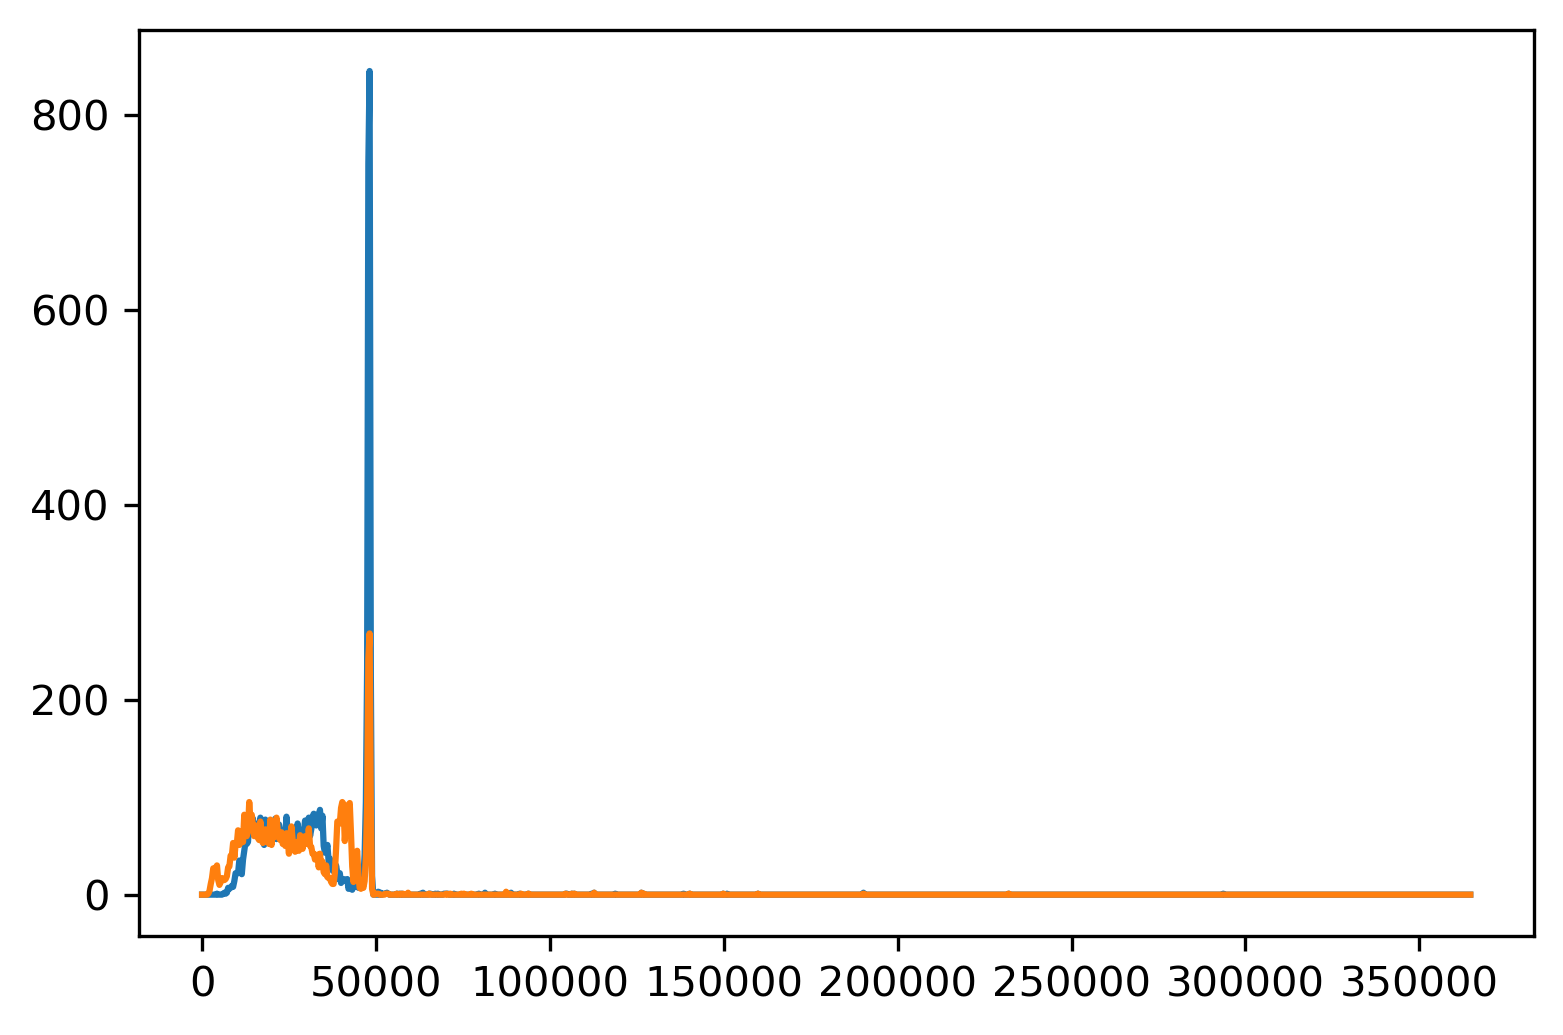

In [77]:
plt.figure(dpi=300)
plt.plot(bins_[:-1], test_old)
plt.plot(bins_[:-1], all_counts)
plt.show()

In [63]:
int(trap_files[0][1].split('p')[1][:3])+trap_files[0][0]

280

In [64]:
traps = np.load(trap_files[0][1])
popt, pcov = curve_fit(trapezoid, np.arange(len(traps[500])), traps[500], method = 'lm',
                      p0=[200, -8000, 200, int(trap_files[0][1].split('p')[1][:3]), int(trap_files[0][1].split('p')[1][:3])+trap_files[0][0]])

In [65]:
popt

array([  186.68991531, -8761.2301925 ,   190.62608104,   366.2255635 ,
         347.14168345])

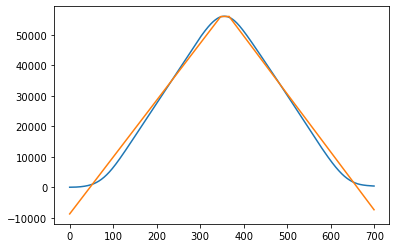

In [66]:
plt.plot(traps[500])
plt.plot(trapezoid(np.arange(len(traps[0])), *popt))


  0%|          | 0/7 [00:00<?, ?it/s]

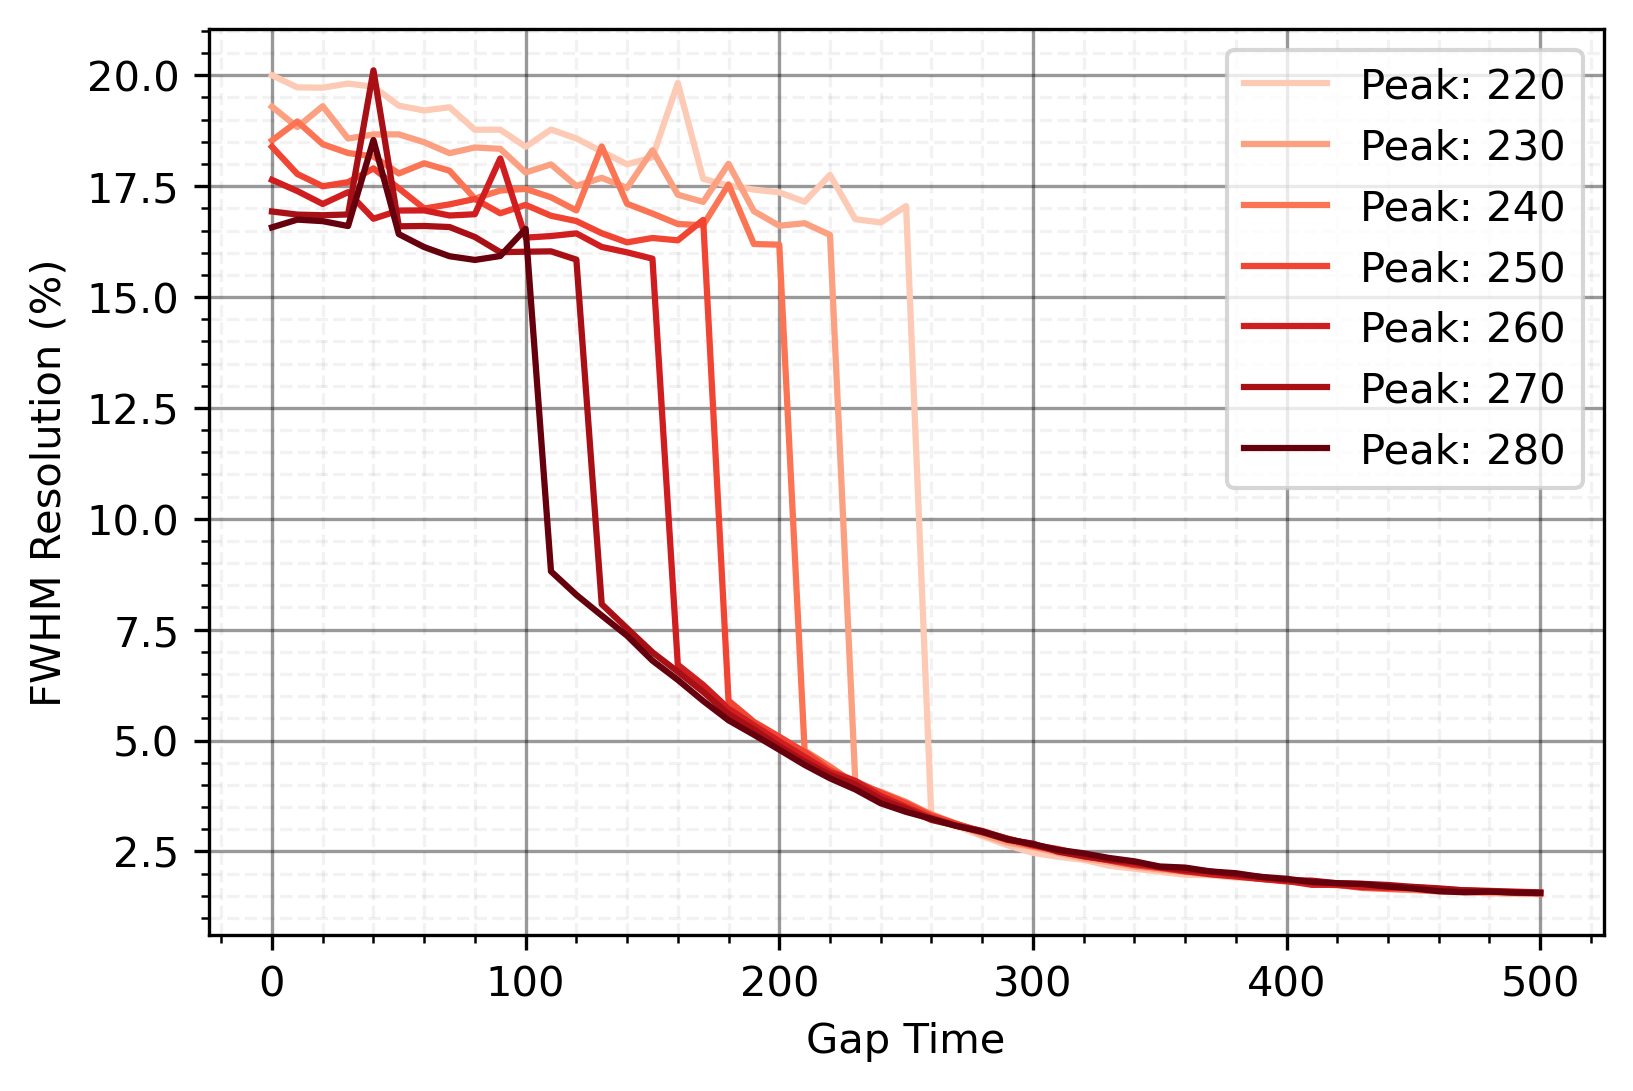

In [7]:
files = [[int(f.split('p')[1][:3]), 'Data/Cs137-Gauss-Fits/Fits/'+f] for f in os.listdir('Data/Cs137-Gauss-Fits/Fits/')]
files.sort()

cmap = plt.get_cmap('Reds')
colors = cmap(np.linspace(0.2, 1, len(files)))

gs = list(range(0,510,10))

plt.figure(dpi=300)
for i, file in enumerate(tqdm(files)):
    gfr = np.load(file[1])
    
    resolutions = np.abs(((gfr[:,3]*2.35482)/gfr[:,2])*100)
    
    plt.plot(gs, resolutions, label='Peak: {}'.format(file[0]), color=colors[i])
plt.legend()
plt.xlabel('Gap Time')
plt.ylabel('FWHM Resolution (%)')
plt.grid(which='major', color='k', linestyle='-', alpha=0.4)
plt.minorticks_on()
plt.grid(which='minor', color='k', linestyle='--', alpha=0.05)
plt.show()

In [443]:
counts

array([0., 0., 0., ..., 0., 0., 0.])

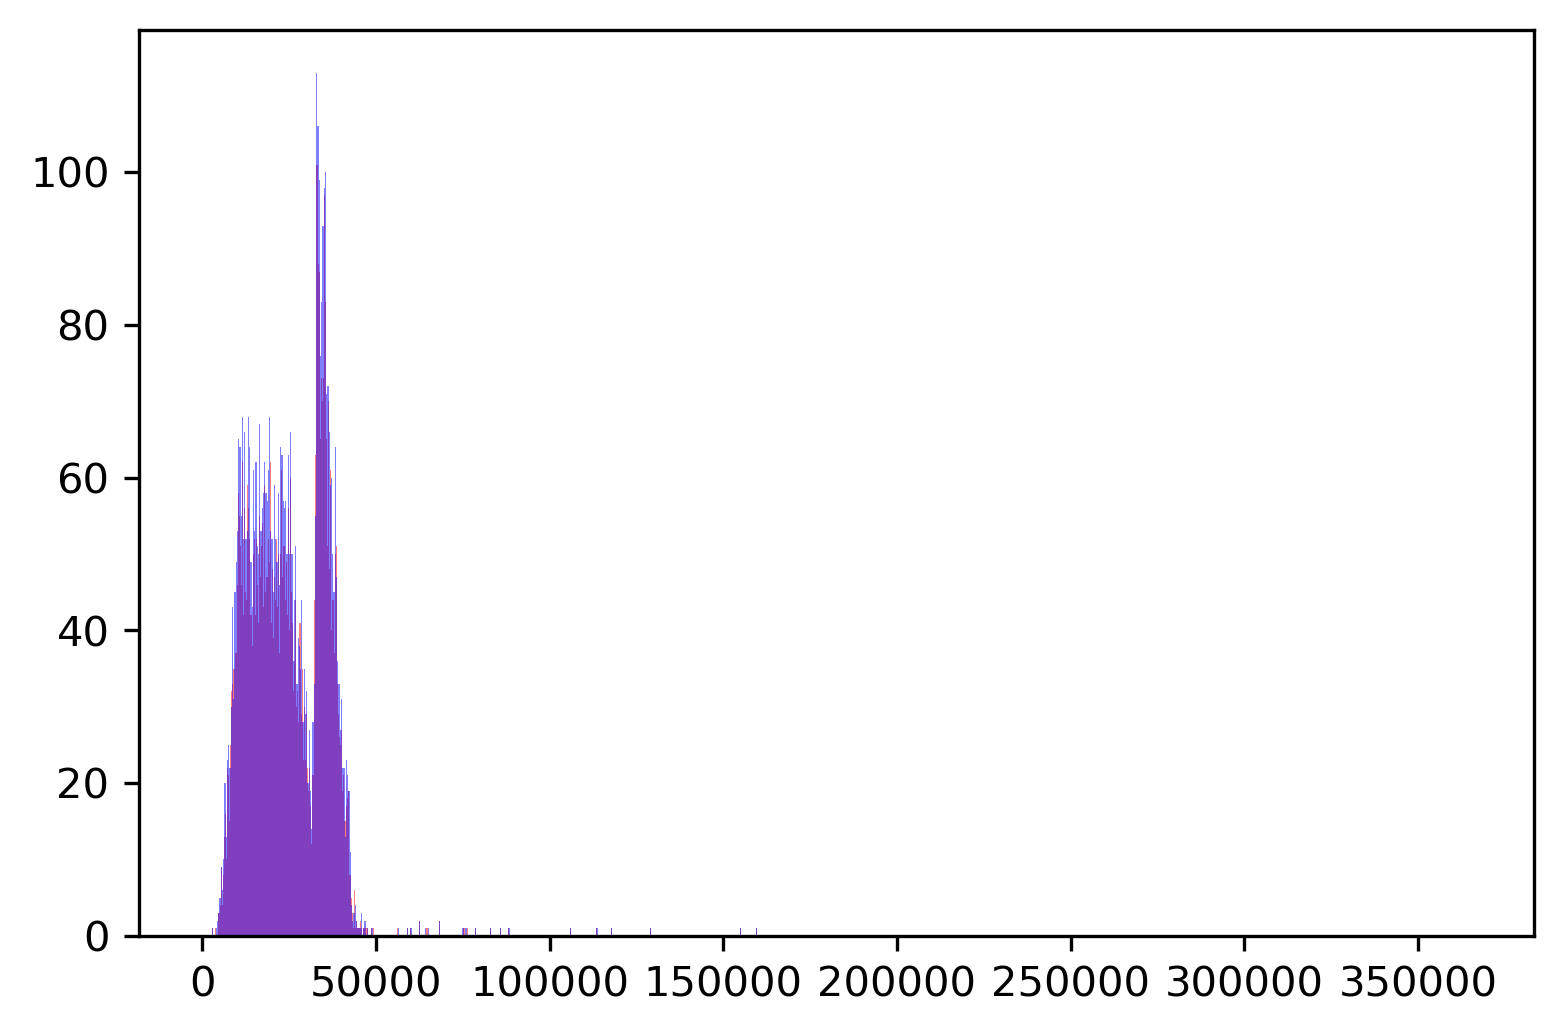

In [441]:
plt.figure(dpi=300)
counts, bins, patches = plt.hist(spectra, bins=512, color='r', alpha=0.5)
counts, bins, patches = plt.hist(spectra, bins=np.linspace(0,365000, 1024), color='b', alpha=0.5)

In [426]:
np.save('Data/Cs137-Gauss-Fits/p220_g-vary_fits.npy', gauss_fit_results)

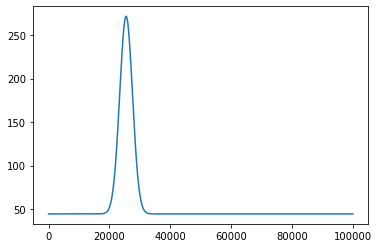

In [424]:
plt.plot(gauss(np.arange(100000), *gauss_fit_results[0]))

In [409]:
gauss_fit_results = np.array(gauss_fit_results)
resolutions = np.abs(((gauss_fit_results[:,3]*2.35482)/gauss_fit_results[:,2])*100)

In [415]:
np.argmax(resolutions)

13

  0%|          | 0/7432 [00:00<?, ?it/s]

10.369740724563599


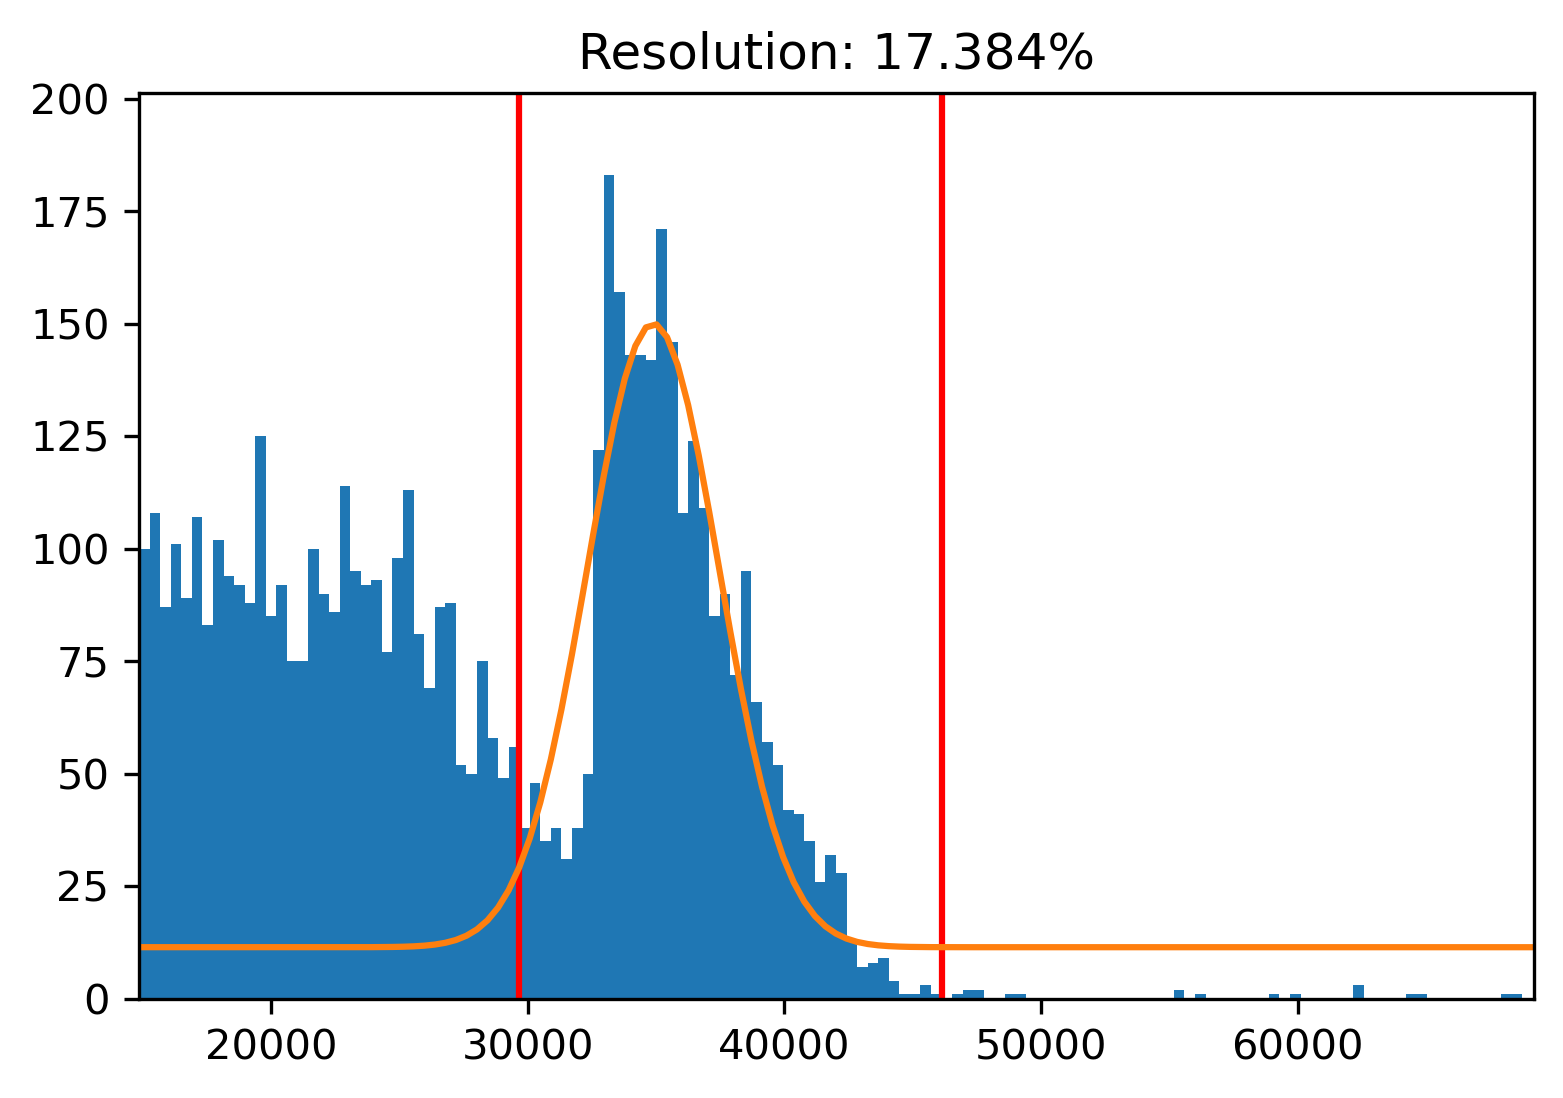

In [437]:
test_traps = np.load(trap_files[13][1])
st = time.time()
spec = []
for trap in tqdm(test_traps):
    th = trapezoid_height(trap)
    if not math.isnan(th):
        if th < 365000:
            spec.append(th)
print(time.time()-st)

plt.figure(dpi=300)
counts, bins, patches = plt.hist(spec, bins=512)
win_min, win_max = 0.90*bins[np.argmax(counts)], 1.4*bins[np.argmax(counts)]
plt.axvline(win_min, c='r')
plt.axvline(win_max, c='r')


start = np.argmin(np.abs(bins - win_min))
end = np.argmin(np.abs(bins - win_max))

gauss_result = gauss_fit(bins[start:end], counts[start:end])

plt.plot(bins, gauss(bins, *gauss_result))
plt.xlim(0.5*win_min, 1.5*win_max)
plt.ylim(0, max(counts)*1.1)
plt.title('Resolution: {}%'.format(round(np.abs(((gauss_result[3]*2.35482)/gauss_result[2])*100), 3)))
plt.show()

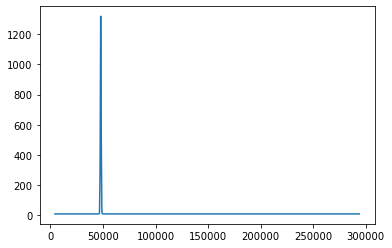

In [393]:
plt.plot(bins, gauss(bins, *gauss_result))

In [391]:
gauss_result

array([-2360547.37586871,  3974466.60253368,  2460720.19721673,
        2410631.72264666])

In [371]:
win_max

101518.18488712955

In [361]:
gauss_result

array([3.33776329e+00, 5.14765850e+00, 4.33731990e+04, 2.47234856e+02])

In [320]:
spe_hist = np.histogram(spec_0, bins=2**11)
    
start = np.argmin(np.abs(spe_hist[1] - 4.5e4))
end = np.argmin(np.abs(spe_hist[1] - 6e4))

gauss_result = gauss_fit(spe_hist[1][start:end], spe_hist[0][start:end])

print('Resolution: {}%'.format(round(np.abs(((gauss_result[3]*2.35482)/gauss_result[2])*100), 3)))

Resolution: 2.425%


In [369]:
spe_hist = np.histogram(spec_500, bins=2**11)
    
start = np.argmin(np.abs(spe_hist[1] - 4.5e4))
end = np.argmin(np.abs(spe_hist[1] - 6e4))

gauss_result = gauss_fit(spe_hist[1][start:end], spe_hist[0][start:end])

print('Resolution: {}%'.format(round(np.abs(((gauss_result[3]*2.35482)/gauss_result[2])*100), 3)))

Resolution: 1.487%


In [315]:
np.abs(((gauss_result[3]*2.35482)/gauss_result[2])*100)

2.4248377089612116

In [335]:
spe_hist = np.histogram(spectra_height, bins=2**11)
    
start = np.argmin(np.abs(spe_hist[1] - 125000))
end = np.argmin(np.abs(spe_hist[1] - 150000))

gauss_result = gauss_fit(spe_hist[1][start:end], spe_hist[0][start:end])

print('Resolution: {}%'.format(round(np.abs(((gauss_result[3]*2.35482)/gauss_result[2])*100), 3)))

Resolution: 1.175%
